## Table of Contents
<a id='contents'></a>

[Abstract](#abstract)

[Python working setup](#pySetup)  
  - [Bayesian modeling setup](#bayesSetup)
  - [First data](#firstData)  

[GIS files and other base data](#GISfiles)

[Species accumulation curves](#SAC)  
 - [Overall species accumulation curves](#SACoverall)
 - [Species accumulation curves of one 0.5 ha plot](#SACpermplot)
 - [Species accumulation curves by habitat](#SAChab)

[Tree community turnover (distance decay)](#turnover)
  - [Turnover by physical distance](#turnoverPhysical) 
      - [Turnover rates by habitat](#turnoverHab)
      - [Overall (all habitats) by physical distance](#turnoverPhysOverall)
  - [Overall turnover by watershed crossings](#turnoverMicrocuenca)

[Ordination by habitat](#NMS)

[Generate environmental data from DEM](#DEM)  
  - [Slope (and a note about GPS vs. DEM elevation data)](#slope)
  - [aspect](#aspect) 
  - [distance to streams](#streams)
  
[PERMANOVA models of available environmental data](#PERMANOVA)  

[hierarchical clustering of sites](#hierarch)

[Prediction of current ecological state by land use history](#landUseOnlymultinomial)

[Elevation of current ecological states](#elevationClust)

[Combined model of current ecological state by land use and elevation](#comboModel)

[Physical Map](#DEMmap)

[Watershed delineations](#watersheds)
  - [define microcuencas](#makeMicrocuencas)  
  - [make distance matrix from microcuenca map](#microcuencaDistanceMatrix)

[Indicator species analysis](#indSpp)

[Mantel tests](#mantel)

[MEM spatial analysis (all points)](#mem)  
  - [Turning MEMs into spatial objects for python](#MEM2python)
  - [Correlations among MEMs and environmental data](#MEMcorrs)

[Old Forest Sites - a closer look](#ofs)  
 - [PERMANOVA models of environmental predictors for old forest types](#oldPerms)
 - [check differences among old forest subplots by historical habitat type](#oldForestHabitat)
 - [Grouping in old forests by elevation](#oldForestOrdElev)  
   - [Linear model for distinguishing old forest types by elevation](#oldForestLogit)  
 - [Grouping in old forests by distance to water](#oldForestOrdWater)
 

[Juvenile communities - a glimpse into the future?](#joven)  
  - [Notes about preparing the juvenile data](#juvClean)  
  - [Juvenile points, relation to Adult clusters](#childrenOfClusters) 
  - [Juvenile points, relation to habitat type](#childrenOfHabitat)
  - [Hierarchical clustering of juveniles](#juvHier)
  
[Deforestation in the region](#deforest)  
  - [Data cleanup](#dataCleanup)
  - [Maps of forest cover](#mapDeforest)  
  - [Deforestation statistics](#barchartDeForestation)
  
[Updating climate data for los Cedros](#climate)

<a id='abstract'></a>
### Abstract

Here we conduct an analysis of a tropical montane cloud forest  historical data from a series of rapid vegetation inventories that were conducted in a cloud forest in northern Andean Ecuador. Trees in plots from several types of forest were counted and measured, including (1) primary forest, including mature and intermediate closed-canopy sites and naturally formed gaps, (2) abandoned pasture, and (3) abandoned sugar cane plantation sites. The goal of the study was to understand in a specific period of time the similarities and differences among natural and anthropogenic disturbances and their potential long term effect of different types of disturbance on the forest plant community. We find that mature and intermediate intermediate close canopy sites are  similar. Also  old forest is quite resilient to gap-forming disturbance. Natural gaps are quickly colonized by old-forest-associated plant species, and return to an old-forest-type community of trees in a short time. In contrast, forests regenerating from anthropogenic disturbance appear to have multiple possible states: some regenerating forest sites on places where the anthropogenic disturbance were low  are coming to closely resemble old-forest-type communities, but some where the anthropogenic disturbance was intense appear to be moving in a very different direction, which does not resemble any other vegetation community type currently in the forest. A major predictor of present ecological state is the type of land use before reforestation: pastures appear to be able to occasionally transition back to the pre-disturbance state of forest. More intensively used sites, many of which are abandoned sugar cane plantations, appear unable to return to a pre-disturbance ecological state, instead forming a new and different kind of forest, dominated by a different community of trees. We examine tree-seedling communities to understand the trajectory of the forest into the future, and find that new forest types may be forming that do not resemble any existing associations. We also find that Los Cedros is extremely diverse in tree species. We estimate approximately 500 species of tree in only the small southeastern area of the reserve that has been explored scientifically. Additionally, the forest tree community shows extremely rapid distance decay, approaching near complete turn-over in the limited span of the study. This may mean that hundreds of other tree species remain to be observed in the reserve, in addition to the 350+ that are directly observed in the present study. We also highlight the conservation value of Reserva Los Cedros, which has managed to reverse deforestation within its boundaries despite a general trend of extensive deforestation in the surrounding region, and to protect large, contiguous areas of highly-endangered Andean primary cloud forest habitat. We report numerous new observations of plants holding IUCN threatened status.


<a id='pySetup'></a>
### Python working setup

Our python versioning may get confusing. My environment is, broadly speaking, Ubuntu 20.04, which ships with python 3.8.5. This is what I have used for most of the following analysis. 

However for our bayesian modeling of the tree community turnover, we'll be using a PyMC3 sampler, which seems to work best with older python versions...see below.

In [1]:
import os
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.ion(); plt.rc('axes', titlesize=15)
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import pickle
from sklearn.linear_model import LinearRegression
import scipy.spatial as sp
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import copy
import random
import math
import networkx
from pysheds.grid import Grid
import shapely
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


[back to top](#contents)

<a id='bayesSetup'></a>

### Bayesian modeling setup
So, as per above, our bayes environment has to work within a conda environment I have set up that uses an older version of python. To use it, initiate it before the jupyter notebook is started up. An conda environment file for this bayesian sub-project is "bayesAna.yml" in the repo. This project will have to be a little separate and we can use the following import block instead:

In BASH get conda environment going:
```
conda activate bayesAna
```

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.spatial as sp
import geopandas as gpd
import theano.tensor as tt
#from theano import shared
import rasterio
import scipy.stats as stats
import arviz as az
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import norm
plt.rc('axes', titlesize=15)

[back to top](#contents)

<a id='firstData'></a>

### First data
All of the following analysis started with a cleanup of Ana's raw data, to create the following working dataframe. It has most of what I need up to this point.

In [5]:
specObs = pd.read_pickle('specObs.p')
specObs.head()

site parcela subparcela PsubP          familia    genero     especie  \
1    1       1          1   1.1   Flacourtiaceae    Banara       regia   
2    1       1          1   1.1  Melastomataceae   Leandra  subseriata   
3    1       1          1   1.1  Melastomataceae    Ossaea   micrantha   
4    1       1          1   1.1  Melastomataceae    Ossaea   micrantha   
5    1       1          1   1.1     Cecropiaceae  Cecropia  reticulata   

                         genusSpecies    habito elevacion habitat  
1         Flacourtiaceae Banara regia     Árbol      1425      RG  
2  Melastomataceae Leandra subseriata  Arbolito      1413      RG  
3    Melastomataceae Ossaea micrantha  Arbolito      1413      RG  
4    Melastomataceae Ossaea micrantha  Arbolito      1413      RG  
5    Cecropiaceae Cecropia reticulata     Árbol      1413      RG

For all of the analyses conducted so far, I have used the subplot as a basic sampling unit. These are denoted in the PsubP column, where the first number is the plot, and the number after the decimal is a subplot. Together they make a unique identifier. 

From this we can make a general site x species matrix:

In [15]:
smallSpecObs = specObs[['PsubP','genusSpecies']]
bdfDummy = pd.get_dummies(smallSpecObs['genusSpecies'])
bdfDummy.insert(0, 'PsubP', smallSpecObs.PsubP)
bdfDummyGroup = bdfDummy.groupby('PsubP')
subParcelComm = bdfDummyGroup.agg(np.sum)
subParcelComm.head()

Actinidaceae Saurauia sp. 1  Anacardiaceae Mauria cf. heterophylla  \
PsubP                                                                       
1.1                              5                                      0   
1.2                              0                                      0   
1.3                              0                                      0   
1.4                              0                                      0   
1.5                              0                                      0   

       Anacardiaceae Tapirira guianensis  \
PsubP                                      
1.1                                    0   
1.2                                    0   
1.3                                    0   
1.4                                    0   
1.5                                    0   

       Annonaceae Guatteria cf. megalophylla  \
PsubP                                          
1.1                                        0   
1.2                                        0   
1.3                                        0   
1.4                                        1   
1.5                                        0   

       Annonaceae Guatteria megalophylla  Annonaceae Guatteria sp.  \
PsubP                                                                
1.1                                    0                         0   
1.2                                    0                         0   
1.3                                    0                         0   
1.4                                    0                         0   
1.5                                    0                         0   

       Annonaceae Rollinia aff. dolichopetala  Annonaceae Rollinia edulis  \
PsubP                                                                       
1.1                                         0                           0   
1.2                                         0                           0   
1.3                                         0                           0   
1.4                                         0                           0   
1.5                                         0                           0   

       Annonaceae sp.  Aquifoliaceae Ilex cf. yurumanguinis  ...  \
PsubP                                                        ...   
1.1                 0                                     0  ...   
1.2                 0                                     0  ...   
1.3                 0                                     0  ...   
1.4                 0                                     0  ...   
1.5                 0                                     0  ...   

       Theophrastaceae Clavija eggersiana  \
PsubP                                       
1.1                                     0   
1.2                                     0   
1.3                                     0   
1.4                                     0   
1.5                                     0   

       Theophrastaceae Clavija membranacea  \
PsubP                                        
1.1                                      0   
1.2                                      0   
1.3                                      0   
1.4                                      0   
1.5                                      0   

       Thymelaeaceae Schoenobiblus daphnoides  Ulmaceae Trema micrantha  \
PsubP                                                                     
1.1                                         0                         0   
1.2                                         0                         0   
1.3                                         0                         0   
1.4                                         0                         0   
1.5                                         0                         0   

       Urticaceae Boehmeria caudata  Urticaceae Urera aff. caracasana  \
PsubP                                                                   
1.

Exploring our data a bit:

In [8]:
specObs.columns

Index(['site', 'parcela', 'subparcela', 'PsubP', 'familia', 'genero',
       'especie', 'genusSpecies', 'habito', 'elevacion', 'habitat'],
      dtype='object')

In [6]:
specObs.shape

(2737, 11)

2737 observations, each one representing a collection of a plant. Lots of plants. How many species observed?

In [10]:
len(specObs.genusSpecies.unique())

343

[back to top](#contents)

<a id='GISfiles'></a>
### GIS files and other base data

We use and generate a lot of GIS resources and other supporting files. GIS files are in their own subdirectory in the repo ("./GIS"). Also in this list are a few dataframes, etc that we use heavily. For easy loading, and reduced rerunning of supporting cells, here they are:

In [2]:
## GIS
rioLCWatershedPoly = gpd.read_file('GIS/rioLCwatershed.geojson')
rioMCWatershedPoly = gpd.read_file('GIS/rioMCwatershed.geojson')
lcPoly = gpd.read_file('GIS/lcPoly.geojson')
hydro = gpd.read_file('GIS/lcRiversStreams.geojson')
smallAstRast = rasterio.open('GIS/smallAster.tif')
anaPt = gpd.read_file('GIS/ana30meterPlots.geojson')
RLCgpd = gpd.read_file("./GIS/rioLCpredicted.geojson")
RMCgpd = gpd.read_file("./GIS/rioMCpredicted.geojson")
mainRLC = gpd.read_file("./GIS/mainRLC.geojson")
mainRMC = gpd.read_file("./GIS/mainRMC.geojson")
RLCCatchPolys = gpd.read_file('GIS/RLCCatchPolys.geojson')
RMCCatchPolys = gpd.read_file('GIS/RMCCatchPolys.geojson')
curatedMicrocuencas = gpd.read_file('GIS/losCedcatchpolys_subjective_closed.geojson')
dem = rasterio.open("GIS/anaPlotDEM.tif")
forest2018rast = rasterio.open("GIS/forest2018CotacachiCoded.tif")
forest1990rast = rasterio.open("GIS/forest1990CotacachiCoded.tif")
ccPoly = gpd.read_file("GIS/cotacachiCayapas.geojson", driver='GeoJSON')
cotacachi = gpd.read_file("GIS/cotacachiCanton.geojson", driver='GeoJSON')
chontalPoly = gpd.read_file("GIS/ChontalBP.geojson", driver='GeoJSON')
cebuPoly = gpd.read_file("GIS/cebuBP.geojson", driver='GeoJSON')
chontalForest1990 = rasterio.open("chontalForest1990.tif")
chontalForest2018 = rasterio.open("chontalForest2018.tif")
losCedrosForest1990 = rasterio.open("losCedrosForest1990.tif")
losCedrosForest2018 = rasterio.open("losCedrosForest2018.tif")


## etc
specObs = pd.read_csv('specObs.csv')
psubpHopsDF= pd.read_csv('psubpHopsDF.csv', index_col='PsubP')
subParcelComm = pd.read_csv('subParcelComm.csv', index_col='PsubP')
envOnly = pd.read_csv('envOnly.csv', index_col='PsubP')
landUseForesttypeDF = pd.read_csv('landUseForesttypeDF.csv', index_col='site')
watershedDistMat = pd.read_csv('watershedDistMat.csv', header=0, index_col=0)
watershedDistMat.columns = watershedDistMat.columns.astype('int')


[back to top](#contents)

<a id="SAC"></a>
### Species accumulation curves and alpha diversity

<a id='SACoverall'></a>
#### Overall species accumulation curves 

We can use the rapid assessment plots that Dr. Mariscal to draw an overall estimate of the number of species in the area covered by her study. We start in R for the `vegan` package but move over to python for plotting. 

In [1]:
## in R
library(vegan)
comM <- read.csv('subParcelComm.csv', row.names='PsubP')
aa <- specaccum(comM, method = "exact")
anaSAC <- data.frame(aa$richness, aa$sd)
colnames(anaSAC) <- c('richness', 'sd')
anaSpeciesEstimators = specpool(comM)
print(anaSpeciesEstimators)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



    Species     chao  chao.se    jack1 jack1.se    jack2     boot  boot.se  n
All     343 516.3946 39.15056 483.6557 21.60728 566.8038 404.4403 10.54889 61


The estimators seem to be hovering around 500 adult tree species in the area covered by Dr. Mariscal's study. We can fit a model to make some predictions.

In [2]:
mod1 <- fitspecaccum(aa, "lomolino")
anaPredYs <- predict(mod1, newdata=1:500)

In [9]:
#write.csv(anaSAC, file='anaSAC.csv')
#write.csv(anaPredYs, file='anaPredYs.csv')
#write.csv(anaSpeciesEstimators, file='anaSpeciesEstimators.csv')

A quick check here is interesting. In the section below we did a spatially systemic, grid-like sampling of a 0.5 ha area of los Cedros. Do our results from that 0.5 ha match the model from the area as a whole?

Our subplots are 30 m<sup>2</sup>, so a plot should equal how many hectares: 

In [5]:
pArea <- pi * (30/2)^2 / 10000
print(pArea)

[1] 0.07068583


In [6]:
## each unit on this x-axis represents one of Ana's subplots
## and each subplot represents 0.07 hectare sampled... so we need
## 0.5 ha * ( 1 plot / 0.07 ha ) = 

0.5 / pArea ## = 5.5556. 

predict(mod1, newdata=(0.5/pArea))

[1] 7.073553

[1] 112.0076

Compare this with the predicted ~60 species in our 0.5 ha plot, in the section below. Seems that maybe we sampled a spot that was on average of lower alpha diversity than other parts of the study area?

In general, what does this model predict for alpha diversity of 1 ha of Los Cedros forest?:

In [7]:
predict(mod1, newdata=(1.0/pArea)) 

[1] 169.6476

The model predicts 169.6 spp/ha. 

Let's plot the curve in matplotlib. So move on over to python...

In [18]:
## python
anaSAC = pd.read_csv('anaSAC.csv', index_col=0)
anaPredYs = pd.read_csv('anaPredYs.csv', index_col=0).x
anaSpeciesEstimators = pd.read_csv('anaSpeciesEstimators.csv', index_col=0).loc['All']

In [19]:
## each plot represents ~0.07 hectare sampled:
pArea = np.pi * (30/2)**2 / 10000
print(pArea)
## if we want ticks for every 20 hectares sampled
## every 5 ha? 5 ha = 70 plots:
tickSize = 5 / pArea 
print(tickSize)

0.07068583470577035
70.73553026306459


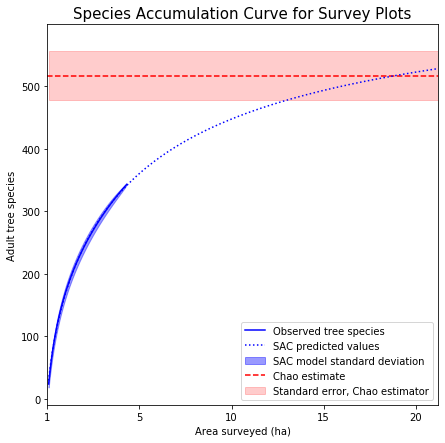

In [33]:
colr='b'
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(anaSAC['richness'],
            label='Observed tree species',
            color=colr)
ax.fill_between(x=anaSAC.index.to_numpy(),
                 y1=anaSAC.richness - anaSAC.sd,
                 y2=anaSAC.richness + anaSAC.sd,
                alpha=0.4,
                color=colr,
                label="SAC model standard deviation"
                )
ax.plot(anaPredYs.index.to_numpy(), anaPredYs,
            color=colr,
            linestyle=':',
            label='SAC predicted values',
            )
## put the chao estimator on there:
ax.hlines(anaSpeciesEstimators.chao,
    xmin = 0,
    xmax = 500,
    linestyle = "--",
    color = "r",
    label='Chao estimate',
)
ax.fill_between(x=anaPredYs.index,
                 y1=anaSpeciesEstimators.chao - anaSpeciesEstimators["chao.se"],
                 y2=anaSpeciesEstimators.chao + anaSpeciesEstimators["chao.se"],
                alpha=0.2,
                color='r',
                label="Standard error, Chao estimator"
                )

plt.rc('axes', titlesize=15)
ax.set_title("Species Accumulation Curve for Survey Plots")
tk = np.arange(0,6)*tickSize
ax.set_xticks(tk)
## the ha values of this would be:
tklabs = np.arange(0,6)*5
tklabs[0] = 1
ax.set_xticklabels(tklabs)
ax.set_xlabel('Area surveyed (ha)')
ax.set_ylabel('Adult tree species')
ax.set_xlim(0,300)
ax.legend(loc='lower right')
#plt.savefig("graphics/OverallSAC.svg")

[back to top](#contents)

<a id='SACpermplot'></a>
#### Species accumulation curves of one 0.5 ha plot

Dr. Mariscal and her colleagues began the process of establishing a permanent plot at Los Cedros, alongside the Rio Los Cedros. Dr. Roy and botanist Danilo Simba Larco revisited the site in 2012 to resample half of the plot for our 2016 study on <i>Xylaria</i> and its hosts. The resulting data is spatially explicit and very convenient for estimating species density in this half plot. Again, we start with the `vegan` package in R for its awesome species accumulation curve functions, then plot in matplotlib:

In [2]:
## R
library(vegan)
permPlotCCmat = read.csv('permPlotCCmat.csv')
daniloSpecaccum <- specaccum(permPlotCCmat, method = "exact")
daniloSACmod <- fitspecaccum(daniloSpecaccum, "lomolino")
daniloPredYs <- predict(daniloSACmod, newdata=1:500)
daniloSAC <- data.frame(daniloSpecaccum$richness, daniloSpecaccum$sd)
colnames(daniloSAC) <- c('richness', 'sd')
daniloSpeciesEstimators = specpool(permPlotCCmat)
#write.csv(daniloSAC, file='daniloSAC.csv')
#write.csv(daniloPredYs, file='daniloPredYs.csv')
#write.csv(daniloSpeciesEstimators, file='daniloSpeciesEstimators.csv')
print(daniloSpeciesEstimators)

    Species     chao  chao.se    jack1 jack1.se    jack2     boot  boot.se   n
All      43 65.37603 13.79745 61.84298 4.322875 72.72672 51.39211 2.194646 121


The various species estimators hover around 60 for this site. Compare this to our prediction of diversity for a 0.5 ha site using the model of the rapid assessment data, in the section above. We can make a map to look at, just to remember the sampling method.

In [35]:
trees = pd.read_csv('Trees2014.csv', index_col='Numero')
## make points, geopanda objects
aa = []
for i in range(0,110,10):
    aa += [ shapely.geometry.Point(i,j) for j in range(0,55,5) ]

bb = gpd.GeoSeries(aa)
## can we remove that last point that was never sampled?
bb.drop(120, axis=0, inplace=True)
bb.index = range(1,121)
permGPD = gpd.GeoDataFrame(data=trees, geometry=bb)
permGPD.Genus.unique()
permGPD['genspp'] = permGPD.Genus + "_" + permGPD.Species
## plot for getting random colors for each genera
def genXKCDColors(nu):
    Xcolors = random.choices(list(mcolors.XKCD_COLORS.values()), k=nu)
    cmap = mcolors.ListedColormap(Xcolors)
    return(cmap)

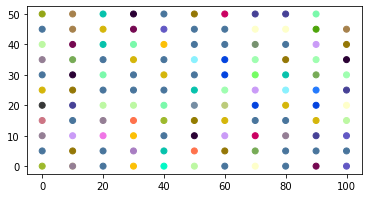

In [36]:
cmap=genXKCDColors(len(trees.Genus.unique()))
fig, ax = plt.subplots()
permGPD.plot(ax=ax, column='Genus', cmap=cmap)


That is colored by genera. Pretty diverse. How many families/genera/species are there in this plot?

In [37]:
print("Number of families: " + str(len(trees.Familia.unique())))
print("Number of genera: " + str(len(trees.Genus.unique())))
print("Number of species: " + str(len(trees.genspp.unique())))

Number of families: 25
Number of genera: 36
Number of species: 43


In [38]:
## python
daniloSAC = pd.read_csv('daniloSAC.csv', index_col=0)
daniloPredYs = pd.read_csv('daniloPredYs.csv', index_col=0).x
daniloSpeciesEstimators = pd.read_csv('daniloSpeciesEstimators.csv', index_col=0).loc['All']

Let's plot out the species accumulation curves from above:

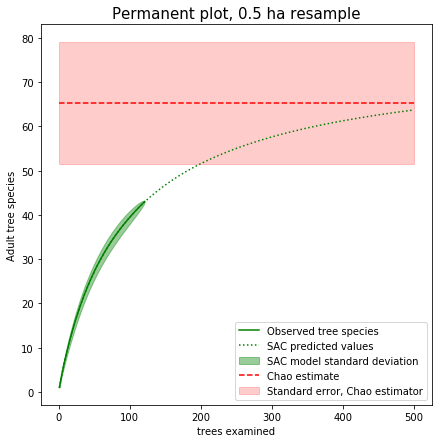

In [42]:
colr='g'
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(daniloSAC['richness'],
            label='Observed tree species',
            color=colr)

ax.fill_between(x=daniloSAC.index.to_numpy(),
                 y1=daniloSAC.richness - daniloSAC.sd,
                 y2=daniloSAC.richness + daniloSAC.sd,
                alpha=0.4,
                color=colr,
                label="SAC model standard deviation"
                )
ax.plot(daniloPredYs.index.to_numpy(), daniloPredYs,
            color=colr,
            linestyle=':',
            label='SAC predicted values',
            )
## put the chao estimator on there:
ax.hlines(daniloSpeciesEstimators.chao,
    xmin = 0,
    xmax = 500,
    linestyle = "--",
    color = "r",
    label='Chao estimate',
)
ax.fill_between(x=daniloPredYs.index,
                 y1=daniloSpeciesEstimators.chao - daniloSpeciesEstimators["chao.se"],
                 y2=daniloSpeciesEstimators.chao + daniloSpeciesEstimators["chao.se"],
                alpha=0.2,
                color='r',
                label="Standard error, Chao estimator"
                )
ax.legend(loc='lower right')
ax.set_ylabel('Adult tree species')
ax.set_xlabel('trees examined')
ax.set_title('Permanent plot, 0.5 ha resample')
#plt.savefig("graphics/permplotSAC.svg")

[back to top](#contents)

<a id='SAChab'></a>
#### Species accumulation curves by land-use/habitat
We can break this up into the land-use/habitat categories that Dr. Mariscal observed from each site.

We start with a little data wrangling in pandas (python), to split up our site-by-species matrix by habitat:

In [4]:
aa = pd.read_csv('envOnly.csv', index_col='PsubP')[['habitat']]
subParcelComm = pd.read_csv("subParcelComm.csv", index_col='PsubP')
bb = pd.concat([aa, subParcelComm], axis=1)
bbGrouped = bb.groupby('habitat')
habs = list(bbGrouped.groups.keys())

for i in habs:
    cc = bbGrouped.get_group(i)
    observed = (cc != 0).any(axis=0).values
    dd = cc.iloc[:,observed].copy()
    dd.drop('habitat', axis=1, inplace=True)
    dd.to_csv(f'{i}_comm.csv')

Now we can use these smaller dataframes to make turnover graphs and do chao estimates. Back to R:

In [5]:
library(vegan)
files <- list.files()
comm <- grep('_comm.csv', list.files())
comms <- files[comm]
for (i in comms){
    comm.i <- read.csv(i, header=TRUE, row.names=1)
    specAccum.i <- specaccum(comm.i, method = "exact")
    SACdf.i <- data.frame(specAccum.i$richness, specAccum.i$sd)
    colnames(SACdf.i) <- c('richness', 'sd')
    speciesEstimators.i = specpool(comm.i)
    habtype=sub("_comm.csv", "", i)
    write.csv(SACdf.i, file=paste(habtype, "SAC.csv", sep="_"))
    write.csv(speciesEstimators.i, file=paste(habtype, "specEst.csv", sep="_"))
    print(i)
    print(speciesEstimators.i)
}


[1] "BC_comm.csv"
    Species     chao  chao.se    jack1 jack1.se    jack2     boot  boot.se  n
All     153 282.6592 38.54406 234.5833 26.07268 287.5379 187.8623 11.59711 12
[1] "BS_comm.csv"
    Species   chao  chao.se jack1 jack1.se    jack2     boot boot.se  n
All     151 262.54 35.31566 222.5 22.32058 268.5606 182.0488  10.007 12
[1] "CLB_comm.csv"
    Species     chao  chao.se    jack1 jack1.se    jack2     boot boot.se  n
All     146 287.9733 43.17907 226.6667 26.81935 281.0606 180.2457 11.5392 12


Warning message in cor(x > 0):
“the standard deviation is zero”


[1] "RCA_comm.csv"
    Species     chao  chao.se jack1 jack1.se jack2     boot  boot.se n
All      52 103.0417 25.26375 78.25 15.49798 92.75 63.64844 6.934504 4
[1] "RG_comm.csv"
    Species     chao  chao.se    jack1 jack1.se    jack2     boot  boot.se  n
All     186 302.8831 33.73511 271.7143 22.11903 324.7786 223.5729 10.90132 21


We can compare the species-accumulation curves for each of these habitat/land-use types. Back to python for plotting:

In [47]:
def plotSACs(habtype, color='black',
                xUnits='ha', printChao=False,
                printTitle=False, ax=None):
    if ax is None: fig, ax = plt.subplots()
    sacName = (habtype +'_SAC.csv')
    specEstName = (habtype + "_specEst.csv")
    sacs = [ i for i in os.listdir() if "_SAC.csv" in i  ]
    assert( (habtype +'_SAC.csv') in sacs)
    assert( xUnits in ['ha','plots'])
    sac_i = pd.read_csv(sacName, index_col=0)
    pArea = np.pi * (30/2)**2 / 10000
    sac_i['areaSampled'] = (sac_i.index * pArea).to_list()
    if xUnits == 'ha': X = sac_i['areaSampled']
    elif xUnits == 'plots': X = sac_i.index.to_list()
    specEst_i = pd.read_csv(specEstName, index_col=0).loc['All']
    specEst_i.index = specEst_i.index.str.replace(".","_")
    ax.plot(X, sac_i['richness'], color=color)
    ax.fill_between(x=X,
                     y1=sac_i.richness - sac_i.sd,
                     y2=sac_i.richness + sac_i.sd,
                    alpha=0.4,
                    color=color,
                    )
    if printTitle: ax.set_title(f'{habtype}')
    if printChao:
        ax.text(1, (sac_i['richness'].max()-3),
                    f'Expected species richness = {specEst_i.chao.round()} +/- {specEst_i.chao_se.round()}',
            )


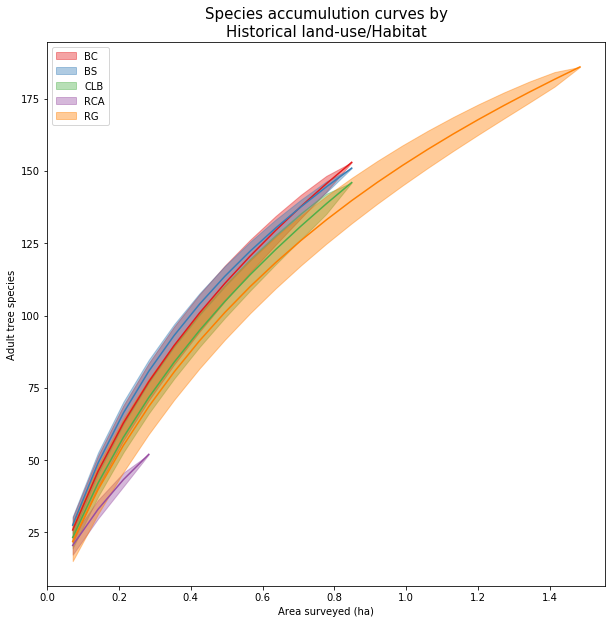

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
plotSACs('BC', ax=ax, xUnits='ha', color='#E41A1C')
plotSACs('BS', ax=ax, xUnits='ha', color='#377EB8')
plotSACs('CLB', ax=ax, xUnits='ha', color='#4DAF4A')
plotSACs('RCA', ax=ax, xUnits='ha', color='#984EA3')
plotSACs('RG', ax=ax, xUnits='ha', color='#FF7F00')
BC_patch = Patch(color='#E41A1C', label='BC', alpha=0.4)
BS_patch = Patch(color='#377EB8', label='BS', alpha=0.4)
CLB_patch = Patch(color='#4DAF4A', label='CLB', alpha=0.4)
RCA_patch = Patch(color='#984EA3', label='RCA', alpha=0.4)
RG_patch = Patch(color='#FF7F00', label='RG', alpha=0.4)
ax.legend(handles=[BC_patch, BS_patch, CLB_patch, RCA_patch, RG_patch])
ax.set_title('Species accumulution curves by\nHistorical land-use/Habitat')
ax.set_xlabel('Area surveyed (ha)')
ax.set_ylabel('Adult tree species')
#plt.savefig("graphics/LandUseSAC.svg")

X-axis is hectares directly sampled. 

[back to top](#contents)

<a id="turnover"></a>
## Tree community turnover (distance decay)

Let's look at community turnover both as a function of simple physical distance, and also as a function of movement over watersheds. Later, in the section after this, we look at community turnover as a function of topographical distance (number of watersheds "hopped"). 

<a id='turnoverPhysical'></a>  
### Turnover by physical distance  

<a id='turnoverHab'></a>
#### Turnover rates by habitat

Let's check turnover rates in community similarity of these various habitat types, as a function of simple physical distance. The turnover rates may be different among the vaious land-use histories.

In [3]:
specObs = pd.read_csv('specObs.csv', index_col='PsubP').sort_index()
envOnly = pd.read_csv('envOnly.csv', index_col='PsubP').sort_index()
subParcelComm = pd.read_csv("subParcelComm.csv", index_col='PsubP')
pts = ((gpd.read_file('GIS/ana30meterPlots.geojson')
        .set_index('PsubP')
        .sort_index())
        )
## sanity check
(pts.index == envOnly.index).all()
(pts.index == subParcelComm.index).all()


True

BC
0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


BS
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CLB
2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RCA
3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RG
4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


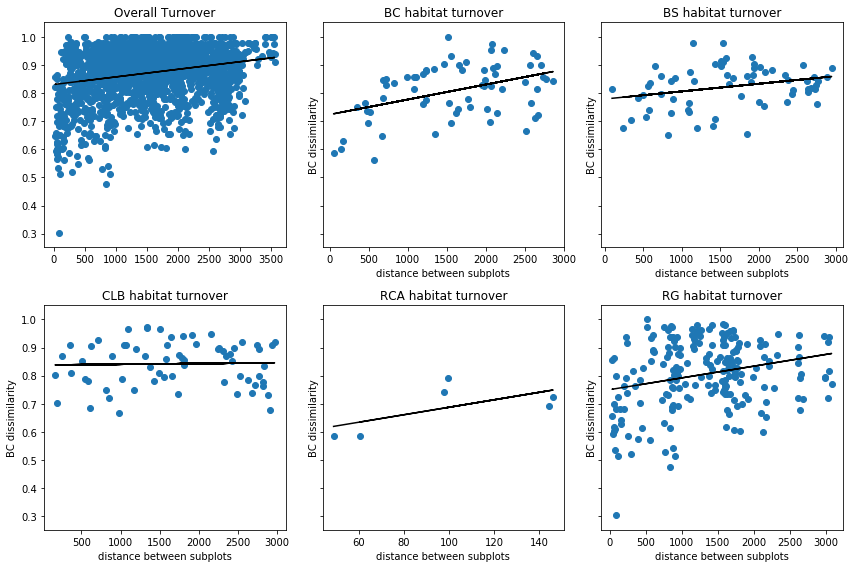

In [64]:
## get our original in there first:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))
axes = axes.flatten()
d = {'X': pts.geometry.x, 'Y': pts.geometry.y}
physDist = sp.distance.pdist(pd.DataFrame(data=d), metric='euclidean')
bcDist = sp.distance.pdist(subParcelComm, metric='brayCurtis')
X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
axes[0].scatter(physDist, bcDist)
axes[0].plot( X, LinearRegression().fit(X, Y).predict(X), c='k')
axes[0].set_title('Overall Turnover')

## now look at these individually:

soGrouped = specObs.groupby('habitat')
habs = list(soGrouped.groups.keys())

for h,i in enumerate(habs):
    print(i)
    print(h)
    obs_i = soGrouped.get_group(i)
    obs_iE = [ pts.loc[float(a)].geometry.x for a in obs_i.PsubP ]
    obs_iN = [ pts.loc[float(a)].geometry.y for a in obs_i.PsubP ]
    obs_i['E'] = obs_iE
    obs_i['N'] = obs_iN
    subParcelInObs_i = subParcelComm.index.isin(obs_i.PsubP)
    comm_i = subParcelComm[subParcelInObs_i]
    notObserved=~((comm_i == 0).all(axis=0).values)
    comm_i = comm_i.iloc[:,notObserved]
    pts_i = pts.loc[comm_i.index.values]
    iX, iY = pts_i.geometry.x.to_list(), pts_i.geometry.y.to_list()
    spDF_i = pd.DataFrame(np.array([iX, iY]).transpose(), columns=['X','Y'])
    physDist_i = sp.distance.pdist(spDF_i, metric='euclidean')
    bcDist_i = sp.distance.pdist(comm_i, metric='brayCurtis')
    axes[h+1].scatter(physDist_i, bcDist_i)
    X, Y = physDist_i.reshape(-1,1), bcDist_i.reshape(-1,1)
    axes[h+1].plot( X, LinearRegression().fit(X, Y).predict(X), c='k')
    axes[h+1].set_xlabel('distance between subplots')
    axes[h+1].set_ylabel('BC dissimilarity')
    axes[h+1].set_title(f'{i} habitat turnover')

plt.tight_layout()

[back to top](#contents)

<a id="turnoverPhysOverall"></a>
#### Overall (all habitats) by physical distance

The slope of the above habitat-specific lines are whatever scikit learn uses for its simple regression, probably lines fit with standard pearson correlation coefficients. The are being forced into a simple linear fit. Given the nature of BC dissimilarity and general patterns of distance decay, a more appropriate deterministic model here might be some sort of asymptotic, Michaelis-Menten-type function:

In [3]:
specObs = pd.read_csv('specObs.csv', index_col='PsubP').sort_index()
envOnly = pd.read_csv('envOnly.csv', index_col='PsubP').sort_index()
subParcelComm = pd.read_csv("subParcelComm.csv", index_col='PsubP')
pts = (gpd.read_file('GIS/ana30meterPlots.geojson')
        .set_index('PsubP')
        .sort_index()
      )
d = {'X': pts.geometry.x, 'Y': pts.geometry.y}
physDist = sp.distance.pdist(pd.DataFrame(data=d), metric='euclidean')
bcDist = sp.distance.pdist(subParcelComm, metric='brayCurtis')
X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)

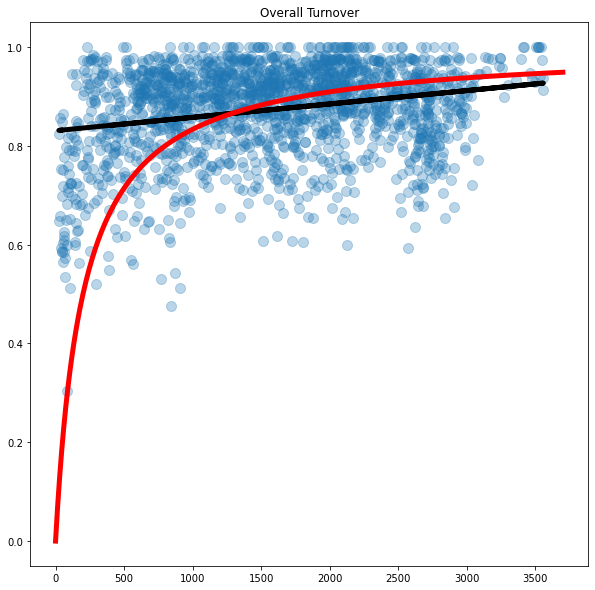

In [4]:
lw=5
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(physDist, bcDist, s=100, alpha=0.3)
ax.plot( X, LinearRegression().fit(X, Y).predict(X), c='k', linewidth=lw)
ax.set_title('Overall Turnover')
## any lines from our function work well here?
x = pd.Series(np.linspace(0,3700,500))
#y = x.apply(lambda x: x/(1+x))
y1 = x.apply(lambda x: x/(200+x))
#ax.plot(x,y, color='orange', linewidth=lw)
ax.plot(x,y1, color='red', linewidth=lw)

The above red line is described by:

$$
  y = \frac{x}{K_{M}+x}, K_{M} = 200  
$$


This is a basic asymptotic function, some folks call it a Michaelis-Menten equation. Given its range between 0 and 1, and its early steep linear phase following by a nearly horizontal asymptote, this is going to be our working deterministic model for patterns in turnover for the moment. We can compare it to a simple linear model (black line). The value $K_{M}$ is the distance at which we reach half of our maximum difference. Our maximum difference is BC = 1. Assuming we start at a theoretical BC=0 at zero distance, this could be considered the distance at which we reach BC=0.5, half of our maximum BC value. This value of $K_{M} = 200$ is a loose visual estimate of the distance it took for most Amazonian forest types to lose half of their similarity in a meta-analysis by [Draper et al. (2019)](https://esajournals.onlinelibrary.wiley.com/doi/abs/10.1002/ecy.2636). This is the most apropriate literature I could find for formulating a prior for $K_{M}$, even though it doesn't look like a perfect fit for our data. We'll us it for our prior, below. The data from Draper is here, figure 4 in their paper:

<img src="draper2019DistanceDecayFig4.png">


Taking a bayesian approach here, we propose that any given value of $x$, the observed data ($y$) is distributed around the above asymptotic function, with the standard deviaton $\epsilon$. 

$$
y \sim N(\mu = \frac{x}{x+K_{M}}, \epsilon )
$$

$\epsilon$ is a little tricky. We can see from our data that the variance $\epsilon$ gets smaller with distance, as all comparisons at large distances probably converge to BC = 1.This makes sense: the communities of trees of two points that are very physically close to each other are more likely to be similar that if we were to sample two points that are far away.  But in the hypervariable topography of the wet Andes, we also hypothesize that nearby comparisons can be extremely variable: there are several examples of nearby points have very different tree communities. We model this with a shrinking variance: initial, nearby comparisons are allowed to very from low to high BC values, but as distance between comparisons increase, the probability that the comparison will result in complete difference (BC=1) is increasingly high. So we model the variance around our asymptote curve, $\epsilon$, as a linear function with a negative slope. According to the helpful folks at PyMC3, we'll exponentiate the whole thing while we're at it, to ensure that all terms are positive, since a negative standard deviation doesn't make sense here (see our discussion [here](https://discourse.pymc.io/t/modeling-noising-parameter-that-decreases-negatively-varying-variance/6728/8)). 

$$
\epsilon = e^{(\delta x + \gamma)}
$$



#### Priors 

As mentioned above, we have some literature around $K_{M}$, we'll use a fairly specific prior centered on 200m.  

$$
K_{M} \sim N(200, \sigma=10)  
$$

The exponentiation makes some of our priors contained in $\epsilon$ a little hard to understand. I think it's better to think about it as a simple linear equation for the moment. In this way, $\gamma$ is a measure of our initial variability: the span of different BC values we get at close distances, when x is near 0. $\delta$ is the rate at which the data tightens to meet the curve of the mean ($\mu$). Together they give the variance the "arrow" shape that we see above, wide near the y-axis and narrowing to converge on the asymptote. 

Since we are taking a bayesian approach, $\epsilon$ has its own set of priors, each its own probability distribution. I'm not aware of any previous literature on this, so we'll give them weakly infomative normal distributions:

$$
\delta \sim N(-0.0006, \sigma=0.005)  
$$
$$
\gamma \sim N(1.5, \sigma=0.5) 
$$

So our model looks like this, using PyMC3:

In [5]:
xx = physDist.copy()
with pm.Model() as model_asymp:
    γ = pm.Normal('γ', mu=-1.5, sigma = 0.5) ## analagous to initial spread of variance (natural log of)
    δ = pm.Normal('δ', mu=-0.0006, sigma=0.005) ## slope, rate of tightening of variance
    κ = pm.Normal('κ', mu=200, sigma = 10) ## same old k
    μ = pm.Deterministic('μ', xx/(xx+κ))
    ε = pm.Deterministic('ε', np.power(np.e, γ + δ*xx))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=bcDist)
    trace_asymp = pm.sample(init='adapt_diag')


WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /home/daniel/.theano/compiledir_Linux-5.4--generic-x86_64-with-debian-bullseye-sid-x86_64-3.7.7-64/tmpmiufmt38/key.pkl
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [κ, δ, γ]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:10<00:00, 186.48draws/s]
The acceptance probability does not match the target. It is 0.8951522509957129, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983804686866088, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


We can look at how our priors have moved with the data:

/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwarg

array([[<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>],
       [<AxesSubplot:title={'center':'δ'}>,
        <AxesSubplot:title={'center':'δ'}>],
       [<AxesSubplot:title={'center':'κ'}>,
        <AxesSubplot:title={'center':'κ'}>]], dtype=object)

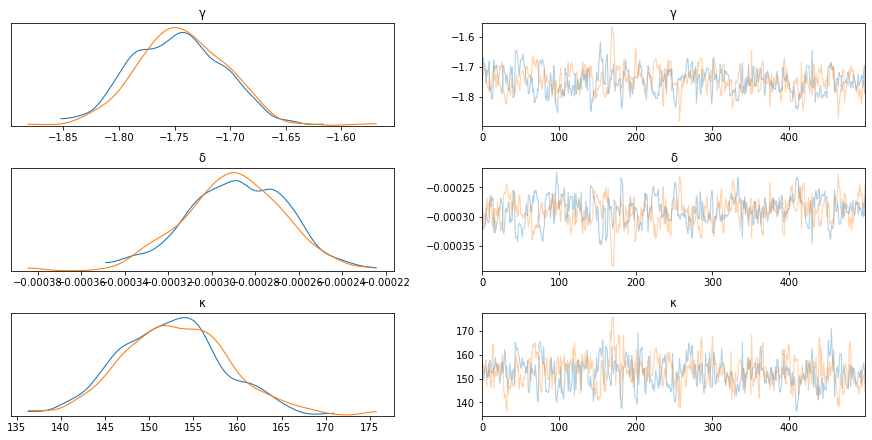

In [6]:
az.plot_trace(trace_asymp, var_names = ['γ','δ','κ'])

In [7]:
##  can we get the standard dev of our posterior? 
az.summary(trace_asymp, var_names=['κ', 'γ','δ'])

mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
κ  152.716  6.012  141.461  163.890      0.378    0.268     254.0   252.0   
γ   -1.746  0.041   -1.816   -1.672      0.003    0.002     227.0   227.0   
δ   -0.000  0.000   -0.000   -0.000      0.000    0.000     215.0   214.0   

   ess_bulk  ess_tail  r_hat  
κ     259.0     285.0   1.01  
γ     228.0     328.0   1.01  
δ     216.0     331.0   1.01

How much did our posterior κ shift from the prior?

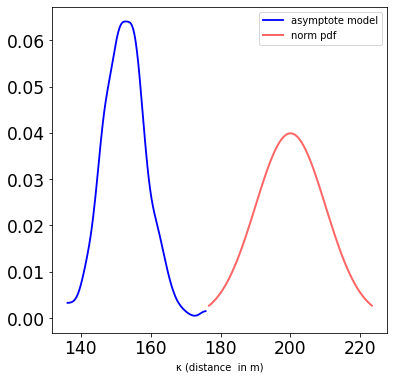

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
az.plot_kde(trace_asymp['κ'], plot_kwargs={'color':'b'}, label='asymptote model', ax=ax)
kapPrior = norm(loc = 200, scale = 10) ## norm from scipy stats
x = np.linspace(kapPrior.ppf(0.01),kapPrior.ppf(0.99), 100)
ax.plot(x, kapPrior.pdf(x),
       'r-', lw=2, alpha=0.6, label='norm pdf')
ax.set_xlabel('κ (distance  in m)')
ax.legend()


And we can see how this new model lays over the data:

In [9]:
## gotta sort it by X for nice plotting
aa = pd.DataFrame({ "μ_m": trace_asymp['μ'].mean(0),
                    "ε_m": trace_asymp['ε'].mean(0),
                    "physDist": physDist,
                    "bcDist": bcDist})
asympSum = aa.sort_values(by=['physDist'])

Setting up our posterior predictive check:

In [10]:
asymp_pp = pm.sample_posterior_predictive(trace_asymp, samples=2000, model=model_asymp)

100%|██████████| 2000/2000 [00:03<00:00, 511.92it/s]


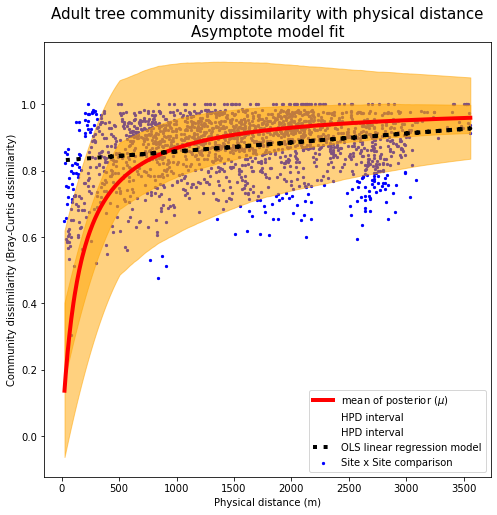

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(asympSum.physDist, asympSum.bcDist, c='b', s=5, label='Site x Site comparison')
ax.plot(asympSum.physDist,
        asympSum.μ_m,
        c='r',
        linestyle= "solid",
        linewidth=4,
        label=(f"mean of posterior ($\mu$)"),
       )

az.plot_hpd(physDist, asymp_pp['y_pred'], 
            credible_interval=0.5, 
            color='orange', 
            ax=ax,
            plot_kwargs={'label':'HPD interval'},
           )
az.plot_hpd(physDist, asymp_pp['y_pred'],  
            credible_interval=0.95, 
            color='orange', 
            ax=ax)
X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
ax.plot( X, LinearRegression().fit(X, Y).predict(X), 
        c='k', linewidth=4, linestyle= "dotted",
        label='OLS linear regression model'
       )
ax.set_title('Adult tree community dissimilarity with physical distance\nAsymptote model fit')
ax.set_xlabel('Physical distance (m)')
ax.set_ylabel('Community dissimilarity (Bray-Curtis dissimilarity)')
ax.legend(loc='lower right')
#plt.savefig("graphics/asymptoteFit.svg")

This shows our model fit using 0.5 and 0.94 credible intervals (sort of like a confidence interval). 

We can do a bayesian-style R2 test here:

In [12]:
az.r2_score(bcDist, asymp_pp['y_pred'])

r2        0.534634
r2_std    0.112553
dtype: float64

A bayesian R2 is similar in concept to the frequentist-OLS version, both take ratios of variance observed and variance predicted by the model, but I think the mathematical details of how this is achieved are slightly different. So I'm not sure how comparable they are, but it is informative to show the "normal" R2 of the simple linear model.

In [13]:
X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
LinearRegression().fit(X, Y).score(X, Y)

0.05653886091363247

We have to use the scipy stats module to check significance of the linear model: 

In [26]:
stats.linregress(physDist,bcDist)

LinregressResult(slope=2.706059854121662e-05, intercept=0.8304501501149278, rvalue=0.23777901697507361, pvalue=6.146052243597948e-25, stderr=2.5854597644659636e-06)

This very simple linear model is highly statistically significant but doesn't capture a ton of the variance. We capture much more with the asymptotic model. But it's not really a fair comparison, the frequentist model hasn't been told about the unusual shape of the errors/variance, which is definitely not bivariate-normal. To really make a deeper comparison of the two, we'd have to construct a fully bayesian model of the simple linear regression, and take some time modeling the variances. Knowing that very close sites must have BC~0, the asymptote model makes a lot of sense, conceptually, but... 

Even though forcing the mean of our BC dissimilarity ($\mu$) through the origin is theoretically satisfying, it doesn't completely fit the data. Remember, we're trying to model two processes - (1) the variability inherent in samples taken nearby but in very different micro-environments, and (2) the classic pattern of distance-decay in similarity. We could let the variance handle process #1, and let $\mu$ handle process #2, so-to-speak. Thus instead of forcing $\mu$ at close comparisons to approach zero, we can let the variance be very wide at short distances, accepting zeroes or even BC=1. This lets the mean "relax", we can describe it instead in a simple linear way. Additionally, we can use a skewed normal distribution to describe the "curtain" effect we see with the variance, where many of our points are clumped high around BC~0.85, with a long skew towards BC=0. This may be a more elegant way to describe the situation. 

So another model...

$$ y \sim skewNormal(\alpha + \beta x, \epsilon, A)$$ 
$$\epsilon = e^{(\delta x + \gamma)}$$
$$
A \sim N(\mu=-2.0, \sigma = 0.5)
$$ 

$$
\alpha \sim N(\mu=0.9, \sigma=0.2)  
$$
$$
\beta \sim N(\mu=0.0001, \sigma = 0.00001)
$$


$$
\delta \sim N(-0.0006, \sigma=0.005)  
$$
$$
\gamma \sim N(-1.5, \sigma=0.5) 
$$

A is a skewness factor, making it negative pulls the long tail of a normal distribution towards more negative values. In our case, that means an assymetric distribution, with a long tail of the BC values towards lower values, even while most BC values are actually centered high around the mean of ~.85 or so. 

In [32]:
xx = physDist.copy()
with pm.Model() as model_linSkew:
    a = pm.Normal('a', mu=-2.0, sigma = 0.5) ## skewness parameter
    γ = pm.Normal('γ', mu=-1.5, sigma = 0.5) ## analagous to initial spread of variance (natural log of)
    δ = pm.Normal('δ', mu=-0.0006, sigma=0.005) ## slope, rate of tightening of variance
    α = pm.Normal('α', mu=0.9, sigma=0.2) ## intercept of mu,
    β = pm.Normal('β', mu=0.0001, sigma = 0.00001) ## slope of mu
    μ = pm.Deterministic('μ', α + β*xx )
    ε = pm.Deterministic('ε', np.power(np.e, γ + δ*xx))
    y_pred = pm.SkewNormal('y_pred', mu=μ, sd=ε, alpha=a, observed=bcDist)
    trace_linSkew = pm.sample(init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, δ, γ, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:22<00:00, 87.92draws/s] 
The acceptance probability does not match the target. It is 0.9131844991912532, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9003553306902038, but should be close to 0.8. Try to increase the number of tuning steps.


/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwarg

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>],
       [<AxesSubplot:title={'center':'δ'}>,
        <AxesSubplot:title={'center':'δ'}>],
       [<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>]], dtype=object)

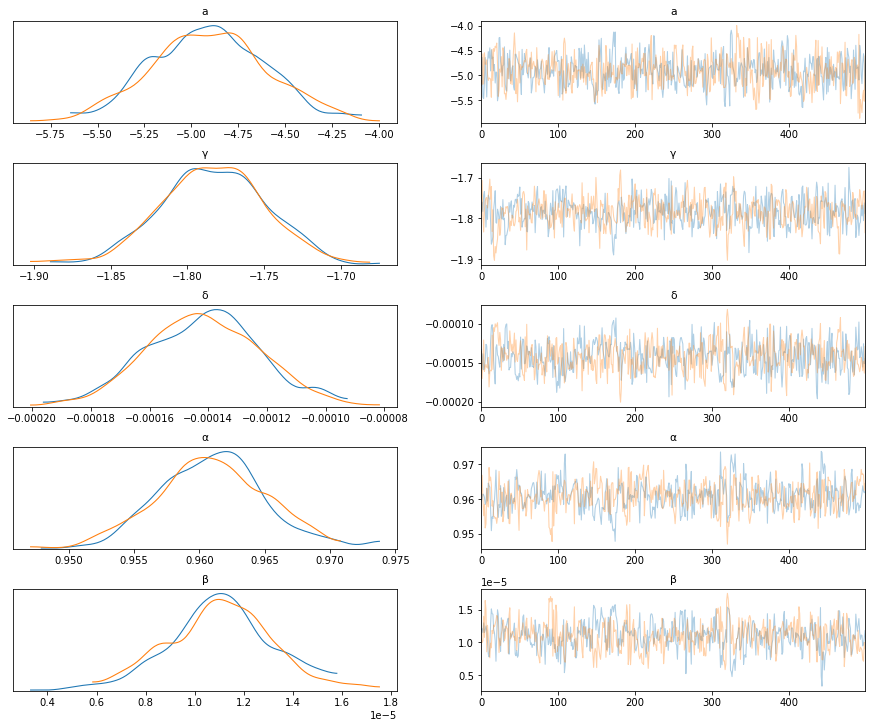

In [33]:
az.plot_trace(trace_linSkew, var_names = ['a','γ','δ','α','β'])

How's the fit? Visual inspection is promising:

In [34]:
## make dataframe for nice plotting:
# gotta sort it by X for nice plotting
aa = pd.DataFrame({ "μ_m": trace_linSkew['μ'].mean(0),
                    "ε_m": trace_linSkew['ε'].mean(0),
                    "physDist": physDist,
                    "bcDist": bcDist})
linSkewSum = aa.sort_values(by=['physDist'])
## mu isn't our mean anymore, with the skew
## to get the mean:
def getSkewMean(mu,ee,alpha):
    mean = mu + ee * (2/np.pi)**(1/2) * alpha/((1+alpha**2)**(1/2))
    return(mean)
linSkewSum['skewMean'] = linSkewSum.apply(lambda x: getSkewMean(mu=x['μ_m'].item(),
                                           ee=x['ε_m'].item(),
                                           alpha=trace_linSkew['a'].mean()),
                        axis=1)

In [35]:
linSkew_pp = pm.sample_posterior_predictive(trace_linSkew, samples=2000, model=model_linSkew)

100%|██████████| 2000/2000 [00:04<00:00, 448.64it/s]


In [36]:
linSkewSum

μ_m       ε_m     physDist    bcDist  skewMean
1530  0.961159  0.167475    24.186773  0.647059  0.830223
1200  0.961173  0.167444    25.495098  0.822785  0.830262
1824  0.961213  0.167359    29.068884  0.857143  0.830368
1829  0.961277  0.167219    34.928498  0.658120  0.830542
1785  0.961321  0.167124    38.897301  0.752212  0.830660
...        ...       ...          ...       ...       ...
332   0.999870  0.101761  3536.806045  0.942029  0.920311
443   0.999918  0.101698  3541.193161  1.000000  0.920409
491   0.999954  0.101652  3544.379776  0.972973  0.920480
336   1.000098  0.101464  3557.510365  0.912088  0.920772
495   1.000102  0.101459  3557.840497  0.937500  0.920779

[1830 rows x 5 columns]

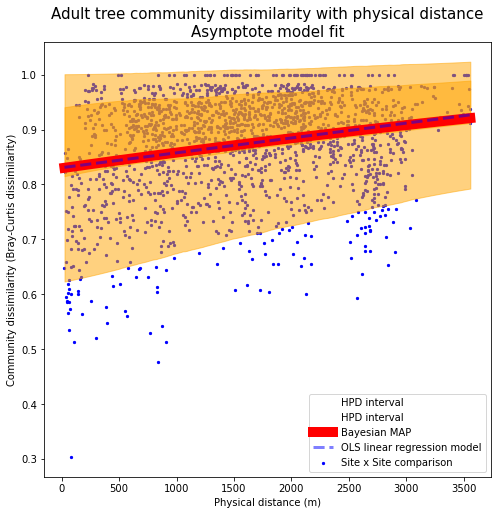

In [50]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(linSkewSum.physDist, linSkewSum.bcDist, 
           c='b', s=5, label='Site x Site comparison')
az.plot_hpd(physDist, linSkew_pp['y_pred'], credible_interval=0.5, 
            color='orange', ax=ax,
            plot_kwargs={'label':'HPD interval'},)
az.plot_hpd(physDist, linSkew_pp['y_pred'], credible_interval=0.95,
            color='orange', ax=ax)
ax.plot(linSkewSum['physDist'], linSkewSum['skewMean'], 'r', lw=10,
       label='Bayesian MAP')
X = linSkewSum['physDist'].to_numpy().reshape(-1,1)
Y = linSkewSum['bcDist'].to_numpy().reshape(-1,1)
ax.plot( X, LinearRegression().fit(X, Y).predict(X),
        c='b', ls="--", linewidth=3, alpha=0.5,
       label='OLS linear regression model')
ax.set_title('Adult tree community dissimilarity with physical distance\nAsymptote model fit')
ax.set_xlabel('Physical distance (m)')
ax.set_ylabel('Community dissimilarity (Bray-Curtis dissimilarity)')
ax.legend(loc='lower right')
#plt.savefig("graphics/linearFit.svg")

But the R2 not so good:

In [29]:
az.r2_score(bcDist, linSkew_pp['y_pred'])

r2        0.060790
r2_std    0.013261
dtype: float64

Why? The eyeball test favors the linear model...not sure if the az.r2_score function works well for non-linear. To do some comparisons...

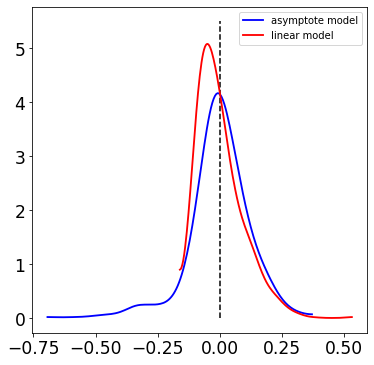

In [80]:
asympPredMean = asymp_pp['y_pred'].mean(axis=0)
linPredMean = linSkew_pp['y_pred'].mean(axis=0)

## plot the dists of the difference:
aa = asympPredMean - bcDist
bb = linPredMean - bcDist

fig, ax = plt.subplots(figsize=(6,6))
az.plot_kde(aa, plot_kwargs={'color':'b'}, label='asymptote model', ax=ax)
az.plot_kde(bb, plot_kwargs={'color':'r'}, label='linear model', ax=ax)
ax.vlines(0,0,5.5,linestyles='dashed', color='k', label='Observed value')


The dotted, black line represents the <i>observed</i> Bray-Curtis dissimilarity, at any given point. The distributions represent the abundances of <i>predicted</i> BC dissimilarity at certain distances from their corresponding observed BC distance, for both models (asymptote and linear).

In an unbiased posterior, it should be symmetric around the vertical zero-line. The asymptote (blue) is this, the linear model (red) is not. The linear model tends to underestimate BC distance compared to the observed. 

In [84]:
print("Asymptote model p-value = " + str(sum(asympPredMean > bcDist) / len(bcDist)))
print("Linear model p-value = " + str(sum(linPredMean > bcDist) / len(bcDist)))

Asymptote model p-value = 0.4896174863387978
Linear model p-value = 0.4158469945355191


These are bayesian p-values, they should approach 0.50 if the posterior is balanced. Not sure we need to pick a favorite here, these quick checks indicate the asymptote function is performing a little more accurately than the simple linear. 

[back to top](#contents)

<a id='turnoverMicrocuenca'></a>  
#### Turnover by watershed crossings 

Now we'll check the turnover using subwatersheds ('microcuencas') as our unit of distances. I often hear discussion around the idea that each watershed in the tropical Andes is very different from the ones next to it, though I haven't seen a lot of quantitative measurement of this idea. So here we examine this idea using subwatersheds of the Rio Los Cedros (and to a lesser degree the Rio Magdalena Chico). We defined these below, in the [Watershed delineations](#watersheds) section. Now we can try to fit some models to the patterns in community similarity among watersheds. 

In [3]:
## scipy makes it easy for the BC distance
bcDist = sp.distance.pdist(subParcelComm, metric='brayCurtis')

## to match this, so we need the upper triangle of our physical
## distance matrix:
psubpHopsNP = np.array(psubpHopsDF)
psubpHopsTriU = psubpHopsNP[np.triu_indices(psubpHopsNP.shape[0], k=1)]

## make the model from these two dist matrices
## I guess we can just make a model from these:

X, Y = psubpHopsTriU.reshape(-1,1), bcDist.reshape(-1,1)

Text(0.5, 1.0, 'Overall Microcuenca Turnover')

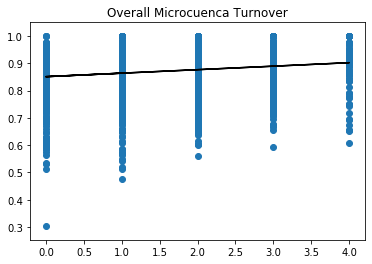

In [4]:
fig, ax = plt.subplots()
ax.scatter(psubpHopsTriU, bcDist)
ax.plot( X, LinearRegression().fit(X, Y).predict(X), c='k')
ax.set_title('Overall Microcuenca Turnover')

We can do better than that.

[0.8202427173225738,
 0.8803880579382168,
 0.8718442882110651,
 0.8910368558226932,
 0.881123053179186]

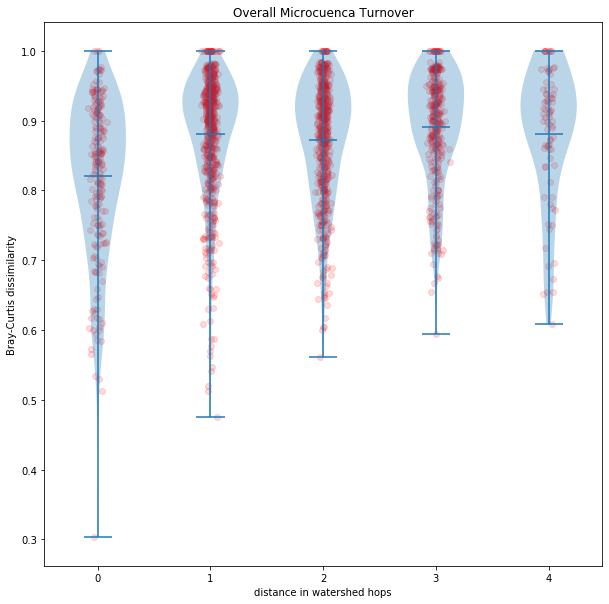

In [5]:
XS, YS = pd.Series(psubpHopsTriU), pd.Series(bcDist)
grouped = [ YS[XS == i].to_list() for i in np.unique(psubpHopsTriU) ]
fig, ax = plt.subplots(figsize=(10,10))
## that works...add points?
XSjitted = (XS
            .apply(np.random.normal, args=(0.03,))
            .apply( lambda x: x+1)
            )
ax.scatter(XSjitted, YS, alpha=0.15, color='red')
ax.violinplot(grouped, showmeans=True)
_=ax.set_xticklabels(['',0,1,2,3,4])
ax.set_title('Overall Microcuenca Turnover')
ax.set_ylabel('Bray-Curtis dissimilarity')
ax.set_xlabel('distance in watershed hops')
[ np.mean(i) for i in grouped ]

In [10]:
pd.DataFrame({
"meanBC": [ np.mean(i) for i in grouped ],
"stdDevBC": [ np.std(i) for i in grouped ],
"n": [ len(i) for i in grouped ]
})


meanBC  stdDevBC    n
0  0.820243  0.113795  215
1  0.880388  0.089043  630
2  0.871844  0.085271  559
3  0.891037  0.079448  346
4  0.881123  0.095578   80

Well, that is kind of interesting. How to read this, I think: within a single watershed, lots of variation, all things are possible: some sites are very different from each other, with very few shared species, and some are nearly identical. As soon as you compare sites that are at least one microcuenca away, you see a jump in mean dissimilarity, but after that (hopping further watersheds) you see no further increase in mean dissimilarity, and you have less variation. Making one microcuenca jump generally puts you into a community that is as different as going 4 microcuencas away. So the Los Cedros ecosystem really does bear out the general perception that in the tropical andes, every watershed is different.

Checking for differences among these different classes of comparisons, using an old-fashioned, frequentist ANOVA:

In [6]:
wat0, wat1, wat2, wat3, wat4 = grouped
stats.f_oneway(wat0, wat1, wat2, wat3, wat4)

F_onewayResult(statistic=23.225608155982908, pvalue=9.513202964937219e-19)

A non-parametric alternative might be more appropriate here, because those groups aren't exactly text-book normal:

In [7]:
stats.kruskal(wat0, wat1, wat2, wat3, wat4)

KruskalResult(statistic=73.26663274360287, pvalue=4.633672521608464e-15)

Either way, the model seems statistically significant, in the frequentist sense.

In [8]:
tukey = pairwise_tukeyhsd(endog = YS, groups=XS, alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0601  0.001  0.0408 0.0795   True
     0      2   0.0516  0.001  0.0319 0.0713   True
     0      3   0.0708  0.001  0.0495 0.0921   True
     0      4   0.0609  0.001  0.0287  0.093   True
     1      2  -0.0085 0.4759 -0.0228 0.0057  False
     1      3   0.0106  0.393 -0.0058 0.0271  False
     1      4   0.0007    0.9 -0.0284 0.0299  False
     2      3   0.0192 0.0158  0.0024  0.036   True
     2      4   0.0093    0.9 -0.0201 0.0386  False
     3      4  -0.0099    0.9 -0.0404 0.0205  False
---------------------------------------------------


Yup, the 0 group, which are the within-the-same-watershed comparisons. This group is clearly different from all the others. The only other supposedly statistically significant difference is between groups 2 and 3. But that is a pretty small effect size.

When we leave out our first group, what is the mean BC of all the other distance classes?:

In [17]:
ungrouped = sum(grouped[1:], [])
print("mean BC dist all distance classes besides 0 = " + str(np.mean(ungrouped))
     + " +/-" + str(np.std(ungrouped)))


mean BC dist all distance classes besides 0 = 0.8797486253746432 +/-0.08639234875115506


Does the pattern bear out among our various different land types?:

In [25]:
def violinTurnPlot(physDist, ecoDist, ax, tit=None):
    XS, YS = pd.Series(physDist), pd.Series(ecoDist)
    grouped = [ YS[XS == i].to_list() for i in np.unique(physDist) ]
    ## that works...add points?
    XSjitted = (XS
                .apply(np.random.normal, args=(0.03,))
                .apply( lambda x: x+1)
                )
    ax.scatter(XSjitted, YS, alpha=0.25, color='red')
    ax.violinplot(grouped, showmeans=True)
    _=ax.set_xticklabels(['',0,1,2,3,4])
    ax.set_title(tit)

/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: 

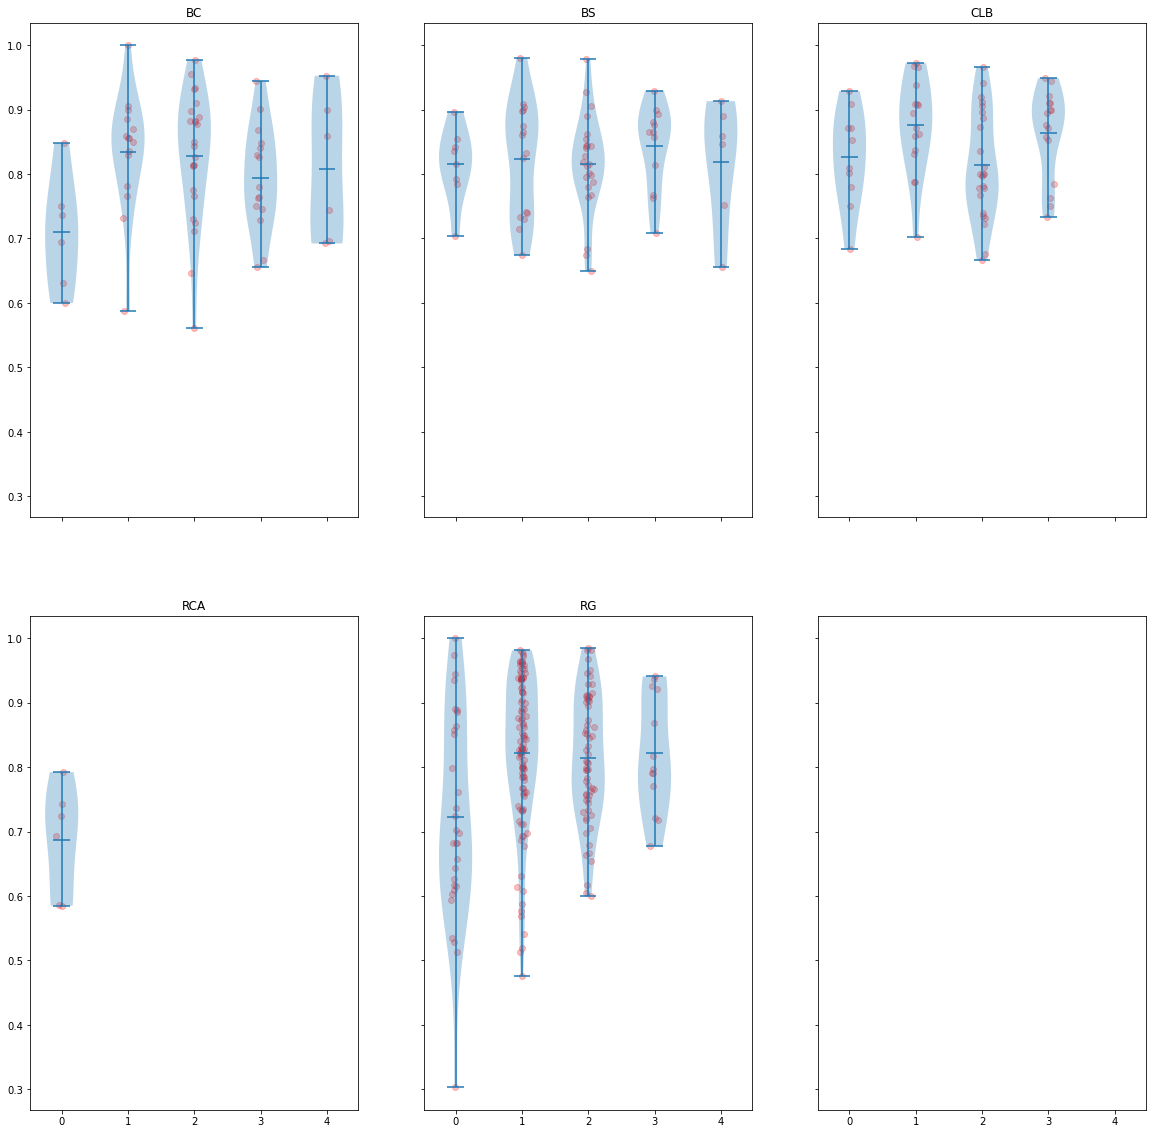

In [26]:
## make a dictionary, keys are habitat types and values are lists of PsubP sample names
habGroups = envOnly.groupby('habitat')
psubpHopsTriU_byHab = []
bcDist_byHab = []
fig, axes = plt.subplots(2,3, sharey=True, sharex=True, figsize=(20,20) )
axes = axes.flatten()

for nu,i in enumerate(habGroups.groups.keys()):
    ## physical distance
    psubpHopsDF_i = psubpHopsDF.loc[ habGroups.groups[i], habGroups.groups[i].astype('str') ]
    psubpHopsNP_i = np.array(psubpHopsDF_i)
    psubpHopsTriU_i = psubpHopsNP_i[np.triu_indices(psubpHopsNP_i.shape[0], k=1)]
    psubpHopsTriU_byHab.append(psubpHopsTriU_i)
    ## bc distance
    subParcelComm_i = subParcelComm.loc[ habGroups.groups[i] ]
    bcDist_i = sp.distance.pdist(subParcelComm_i, metric='brayCurtis')
    bcDist_byHab.append(bcDist_i)
    violinTurnPlot(physDist=psubpHopsTriU_i,
                ecoDist=bcDist_i,
                ax=axes[nu],
                tit=i,
                    )

That's kind of interesting. It looks like the BS and CLB plots don't really show the same pattern, it is the BC and RG plots that are driving the lower-mean-BC-within-watershed trend we see overall. I would guess that the gap-pioneering species that thrive in natural forest gaps cause a sort of homogenizing effect here. When a gap happens anywhere in the forest, there is probably a smaller subset of plants that come in quick and thrive, over-riding the general trend of increasing dissimilarity with distance. That's my hand-waving on this.    

<a id='NMS'></a>
### Ordination by habitat

Let's see how these habitats separate out, if at all. We'll need to do this in R.

In [1]:
library(vegan)
library(RColorBrewer)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



In [2]:
subParcelComm <- read.csv('subParcelComm.csv', header=TRUE)
sPC <- subParcelComm[,-1]
rownames(sPC) <- subParcelComm[,1]

In [3]:
nms <- metaMDS(sPC, try=40)

Wisconsin double standardization
Run 0 stress 0.2882666 
Run 1 stress 0.3216495 
Run 2 stress 0.2883821 
... Procrustes: rmse 0.005636937  max resid 0.03006653 
Run 3 stress 0.2882521 
... New best solution
... Procrustes: rmse 0.01314296  max resid 0.04731789 
Run 4 stress 0.2906081 
Run 5 stress 0.2938792 
Run 6 stress 0.2905561 
Run 7 stress 0.2883771 
... Procrustes: rmse 0.01372514  max resid 0.05214392 
Run 8 stress 0.2964639 
Run 9 stress 0.2933653 
Run 10 stress 0.2941631 
Run 11 stress 0.2898031 
Run 12 stress 0.2909333 
Run 13 stress 0.2883069 
... Procrustes: rmse 0.01106558  max resid 0.04747663 
Run 14 stress 0.2916228 
Run 15 stress 0.2926481 
Run 16 stress 0.2909598 
Run 17 stress 0.2921912 
Run 18 stress 0.3131698 
Run 19 stress 0.2891772 
Run 20 stress 0.2883384 
... Procrustes: rmse 0.007643895  max resid 0.04849648 
Run 21 stress 0.2905898 
Run 22 stress 0.2897859 
Run 23 stress 0.2908171 
Run 24 stress 0.2923052 
Run 25 stress 0.2925536 
Run 26 stress 0.2897087 
Run

In [5]:
#save(nms, file='fullCommNMS.rda')
#load('fullCommNMS.rda')

Stresses look high...check them out a little more closely:

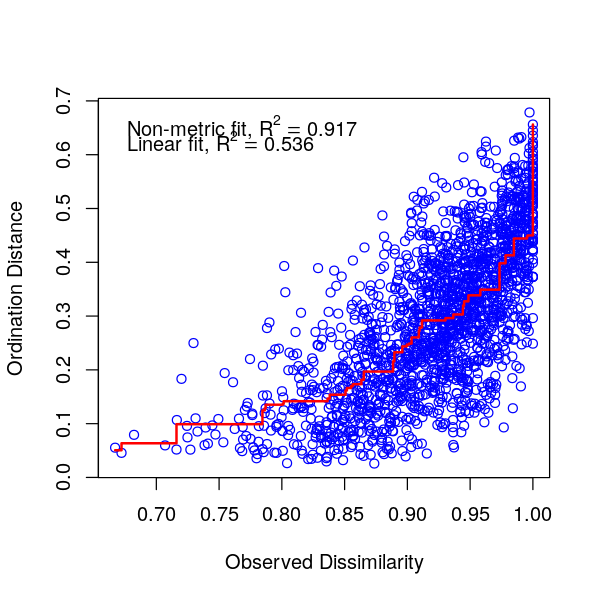

In [4]:
options(repr.plot.width=5, repr.plot.height=5)
stressplot(nms)


Not great, but might be useful. Most of the solutions are under 0.3 linear stress...let's look at the one that was saved:

In [6]:
specObs <- read.csv('specObs.csv')
aa = specObs[c("PsubP","habitat")]
colrs <- brewer.pal(5, "Set1")
nondups <- aa[!duplicated(aa),]
nondups <- nondups[order(nondups$PsubP),]
rownames(nondups) <- NULL
nondups$colorNu <- as.numeric(nondups$habitat)
nondups$colrs <- colrs[nondups$colorNu]
nondups$MDS1 <- nms$points[,'MDS1']
nondups$MDS2 <- nms$points[,'MDS2']
nmsInfo <- nondups

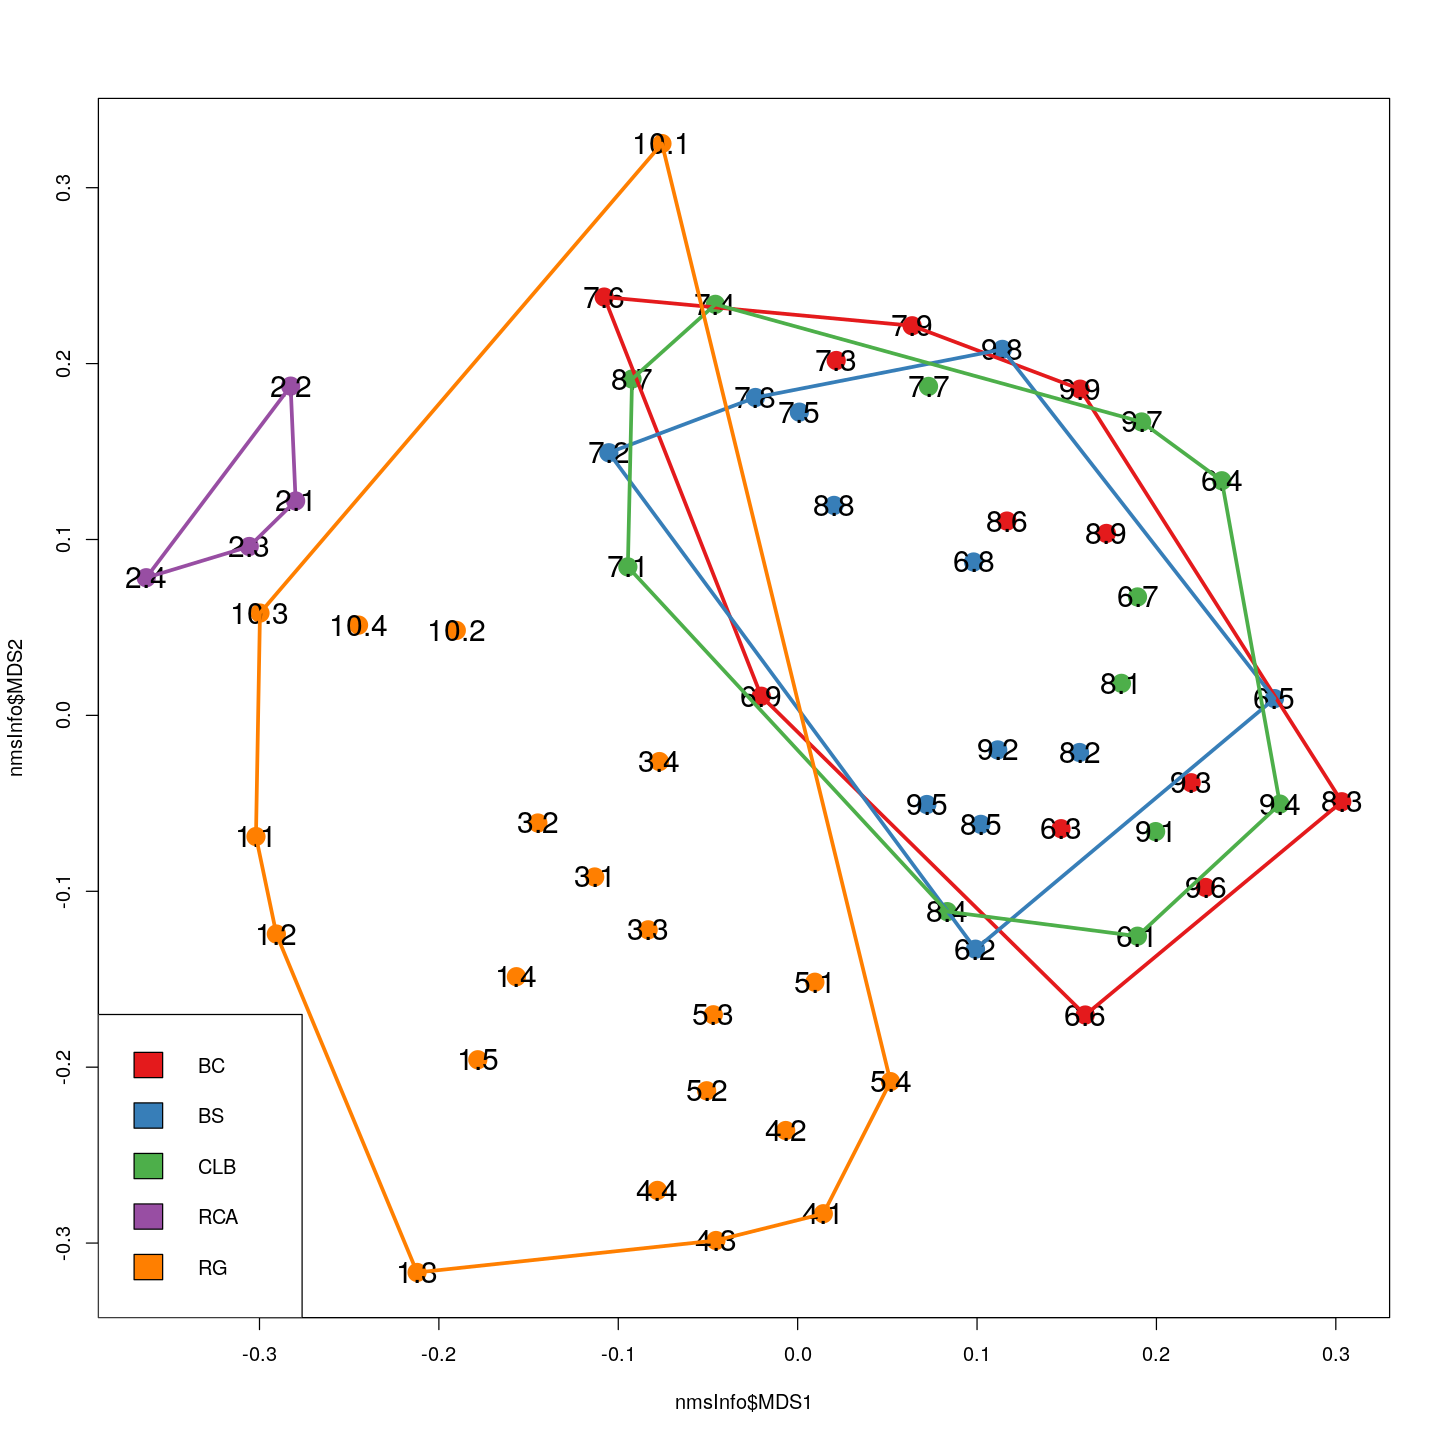

In [7]:
options(repr.plot.width=12, repr.plot.height=12)
plot(nmsInfo$MDS1, nmsInfo$MDS2,
    col=nmsInfo$colrs,
    pch=19,
    cex=2.0,
)
text(nmsInfo$MDS1, nmsInfo$MDS2, nmsInfo$PsubP, cex=1.5)
## add a legend
legend( x='bottomleft',
        legend = c('BC', 'BS', 'CLB', 'RCA', 'RG'),
        fill = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        col = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        cex = 1.0,
        )
ordihull(nms, nmsInfo$habitat, col=c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'), lwd=3)


<a id="habNMS"></a>
BC - Bosque cerrado  
BS - Bosque secundario  
CLB - Claro de bosque  
RG - regeneración fincas agricultura ganadería  
RCA - Regeneración cañaveral  

Huh, the forest sites are not really distinguishable here, the intensively farmed sites ("RCA") are clearly on their own, and the potrero regen sites are intermediate. 

Compare this to our clustering results, [below](#clustNMS).

[back to top](#contents)

<a id="DEM"></a>

### Generate environmental data from DEM

We can get a bit more information using a digital elevation model (DEM) for the area. I used a raster from the [ASTER GDEM2 project](https://asterweb.jpl.nasa.gov/gdem.asp) to generate slope and aspect data for each subparcel site. This is the topography map that is the background for the [physical map](#DEMmap) below, The DEM was clipped to roughly the bounding box of Los Cedros, and I used the in-house tools in QGIS (QGIS v3.4.11-Madeira, OSGEO v3.7.1) to generate slope and aspect data (`Processing >>> Toolbox >>> Raster terrain analysis >>> Aspect / Slope`). We'll use the [Rasterio package](https://github.com/mapbox/rasterio) in python to take a look at these, which is basically a nice wrapper for gdal tools for rasters.

The slope and aspect maps look like this:

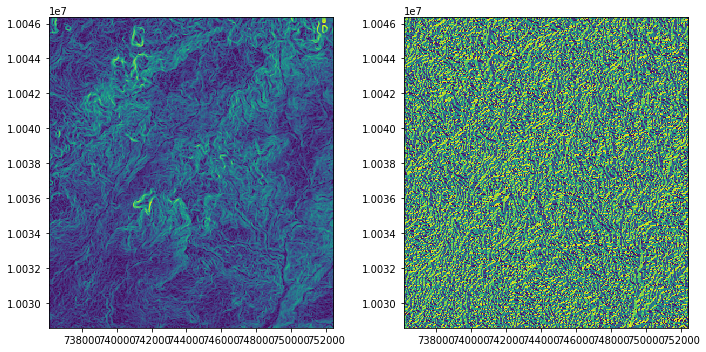

In [73]:
slopeRast = rasterio.open("GIS/lcSlope.tif")
aspectRast = rasterio.open("GIS/lcAspect.tif")
__, axes = plt.subplots(1,2, figsize=(10,5))
rasterio.plot.show(slopeRast, ax=axes[0])
rasterio.plot.show(aspectRast, ax=axes[1])
plt.tight_layout()

<a id='slope'></a>
#### Slope (and a note about GPS vs. DEM elevation data)

The z value on this map is slope in degrees, I believe. We can extract the z value for the pixels where we have subplots.

In [18]:
## get geopanda of subparcel points:
pts = gpd.read_file('GIS/ana30meterPlots.geojson')
pts.set_index('PsubP', inplace=True)
pts.sort_index(inplace=True)

## add the elevation as measured from the GPS's, in ana's excel sheets:
envOnly = pd.read_csv('envOnly.csv')
envOnly.set_index('PsubP', inplace=True)
envOnly.sort_index(inplace=True)

(pts.index == envOnly.index).all()

True

In [20]:
## get rasters
slopeRast = rasterio.open("GIS/lcSlope.tif")
aspectRast = rasterio.open("GIS/lcAspect.tif")

Our function for grabbing Z values from rasters:

In [19]:
## function for grabbing z values from rasters
def getZ(xx,yy,robj):
    robjR = robj.read(1)
    rc = robj.index(xx,yy)
    return(robjR[rc])

Get slope for all of our points, and add this to our environmental dataframe. We'll also get our predictions for the elevation of a site by the DEM, to compare with the GPS data from Ana's study. 

In [24]:
## slope
envOnly['slope'] = [ getZ(i.x, i.y, slopeRast) for i in pts.geometry ]
## add DEM-predictions of elevation
envOnly['DEM'] = [ getZ(i.x, i.y, dem) for i in pts.geometry ]

## take a look
envOnly.head(10)

elevacion habitat      slope   DEM
PsubP                                    
1.1         1413      RG  21.501858  1325
1.2         1398      RG  15.726591  1411
1.3         1380      RG  28.038858  1411
1.4         1370      RG   9.895795  1429
1.5         1362      RG   3.489236  1428
2.1         1189     RCA  25.335262  1232
2.2         1200     RCA  20.097029  1200
2.3         1201     RCA  29.561605  1231
2.4         1226     RCA  28.344837  1251
3.1         1430      RG  33.679825  1409

Just curious, how well do our values from the GPS and the DEM line up?

Text(0, 0.5, 'DEM Elevation')

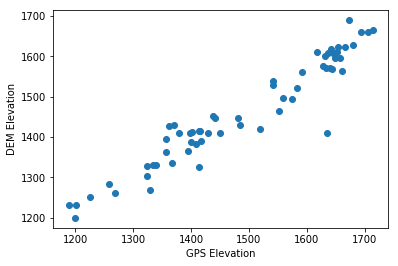

In [25]:
aa = plt.scatter(envOnly['elevacion'], envOnly['DEM'])
plt.gca().set_xlabel('GPS Elevation')
plt.gca().set_ylabel('DEM Elevation')

Well, not a perfect fit, but pretty good. Seems like the GPS usually estimates a little higher than the DEM. Anyway...

<a id='aspect'></a>
#### Aspect

Aspect is a little trickier. We can extract it from the aspect raster in the same way:

In [28]:
aspectRast = rasterio.open("GIS/lcAspect.tif")
envOnly['aspect'] = [ getZ(i.x, i.y, aspectRast) for i in pts.geometry ]

But then we have to process it a bit. The reason for this is that aspect is non-linear, north is approached from two very different maxima, 0 and 360 degrees. Thus two values that appear maximally different (say, 10° and 350°) are actually very close in their aspect. So we'll separate it into northern exposure and eastern exposure. These will be the sine and cosine of our compass heading, after a bit of conversion. This will give us values ranging from -1 to 1 for both eastern exposure and northern exposure. A value of 1 for eastern exposure means the plot is facing purely to the east, etc.

The conversion: since compass values start at north (0°/360° compass bearing) and increase as they move clockwise. In contrast, traditional mathematical functions measure angles as they differ from the x-axis (east, or 90° compass-bearing axis), and the angle increases as it diverges counter-clockwise, the opposite of compass bearings. To use existing sine/cosine functions, we'll have to do these conversions on the aspect data.

So our conversion will be `θ = -(compassBearing - 90)`, along with a conversion to radians for the math package. The we decompose this into two variables, eastern exposure and northern exposure:

In [32]:
angles = [ -(H - 90) for H in envOnly['aspect'] ]

## then get the cos (southern exposure) and sin (northern exposure) 

envOnly['exposeE'] = [ math.cos(math.radians(i)) for i in angles ]
envOnly['exposeN'] = [ math.sin(math.radians(i)) for i in angles ]


So now our data looks like this:

In [33]:
envOnly.head(30)

elevacion habitat      slope   DEM      aspect   exposeE   exposeN
PsubP                                                                    
1.1         1413      RG  21.501858  1325   73.622154  0.959423  0.281971
1.2         1398      RG  15.726591  1411  228.535767 -0.749369 -0.662152
1.3         1380      RG  28.038858  1411   72.854744  0.955560  0.294795
1.4         1370      RG   9.895795  1429   55.796314  0.827044  0.562137
1.5         1362      RG   3.489236  1428   78.269325  0.979114  0.203312
2.1         1189     RCA  25.335262  1232  130.563461  0.759686 -0.650290
2.2         1200     RCA  20.097029  1200  274.145081 -0.997384  0.072282
2.3         1201     RCA  29.561605  1231  305.870209 -0.810346  0.585951
2.4         1226     RCA  28.344837  1251   98.652718  0.988618 -0.150445
3.1         1430      RG  33.679825  1409   25.575079  0.431693  0.902020
3.2         1442      RG  20.447325  1447  324.948792 -0.574308  0.818639
3.3         1438      RG  23.669817  1452  285.371063 -0.964229  0.265069
3.4         1450      RG  18.699421  1410  133.755066  0.722303 -0.691577
4.1         1541      RG  22.704943  1530  140.849365  0.631361 -0.775489
4.2         1575      RG  19.484833  1494  153.809738  0.441353 -0.897333
4.3         1618      RG   7.898471  1611  241.658875 -0.880137 -0.474720
4.4         1634      RG  22.641550  1410  125.549004  0.813619 -0.581399
5.1         1673      RG  17.411152  1689  220.381958 -0.647880 -0.761742
5.2         1714      RG  27.166887  1664  194.715195 -0.254014 -0.967200
5.3         1706      RG  35.275925  1660  191.847366 -0.205305 -0.978698
5.4         1694      RG  38.370384  1661  267.896149 -0.999326 -0.036711
6.1         1640     CLB  36.230225  1572  104.296150  0.969032 -0.246934
6.2         1631      BS  35.210972  1601  218.385025 -0.620943 -0.783856
6.3         1652      BC  37.451431  1611  263.720276 -0.994000 -0.109383
6.4         1657     CLB  27.563299  1595  261.681122 -0.989478 -0.144682
6.5         1661      BS  30.894480  1564   75.021034  0.966021  0.258464
6.6         1643      BC  38.851753  1568   60.417732  0.869648  0.493673
6.7         1558     CLB  30.231808  1497   96.977425  0.992594 -0.121478
6.8         1552      BS  26.354826  1465  321.107330 -0.627863  0.778323
6.9         1627      BC  33.497627  1577  231.421204 -0.781751 -0.623590

In [60]:
#envOnly.to_csv("envOnly.csv")

<a id='streams'></a>
#### Distance to streams

We can also check to see if proximity to streams is important, perhaps for distinguishing the two forest types that have been discovered.

In [3]:
lcPoly = gpd.read_file('GIS/lcPoly.geojson')
hydro = gpd.read_file('GIS/lcRiversStreams.geojson')
raster = rasterio.open("GIS/anaPlotDEM.tif")
pts = gpd.read_file('GIS/ana30meterPlots.geojson')
pts.set_index('PsubP', inplace=True)
pts.sort_index(inplace=True)
toStream = [ hydro.geometry.distance(i).min() for i in pts.geometry ]

## add this to the official record
#envOnly['toStream'] = toStream
#envOnly.to_csv('envOnly.csv')

[back to top](#contents)

<a id='PERMANOVA'></a>

### PERMANOVA models of available environmental data

Let's look at the influence of elevation and habitat type on our dissimilarity matrix. For the moment, the only directly observed data I have is habitat type (RCA, RG, CLB, etc), and elevation. 

In [44]:
library(vegan)

envOnly <- read.csv('envOnly.csv')
envOnly <- envOnly[order(envOnly$PsubP),]

subParcelComm <- read.csv('subParcelComm.csv', header=TRUE)
sPC <- subParcelComm[,-1]
rownames(sPC) <- subParcelComm[,1]
sPC <- sPC[order(as.numeric(rownames(sPC))),]

adonis(sPC ~ envOnly$elevacion*envOnly$habitat)


Call:
adonis(formula = sPC ~ envOnly$elevacion * envOnly$habitat) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                  Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
envOnly$elevacion                  1    1.8357 1.83572  5.9572 0.07945  0.001
envOnly$habitat                    4    4.1072 1.02679  3.3321 0.17776  0.001
envOnly$elevacion:envOnly$habitat  4    1.4468 0.36170  1.1738 0.06262  0.116
Residuals                         51   15.7157 0.30815         0.68017       
Total                             60   23.1054                 1.00000       
                                     
envOnly$elevacion                 ***
envOnly$habitat                   ***
envOnly$elevacion:envOnly$habitat    
Residuals                            
Total                                
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Habitat type is having a strong influence here, and elevation is having a lesser but statistically significant effect. There doesn't seem to be a ton of interaction there, or at least the story is too noisy to be statistically significant. If we reverse the terms (habitat and elevation, not shown) we get similar results. 

[back to top](#contents)

<a id="hierarch"></a>
### Hierarchical clustering of sites
    
Let's see if this clustering we see in the NMS is noticeable with a hierarchical clustering method, as another way of tracking similarities among sites in species composition.

In [1]:
library(stats)
library(vegan)

sPC <- read.csv('subParcelComm.csv', row.names='PsubP')
sPCBray <- vegdist(sPC)
sPC.ward <- hclust(sPCBray, method='ward.D2')
envOnly <- read.csv('envOnly.csv', row.names='PsubP')
pts <- read.csv('pts.csv', row.names='PsubP')

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



Get our clusters. In this case, the most natural number of groups seems to be 4, just based on the relative branch lengths:

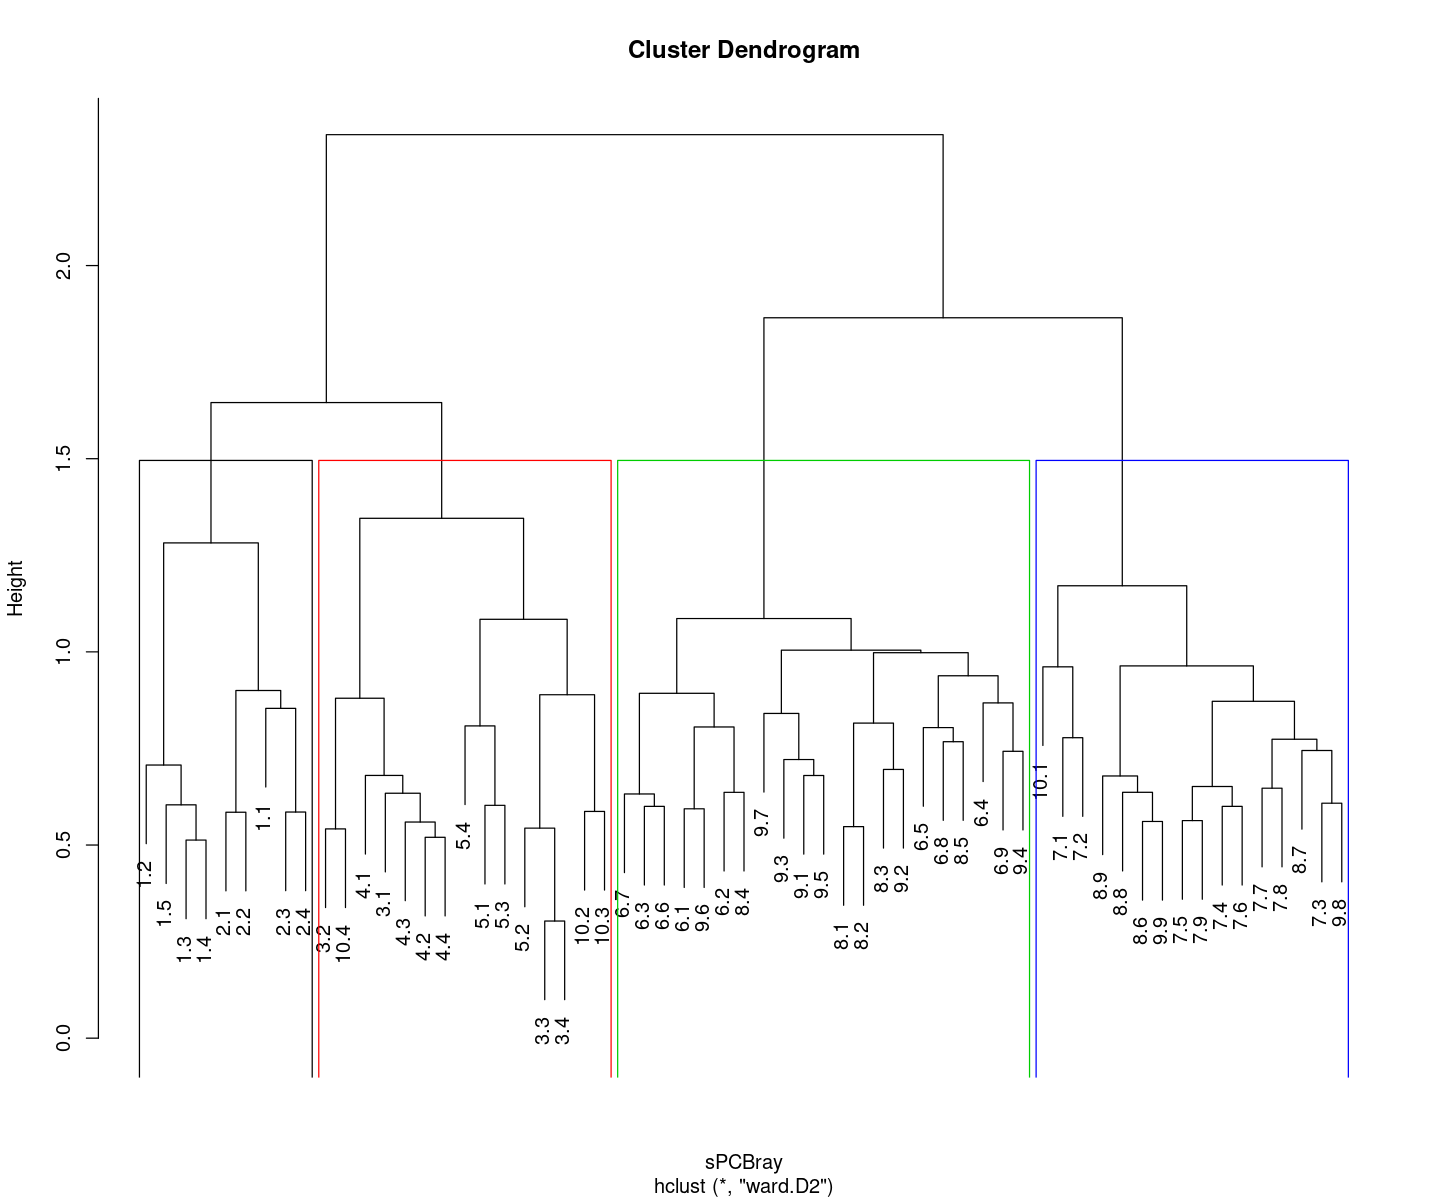

In [6]:
PC <- read.csv('subParcelComm.csv', row.names='PsubP')
sPCBray <- vegdist(sPC)
sPC.ward <- hclust(sPCBray, method='ward.D2')
envOnly <- read.csv('envOnly.csv', row.names='PsubP')
pts <- read.csv('pts.csv', row.names='PsubP')
k=4

options(repr.plot.width=12, repr.plot.height=10)
plot(sPC.ward)
clustGroups <- rect.hclust(sPC.ward, k=k, border=1:k)


This has been more completely sorted out elsewhere, with the final results saved in the envOnly dataframe, but the basics of getting the cluster results an getting them into vector formats. These vectors are more useful than the old-fashioned list that comes out-of-box:

In [7]:
PsubP <- vector()
gr <- vector()
for (i in 1:k){
    cmem.i <- as.numeric(attr(clustGroups[[i]], "names"))
    PsubP <- c(PsubP, cmem.i)
    gr <- c(gr, rep(i, length(cmem.i)))
    }


We can relabel this dendrogram with the historical land-use/habitat:

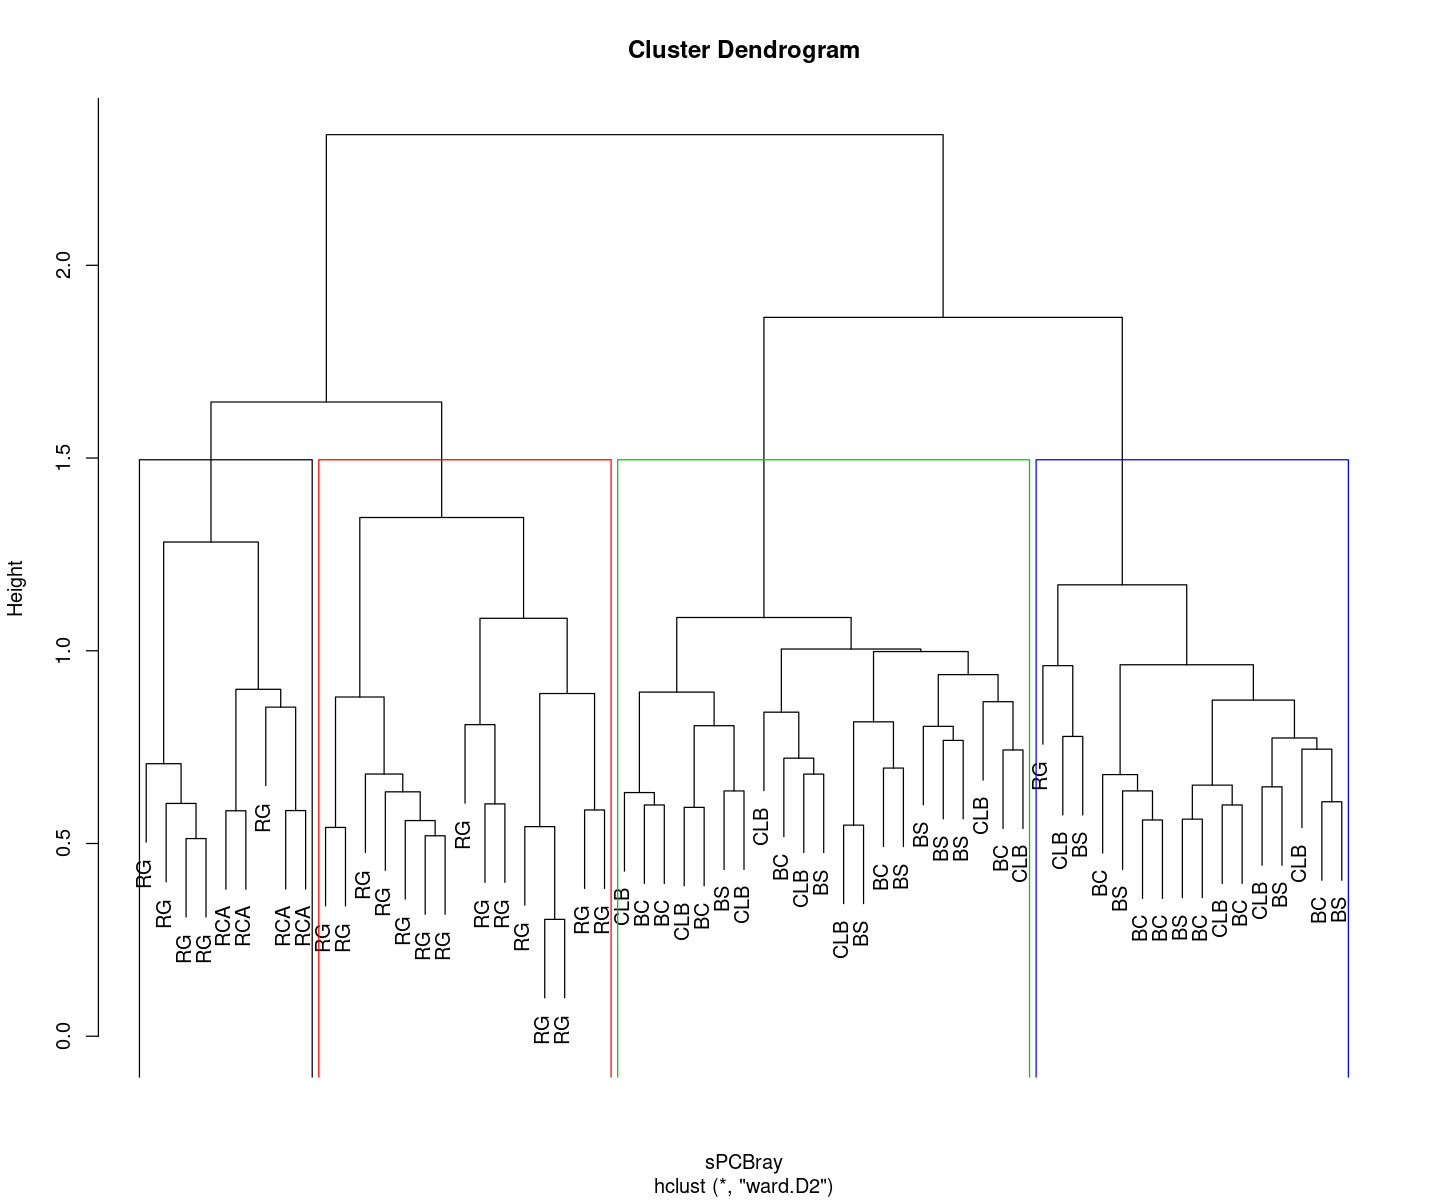

In [11]:
## match up the sites as ordered in the dendrogram with the land-use/habitat:
lab <- vector(length = length(sPC.ward$labels))
for (i in 1:length(sPC.ward$labels)){
    ind <- which(row.names(envOnly)==sPC.ward$labels[i])
    lab[i] <- as.character(envOnly$habitat[ind])
}
plot(sPC.ward, labels=lab)
clustGroups <- rect.hclust(sPC.ward, k=k, border=1:k)


A function to show our tree, along with a physical map of the points:

In the tree above, the RCA plots are again by themselves in a group, with a few RG plots. The closest "relative" of these RCA plots is a section that contains the majority of the RG plots, group 2, in red. The other two groups (groups 3/green and 4/blue) form a major branch, and contain most of the secondary and closed forest, and the natural gaps. Interesting that the gaps cluster in with the forest so distinctly from the regen sites. The split in the forest groups, 3 & 4, may be showing the difference between riparian and upland sites, but needs a closer look. 

To start, we can ordinate these and see if the results make sense. We have a typical NMS result built above, in the 

In [15]:
load('fullCommNMS.rda')
library(vegan)
library(RColorBrewer)

In [16]:
specObs <- read.csv('specObs.csv')
aa = specObs[c("PsubP","habitat")]
nondups <- aa[!duplicated(aa),]
nondups <- nondups[order(nondups$PsubP),]
cGroup = read.csv('cGroup.csv')
rownames(nondups) <- NULL
all(nondups$PsubP == cGroup$PsubP)
nmsInfo <- merge(nondups, cGroup)
nmsInfo$MDS1 <- nms$points[,'MDS1']
nmsInfo$MDS2 <- nms$points[,'MDS2']

[1] TRUE

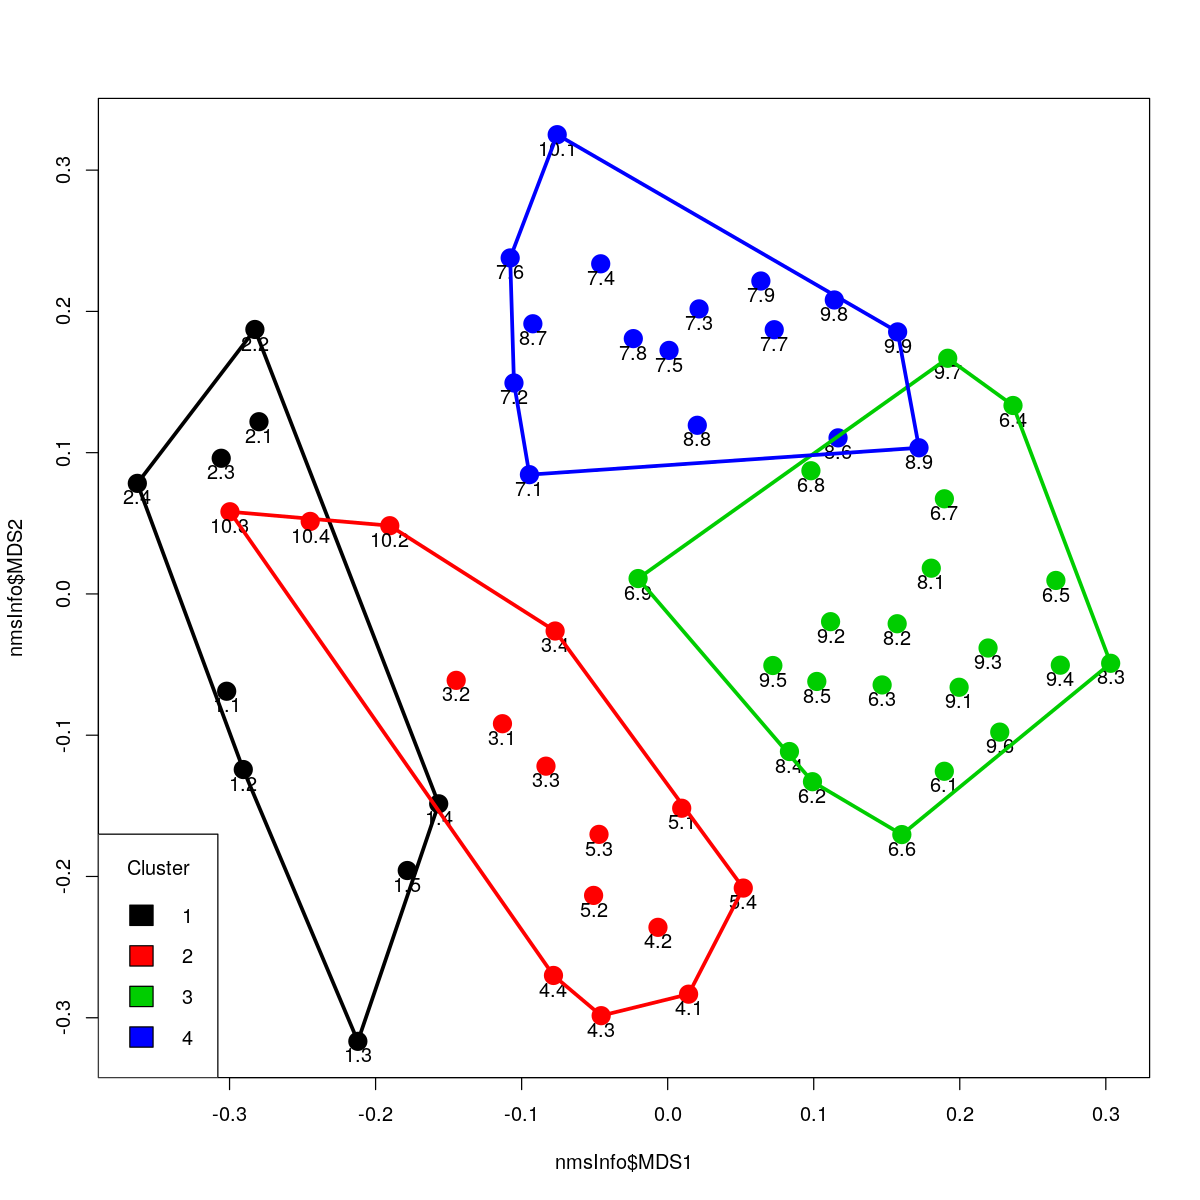

In [30]:
options(repr.plot.width=10, repr.plot.height=10)
plot(nmsInfo$MDS1, nmsInfo$MDS2,
    col=nmsInfo$gr,
    pch=19,
    cex=2.0,
)

text(nmsInfo$MDS1, nmsInfo$MDS2 - 0.01, nmsInfo$PsubP, cex=1)

legend( x='bottomleft',
        legend = 1:4,
        fill = 1:4,
        cex = 1.0,
        title='Cluster',
        )
ordihull(nms, nmsInfo$gr, col=1:4, lwd=3)


<a id="clustNMS"></a>
The natural groups we find with the cluster algorithm separate pretty well. Check permanova model:

In [17]:
library(vegan)
cGroup <- read.csv('cGroup.csv', row.names="PsubP")
subParcelComm <- read.csv('subParcelComm.csv', row.names="PsubP")
all(rownames(subParcelComm) == rownames(cGroup))

adonis(sPC ~ cGroup$gr)

[1] TRUE


Call:
adonis(formula = sPC ~ cGroup$gr) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
cGroup$gr  1     2.441 2.44098  6.9694 0.10565  0.001 ***
Residuals 59    20.664 0.35024         0.89435           
Total     60    23.105                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Interesting, just based on the tight grouping above I thought the variance explained would be greater. To clarify and confuse, let's switch out the hulls for the habitat type (RCA, RG, forest types):

In [35]:
svg('graphics/landuseForestTypeNMS.svg')
plot(nmsInfo$MDS1, nmsInfo$MDS2,
    col=nmsInfo$gr,
    pch=19,
    cex=2.0,
    xlab='NMS1',
    ylab='NMS2',
    main='Adult tree community NMS\ncolored by forest type and historical land-use/habitat'
)
#text(nmsInfo$MDS1, nmsInfo$MDS2 - 0.015, nmsInfo$PsubP, cex=1.5)
## add a legend
legend( x='bottomleft',
        legend=1:4,
        fill=1:4,
        cex=1.0,
        bty='n',
        title='Forest\nType'
        )

legend( x='bottomright',
        legend=c('BC', 'BS', 'CLB', 'RCA', 'RG'),
        #fill = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        col=c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        cex=1.0,
        lty=1,
        lwd=3,
        bty='n',
        title='Historical\nland-use/habitat' 
        )
ordihull(nms, nmsInfo$habitat, col=c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'), lwd=3)
dev.off()


png 
  2

In [14]:
nms


Call:
metaMDS(comm = sPC, try = 40) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sPC) 
Distance: bray 

Dimensions: 2 
Stress:     0.2882521 
Stress type 1, weak ties
No convergent solutions - best solution after 40 tries
Scaling: centring, PC rotation, halfchange scaling 
Species: expanded scores based on ‘wisconsin(sPC)’ 


Yup, it is the same story, told here in one figure. The old forest sites divide cleanly into two groups (blue/green dots). The different habitat types (BC, BS, CLB) don't really matter, the old forest sites clump together. The intensive agriculture spots (RCA) are on their own. The regeneracion sites (RG, orange polygon) are intermediate and seem to be pulled into either direction, towards old forest or the RCA plots. Some of the regeneracion sites even cluster directly in with the RCA plots (black circles). 

[back to top](#contents)

<a id='landUseOnlymultinomial'></a>
### Prediction of current ecological state by land use history

Let's construct a model to see how well land-use history predicts the ecological state of the forests "currently" ( = at the time of Ana's surveys). While there are many factors to consider, and spatial statistical concerns, for the moment we can do a fairly simple multinomial regression using the land use history ("habitat" in Ana's data) as our X variable, and the results from the above hierarchical clustering analysis as our Y. 

We'll stay bayesian in our approach here. This is because the frequentist approach typically uses maximum-likelihood estimators that can get brittle when faced with categories in your X variable that predict response categories really well (to learn more, search the term "perfect separation"). Kind of ironic. 

Our model will be a generalized linear model with a softmax link function. The final posterior is multivariate, taking the form of an array of each four forest types, each with its own $\theta$ at each observation (sample site). So the following code are conducted in the "bayesAna" conda environment we have for using PyMC3:

In [4]:
y_sMe = pd.Categorical(landUseForesttypeDF['forestType']).codes
luDummy = (pd.get_dummies(landUseForesttypeDF, columns=['landUse']))
luDummy.drop(columns=['forestType'], inplace=True)
x_sMe = luDummy.values

with pm.Model() as model_sMe:
    α = pm.Normal('α', mu=0, sd=5, shape=4)
    β = pm.Normal('β', mu=0, sd=5, shape=(5,4))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_sMe, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_sMe)
    trace_sMe = pm.sample(2000, init='adapt_diag')


/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureW

Well, PyMC3 is running pretty rough. But looks like the sampling finished. Let's look at the posteriors.

For both the intercept and coefficients, we had a kind of "null hypothesis" prior, as in, we didn't propose a difference, all were given prior distribution centered on zero with a fairly wide variance (stdev = +/-5). Given our number of categories of land use (5), this was sort of like saying all categories of land use could cause all types of forest. As in, no predictive value. 

After showing it our data, the model sorted out the disturbed forest types from undisturbed pretty well, but couldn't distinguish at all between the two types of "old" or undisturbed forest. We can see this with their nearly identical intercept:

Text(0.5, 1.0, 'y-intercepts of forest type')

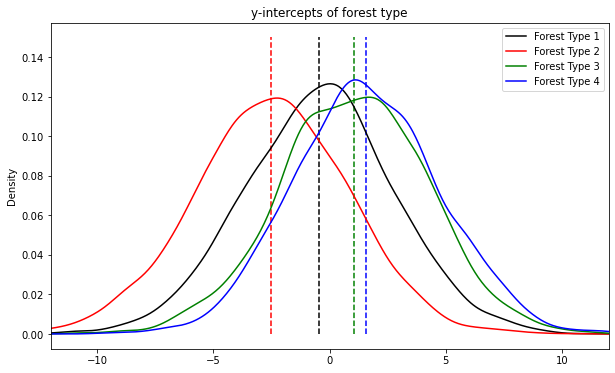

In [19]:
colrs = ['k','r','g','b']
fig, ax = plt.subplots(figsize=(10,6))
for i in range(4):
    (pd.Series(trace_sMe['α'][:,i]
       .copy())
       .sort_values()
       .reset_index(drop=True)
       .plot.density(ax=ax, label=f'Forest Type {i+1}', color=colrs[i])
    )

ax.vlines(trace_sMe['α'].mean(0), ymin=0, ymax=0.15, colors=colrs, linestyles='dashed')
ax.set_xlim(-12,12)
ax.legend()
ax.set_title('y-intercepts of forest type')


Types 3 and 4 are "old" or "undisturbed" forest. They can't easily be distinguished from each other by their response to land use, at least in our simple model. 

The coefficients of our model, for each category of land use:

In [12]:
luLabs = luDummy.columns.str.replace('landUse_','').to_list()
coeffDF = pd.DataFrame(trace_sMe['β'].mean(0),
                columns = [ f'ForestType{i}' for i in range(1,5) ],
                index  = luLabs,
                )
print(coeffDF)

     ForestType1  ForestType2  ForestType3  ForestType4
BC     -3.032915    -2.192313     2.778985     2.248562
BS     -3.006944    -2.149710     2.984648     2.079311
CLB    -3.009599    -2.088600     3.233835     1.925855
RCA     6.505434    -1.396062    -2.601098    -2.768796
RG      1.924349     5.153408    -5.170924    -2.019367


We can make that a little more visually appealing:

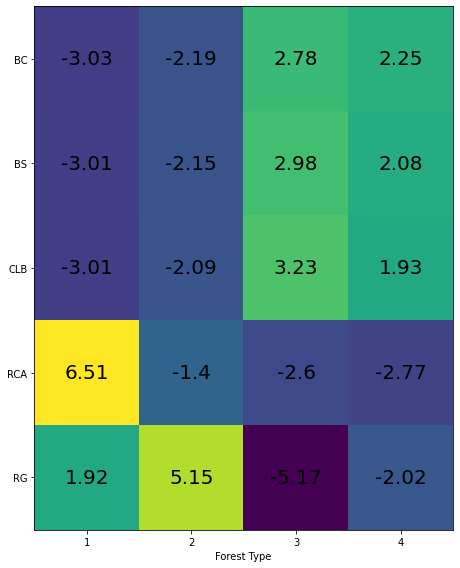

In [18]:
corrs = trace_sMe['β'].mean(0)
corrLabs = corrs.round(2)
forestType = [ f'{i}' for i in range(1,5) ]
landUse = luDummy.columns.str.replace('landUse_','').to_list()
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(corrs)
## fix ticks
ax.set_xticks(np.arange(len(forestType)))
ax.set_yticks(np.arange(len(landUse)))
ax.set_xticklabels(forestType)
ax.set_yticklabels(landUse)
# Loop over data dimensions and create text annotations.
for i in range(len(landUse)):
    for j in range(len(forestType)):
        text = ax.text(j, i, corrLabs[i, j],
                        ha="center",
                        va="center",
                        fontsize=20, 
                        color="k")


ax.set_xlabel('Forest Type')
fig.tight_layout()

My understanding may be simplistic here, but I understand this as positive coefficients as increasing the probability of a land type at a site, and negative coefficients as decreasing the predicted probability of that land type. 

So for example, having a 1/yes/true value for land use type "RCA" makes it very probable that a site will be Forest type 1. Having a history of closed forest ("BC") makes it less likely. 

So how well does this model predict the datapoints we have? How are the "residuals"? Stated in a more bayesian way, how is the posterior predictive ability of our model? 

Our posterior is a categorical distribution, with an individual $\theta$ for each category. The trace from our model gives the array of sampled values for the log-likelihood of each forest type at each of our sample site data points. We can average these values to get the predicted value from the model at each sample site: 

In [20]:
data_predMe = trace_sMe['μ'].mean(0)
## this gets the posterior probabilities for each type of 
## of forest, so ebach PusbP site has an array with four 
## probabilities which should sum to one. Log-likelihoods
## so has to be exponentiated:
y_predMe = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_predMe]

## then we take the forest type with the highest probability 
## for each, because these are the predictions for each site:
predictedForestType = pd.Series(np.argmax(y_predMe, axis=1), index=landUseForesttypeDF.index)
## reformat our observed into series:
observedForestType = pd.Series(y_sMe, index=landUseForesttypeDF.index)
## how often are we right?
(predictedForestType == observedForestType).sum()/len(predictedForestType)

0.6557377049180327

Our model is right 65% of the time. We can visualize this:

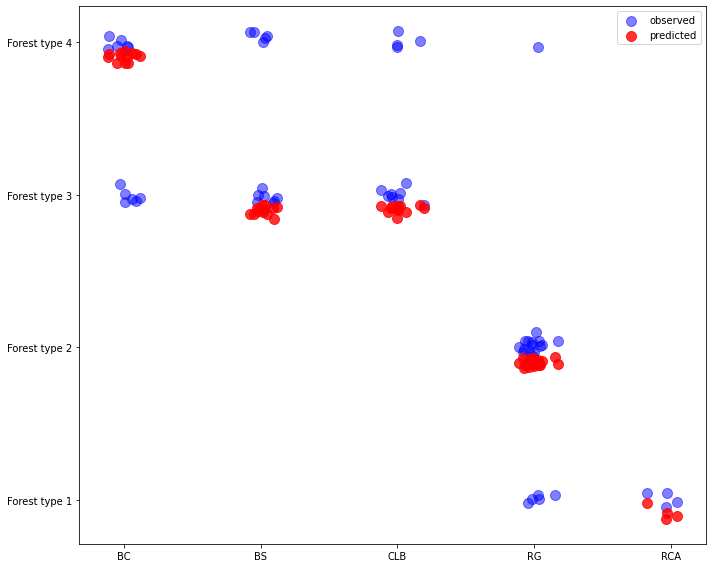

In [32]:
observedForestType
predictedForestType
landUse = landUseForesttypeDF['landUse']
## turn landUse into codes
landUseCodes = pd.Series(pd.Categorical(landUse).codes, index=landUse.index)
## our codes are confusing...can we fix them? 
## this should be as simple as trading them out at this stage? 
## we want to switch "3" and "4" codes so that they
## graph pleasantly:
landUseGraphCodes = landUseCodes.copy()
landUseGraphCodes[landUseCodes == 3] = 4
landUseGraphCodes[landUseCodes == 4] = 3
## make a dataframe to not lose touch here:
landUseCodeDF = pd.concat([landUse, landUseCodes, landUseGraphCodes],
    axis=1)
landUseCodeDF.columns = ['landUse', 'landUseCodes', 'landUseGraphCodes']
landUseCodeDF.drop_duplicates(inplace=True)
## I think both need some jitter for both, so we can observe quantity of sites 
landUseGraphCodesJit = landUseGraphCodes.apply(lambda x: x + np.random.normal(loc=0, scale=0.08))
observedForestTypeJit = observedForestType.apply(lambda x: x + np.random.normal(loc=0, scale=0.03))
predictedForestTypeJit = predictedForestType.apply(lambda x: x + np.random.normal(loc=-0.1, scale=0.03))
plt.close('all')
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(landUseGraphCodesJit, observedForestTypeJit,
            alpha=0.5, c='blue', label='observed', s=100)
## reset our labels:
yForest = [ f'Forest type {i}' for i in range(1,5) ]
xLandUse = [ landUseCodeDF.set_index('landUseGraphCodes')
                .loc[i].loc['landUse'] for i in range(0,5) ]
ax.scatter(landUseGraphCodesJit, predictedForestTypeJit,
            alpha=0.8, c='red', label='predicted', s=100)
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2,3,4])
ax.set_yticklabels(yForest)
ax.set_xticklabels(xLandUse)
plt.legend()
plt.tight_layout()


Notice that the only real sources of confusion for the model are between the two "old" - or "undisturbed" - forest types (Types 3,4), and forests resulting from land use "RG", which was our category for pasture or other light agricultural use. 

We can also do a bayesion R2 of the model, using a formal posterior predictive:

In [34]:
ppc = pm.sample_posterior_predictive(trace_sMe, samples=5000, model=model_sMe)
az.r2_score(y_sMe, ppc['yl'])

100%|██████████| 5000/5000 [00:15<00:00, 317.00it/s]


r2        0.655416
r2_std    0.038126
dtype: float64

About 65% of our variation is predicted with this very simple model. Matches our manual check above using the raw posterior estimates. 

Since the model can't distinguish between the forest types III and IV, what happens when we lump them?

In [35]:
aa = predictedForestType.copy()
bb = observedForestType.copy()
aa[aa == 3] = 2
bb[bb == 3] = 2
(aa == bb).sum()/len(bb)


0.9016393442622951

Great, so if we consider all old forest types as one category (which is not unreasonable looking at our hierarchical clustering results above), the model correctly predicts forest type from historical land use 90% of the time. The main uncertainty is the fate of the "RG" plots.

[back to top](#contents)

<a id='elevationClust'></a>
### Elevation of current ecological states

Elevation seems to be an important predictor of ecological state:

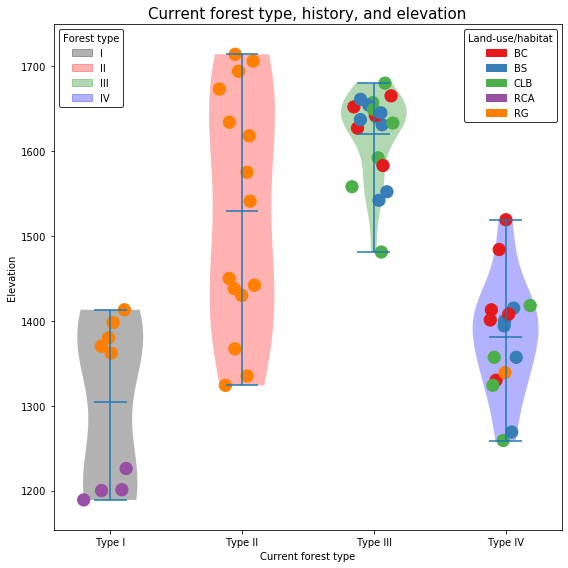

In [8]:
# etc
specObs = pd.read_csv('specObs.csv')
psubpHopsDF= pd.read_csv('psubpHopsDF.csv', index_col='PsubP')
subParcelComm = pd.read_csv('subParcelComm.csv', index_col='PsubP')
envOnly = pd.read_csv('envOnly.csv', index_col='PsubP')
landUseForesttypeDF = pd.read_csv('landUseForesttypeDF.csv', index_col='site')
watershedDistMat = pd.read_csv('watershedDistMat.csv', header=0, index_col=0)
watershedDistMat.columns = watershedDistMat.columns.astype('int')


elevLUDF = pd.concat([landUseForesttypeDF, envOnly], axis=1)[['landUse','forestType','elevacion']]
## set up colors for plotting, by historical land use
landuseColDict = {
          'BC':'#E41A1C',
          'BS':'#377EB8',
          'CLB':'#4DAF4A',
          'RCA':'#984EA3',
          'RG':'#FF7F00',
           }

landuseColrs = elevLUDF.landUse.apply(lambda x: landuseColDict[x])

plt.close('all')
fig, ax = plt.subplots(figsize=(8,8))
Xraw, Yraw = elevLUDF.forestType, elevLUDF.elevacion
Xjitted = (Xraw
            .apply(np.random.normal, args=(0.08,))
            )
breakUpData = [ Yraw[Xraw == i].to_list() for i in Xraw.unique() ]
vio = ax.violinplot(breakUpData, showmeans=True)
ax.scatter(Xjitted, Yraw, color=landuseColrs, s=150)
ax.set_xticks([1,2,3,4])
ax.set_title('Current forest type, history, and elevation')
ax.set_ylabel('Elevation')
ax.set_xlabel('Current forest type')
## color dictionary for forestType:
forestTypeColDict = {
                      1:'k',
                      2:'r',
                      3:'g',
                      4:'b',
                    }
## change violin patch color:
for i,j in enumerate(vio['bodies']):
    j.set_facecolors(forestTypeColDict[i+1])

## legend for land use history:
legend_patchesLU = [ Patch(color=j, label=i) for i,j in landuseColDict.items() ]
luLeg = ax.legend(handles=legend_patchesLU,
                    title="Land-use/habitat",
                    facecolor="white",
                    edgecolor="black",
                    loc="upper right",
                    bbox_to_anchor=(1, 1))


## legend for forest type
romanDict = { 1:'I', 2:'II', 3:'III', 4:'IV' }
colzNParr = [ i.get_facecolor() for i in vio['bodies'] ]
colz = [ tuple(i.flatten().tolist()) for i in colzNParr ]
forestLegPatches = [ Patch(color=j, label=romanDict[i+1]) for i,j in enumerate(colz) ]
ax.legend(handles=forestLegPatches,
            facecolor="white",
            edgecolor="black",
            title="Forest type",
            loc="upper left",
            bbox_to_anchor=(0, 1))
## add back in the old legend:
ax.add_artist(luLeg)
## tick labels need roman numerals, too:
_ = ax.set_xticklabels(
        [ f'Type {romanDict[i]}' for i in range(1,5) ]
        )
#plt.savefig('graphics/elevationForesttypeLU.svg')

It looks like lower elevation sites are more dynamic. All the sites that were used as pasture in the 1980's that eventually developed into type I forests (the most novel/disturbed type of forest) were low elevation forests. And the only site that recovered back to a primary-forest-like state was also a low elevation site (the only orange dot in the type 4). Below, in the section "[Linear model for distinguishing old forest types by elevation](#oldForestLogit)", we take a much closer look at elevation as a predictor of the two old forest types, Type III and Type IV. 

[back to top](#contents)

<a id='comboModel'></a>
### Combined model of current ecological state by land use and elevation

It seems like we have hunted down two very good predictors of current ecological state in the adult tree community: prior land-use/habitat and elevation. [Prior land-use/habitat](#landUseOnlymultinomial) can well predict which forest type a site will be, except among the old-forest types (types III and IV) that haven't been subject anthropogenic disturbance. As far these primary forest sites, a very strong predictor is elevation, modeled [below](##oldForestLogit). We modeled these separately, because they are understood more intuitively in this way. But can combine them into a single model, to make a powerful model for predictive the ecological fate of forest sites at Los Cedros:

In [18]:
y_sMe = pd.Categorical(landUseForesttypeDF['forestType']).codes
luDummy = (pd.get_dummies(landUseForesttypeDF, columns=['landUse']))
luDummy.drop(columns=['forestType'], inplace=True)
luElev = pd.concat([luDummy, envOnly.elevacion], axis=1)
x_s = luElev.values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

with pm.Model() as model_sMe:
    α = pm.Normal('α', mu=0, sd=5, shape=4)
    β = pm.Normal('β', mu=0, sd=5, shape=(6,4))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_sMe)
    trace_sMe = pm.sample(2000, init='adapt_diag')

/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureW

This changes our intercepts, creating separation between the forest types III and IV that wasn't observed in the model with only land-use/habitat as a predictor:

Text(0.5, 1.0, 'y-intercepts of forest type, with landuse and elevation predictors')

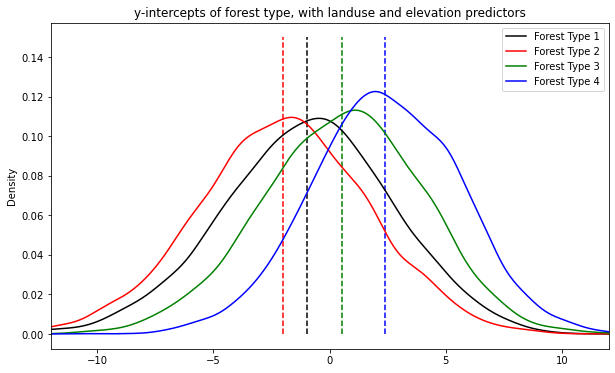

In [20]:
colrs = ['k','r','g','b']
fig, ax = plt.subplots(figsize=(10,6))
for i in range(4):
    (pd.Series(trace_sMe['α'][:,i]
       .copy())
       .sort_values()
       .reset_index(drop=True)
       .plot.density(ax=ax, label=f'Forest Type {i+1}', color=colrs[i])
    )

ax.vlines(trace_sMe['α'].mean(0), ymin=0, ymax=0.15, colors=colrs, linestyles='dashed')
ax.set_xlim(-12,12)
ax.legend()
ax.set_title('y-intercepts of forest type, with landuse and elevation predictors')


Take a look at the covariances:

In [21]:
labs = luElev.columns.str.replace('landUse_','').to_list()
coeffDF = pd.DataFrame(trace_sMe['β'].mean(0),
                columns = [ f'ForestType{i}' for i in range(1,5) ],
                index  = labs,
                )

print(coeffDF)


           ForestType1  ForestType2  ForestType3  ForestType4
BC           -2.139649    -1.874486     1.241576     2.868064
BS           -2.178043    -1.654626     2.485029     1.556822
CLB          -2.186576    -1.502352     2.892250     0.919504
RCA           5.502492    -0.744525    -1.043763    -3.759282
RG            2.745913     4.766925    -4.957592    -2.521835
elevacion    -1.271000     2.039068     6.454915    -7.175716


As above, we can prettify this:

Text(0.5, 0, 'Forest Type')

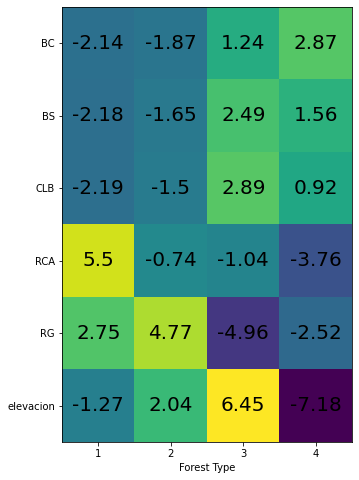

In [22]:
coeffs = trace_sMe['β'].mean(0)
coeffLabs = coeffs.round(2)
forestType = [ f'{i}' for i in range(1,5) ]
predictors = luElev.columns.str.replace('landUse_','').to_list()
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(coeffs)
## fix ticks
ax.set_xticks(np.arange(len(forestType)))
ax.set_yticks(np.arange(len(predictors)))
ax.set_xticklabels(forestType)
ax.set_yticklabels(predictors)
# Loop over data dimensions and create text annotations.
for i in range(len(predictors)):
    for j in range(len(forestType)):
        text = ax.text(j, i, coeffLabs[i, j],
                        ha="center",
                        va="center",
                        fontsize=20,
                        color="k")

ax.set_xlabel('Forest Type')


These coefficients really make sense. We see the same stark contrast between the type III and type IV responses to  elevation. Also the strong, positive covariance between a history of intensive agriculture (RCA) and the Type I forest. Etc, etc. 

So is the model a good predictor of the sites we have?:

In [23]:
data_predMe = trace_sMe['μ'].mean(0)
y_predMe = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_predMe]
predictedForestType = pd.Series(np.argmax(y_predMe, axis=1), index=landUseForesttypeDF.index)
observedForestType = pd.Series(y_sMe, index=landUseForesttypeDF.index)
(predictedForestType == observedForestType).sum()/len(predictedForestType)

0.8688524590163934

The model correctly predicts the current ecological state for our sites 86.9% of the time.

We can check the variance explained, also:

In [24]:
ppc = pm.sample_posterior_predictive(trace_sMe, samples=5000, model=model_sMe)
az.r2_score(y_sMe, ppc['yl'])

100%|██████████| 5000/5000 [00:16<00:00, 309.77it/s]


r2        0.878583
r2_std    0.161417
dtype: float64

This model explains 87.8% of the variance. That's promising.

[back to top](#contents)

<a id='DEMmap'></a>

### Physical Map

Let's put an elevation and water (rivers and stream) map under these plots. We'll use python here, as the geopandas library is way easier to use than the whole mess of R geospatial packages. 

#### Cleaning the raw data
The first step is a bit of cleanup from the data I've received from Ana. Location information for all 30m-diameter plots was given to me from Ana in a file called "GPSpointsCedros.xls". For the points to make sense from this file, I had to exchange the N and E columns, I think they were switched/mislabeled, and that the easting column is off by 10^7 meters. They appear to be in a UTM CRS, but not the zone 17S that I typically use for the LC area. I think they are probably in UTM Zone 17N, but not sure. Swapping the N/E columns and adding 10^7 meters seems to fix the problem. Following this, I imported the spreadsheet into QGIS for a visual check. One subplot, 2.4 seemed especially off to Ana, as it was outside the reserve. Dropping the northing on this plot exactly 1 km to the south put it right back into the cluster of other Parcel 2 subplots, so that is my guess on what happened there. These points were exported it as geojson, which we can turn into a geopanda here:


In [3]:
anaPt = gpd.read_file('GIS/ana30meterPlots.geojson')
## our cluster info is here:
cGroup = pd.read_csv("cGroup.csv")
## add this cluster info in
anaPt = anaPt.merge(cGroup, on="PsubP")
## make a vector for coloring the clustering results:
cdik={
1:"k",
2:"r",
3:"g",
4:"b"
}
anaPt['clustCols'] = [ cdik[i] for i in anaPt.gr ]
## where is our habitat data?:
envOnly = pd.read_csv('envOnly.csv')
anaPt = anaPt.merge(envOnly, on="PsubP")
## set the habitat symbol
msym_dik={
'BC':'o',
'BS':'p',
'CLB':'s',
'RCA':'^',
'RG':'D',
}
anaPt['habSyms'] = [ msym_dik[i] for i in anaPt.habitat ]


That seems to work alright. Now we can use this as our point layer for the plots. But we can get a few other layers that I have handy for los Cedros also - a DEM (elevation map), a polygon on LC boundaries, and a map of streams and rivers of los Cedros.

In [4]:
lcPoly = gpd.read_file('GIS/lcPoly.geojson')
hydro = gpd.read_file('GIS/lcRiversStreams.geojson')
dem = rasterio.open("GIS/anaPlotDEM.tif")
paths = gpd.read_file('GIS/PathsLC.geojson')

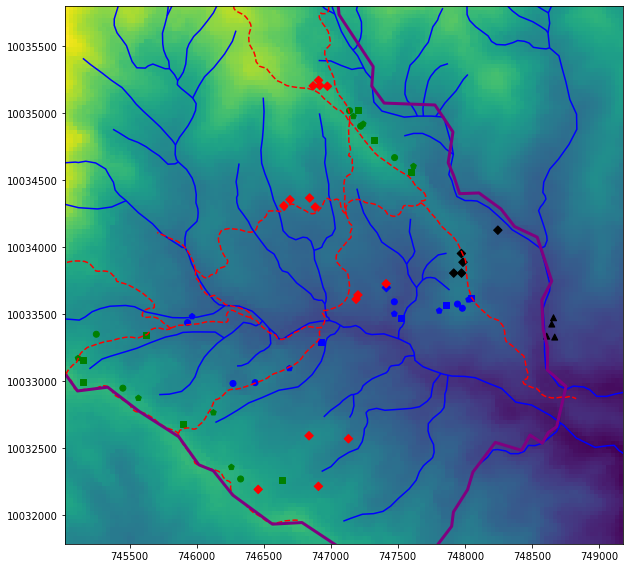

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.ticklabel_format(useOffset=False, style='plain')
for i in anaPt.habitat.unique():
    anaPtI = anaPt[anaPt['habitat'] ==  i].reset_index()
    anaPtI.plot(color=anaPtI.clustCols,
                marker=anaPtI.habSyms[0],
                ax=ax)

hydro.plot(color='Blue', ax=ax)
paths.plot(color='red', linestyle='--', ax=ax)
lcPoly.boundary.plot(color='purple', linewidth=3, ax=ax)
rasterio.plot.show(dem, ax=ax)

<a id='actMap'></a>

The legend is sufficiently complex, so I made one manually:

<img src='graphics/physMap_edited.png'>

[back to top](#contents)

<a id="watersheds"></a>

### Watershed delineations

There is the perennial statement: "Each watershed in the tropical Andes is radically different than the next." I believe this is true, but does our data show it, as far as vegetative community? The only way I see of testing this is by dividing los Cedros into a set of evenly sampled sub-watersheds (catchments or microcuencas) and look at the turnover among them.

<a id='makeMicrocuencas'></a> 
#### Define microcuencas

We'll use [pysheds](https://mattbartos.com/pysheds/), and its various tutorials for delineating watersheds in Los Cedros. For our topographic info, we start with a [ASTER GDEM 2](asterweb.jpl.nasa.gov/gdem.asp) digital elevation model. These come in full 1° tiles, and we subsetted from this to make our physical map above. I found I had better luck with the pipeline below using the larger tiles, rather than the highly clipped DEM for the study area. So for below we use a much larger tile than we use for our map above, but much smaller than the full 1° tile, which requires too much computational power to process. Rasterio has a good function for clipping rasters, from BASH:


`astTile="/home/daniel/Documents/LosCed/Ecuador_GIS/losced/ASTGTM2_N00W079/ASTGTM2_N00W079_dem_UTM17S.tif"`

`rio clip $astTile GIS/smallAster.tif --bounds "722546 9999985 766393 10057694"`


For reprojection from WGS84 (classic lat/long) to UTM zone 17S, I used QGIS. Reprojection in Rasterio is somewhat technical, so I skipped it. 

We can look at this as a raster with rasterio:

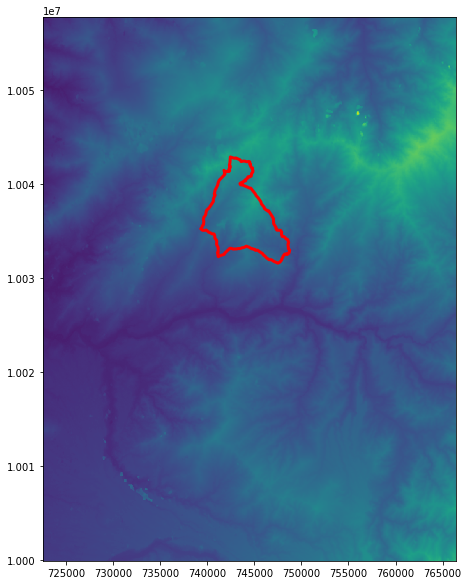

In [7]:
smallAstpath = "/home/daniel/Documents/analyses/losCedrosTrees/anaData/GIS/smallAster.tif"
smallAstRast = rasterio.open(smallAstpath)
lcPoly = gpd.read_file('GIS/lcPoly.geojson')
fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(smallAstRast, ax=ax)
lcPoly.boundary.plot(color='red', linewidth=3, ax=ax)

These DEMs tend have some artefacts in them, artificial depressions and flats that can cause problems. Pysheds has some tools for this...then we can get the flow direction and accumulation maps for the whole ASTER tile.

In [8]:
## import our dem as a grid object for pysheds
smallAstpath = "/home/daniel/Documents/analyses/losCedrosTrees/anaData/GIS/smallAster.tif"
grid = Grid.from_raster(smallAstpath, data_name='dem')
## clean it up as per recommendations by pyshed.
grid.fill_depressions(data='dem', out_name='flooded_dem')
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
## make our flowdir and accumulation 
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

In [9]:
grid.accumulation(data='dir', dirmap=dirmap, out_name='acc', apply_mask=False)

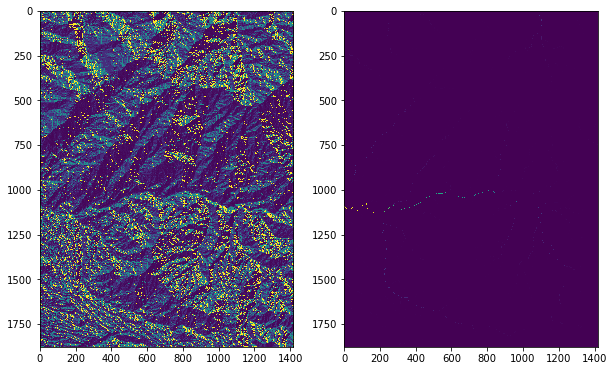

In [10]:
fig, ax = plt.subplots(1,2, figsize= (10,10))
ax[0].imshow(grid.dir)
ax[1].imshow(grid.acc)

Now we need to subset our DEM to just the watersheds of interest, the Rio Los Cedros and the Rio Magdalena Chico. To do this, we need pour points for these watersheds. We can estimate these from the maps [above](#actMap), but missing the river by just one or two pixels can throw off the delineation process. Even if we nail it perfectly, the river layers we have from digitizing our topos are different enough from the DEM to cause the sub-watershed delineations to fail badly. The pour point has to be directly in the rivers or streams that are predicted by our flow accumulation models. This confused me for a long time - I could not find the pour points I needed to delineate watersheds. So, for posterity, I mention here the process of how to do this. 

The full tutorial by the author of pysheds is on the [pysheds github repo](https://github.com/mdbartos/pysheds/blob/master/examples/snap_to_mask.ipynb).

 Step 1: draw up a map such as [above](#actMap) and from the python interpreter call the pyplot function `ginput()` - which is roughly equivalent to R's `locate()` function - to save the X,Y coordinates under the mouse cursor, something like:
 
`X,Y = plt.ginput(1)[0]`
 
Step 2: snap these to the points of high accumulation using pyshed's `snap_to_mask()` function. 

In [11]:
## so these values are for the LC watershed, 
## obtained by hand clicking on the above map, 
XL, YL = (748696, 10032712) ## Rio Los Cedros
XM, YM = (748696, 10032942) ## Rio Magdalena Chico

In [12]:
## now find the nearest point of high accumulation, 
## which will presumably be in the nearest river...
snapXL, snapYL = grid.snap_to_mask(grid.acc > 50, np.array([XL,YL]), return_dist=False)
snapXM, snapYM = grid.snap_to_mask(grid.acc > 50, np.array([XM,YM]), return_dist=False)

In [13]:
grid.clip_to('dem')
grid.catchment(data='dir', x=snapXL, y=snapYL, out_name='RLCcatch',
                   recursionlimit=15000, xytype='label')

grid.catchment(data='dir', x=snapXM, y=snapYM, out_name='RMCcatch',
                   recursionlimit=15000, xytype='label')

Cut to the catchment and look at it:

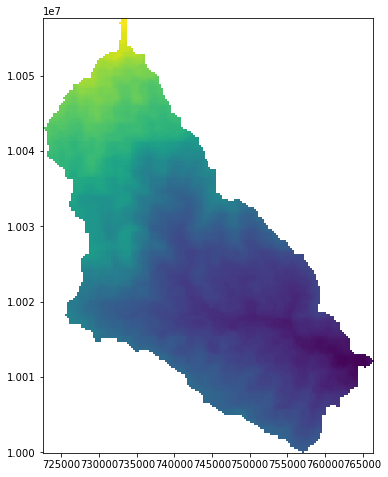

In [14]:
grid.clip_to('RLCcatch')
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(grid.view('dem'), extent=grid.RLCcatch.extent)

We can convert this to a polygon and export to geojson using geopandas. Fiona alone would probably do the job somehow (geopandas uses Fiona for file i/o anyway, I think) but I ran into troubles with Fiona's default of giving all geojsons a WGS84 lat/long CRS.

In [12]:
## make sure we are clipped to the watershed we want:
grid.clip_to('RLCcatch')
## then vectorize:
shapes = grid.polygonize()
lsh = list(shapes)
aa = shapely.geometry.polygon.Polygon(lsh[0][0]['coordinates'][0])
p = gpd.GeoSeries(aa)
p = p.set_crs('EPSG:32717')
## these can be saved to a geojson: 
#p.to_file("./GIS/rioLCwatershed.geojson", driver='GeoJSON')
## repeat the above with rio magdalena chico data and save as:
#p.to_file("./GIS/rioMCwatershed.geojson", driver='GeoJSON')

Show the boundary of the watersheds. We can also include the adjacent Rio Magdalena Chico watershed, which contains a few of the sample sites. Between them, they encompass the entirety of the study. 

(10031270.357894145, 10042847.815274313)

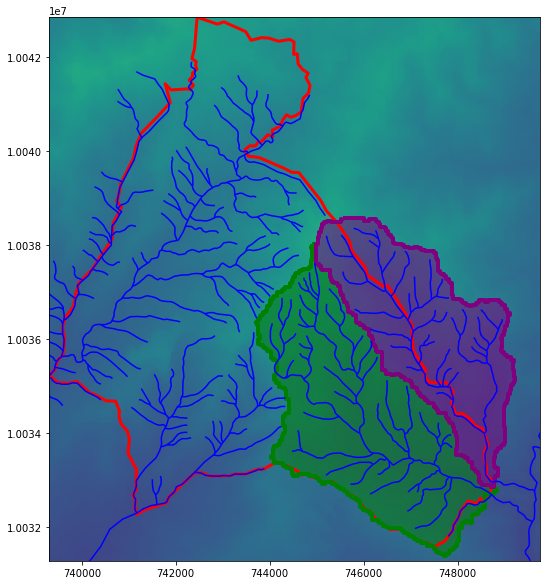

In [15]:
rioLCWatershedPoly = gpd.read_file('GIS/rioLCwatershed.geojson')
rioMCWatershedPoly = gpd.read_file('GIS/rioMCwatershed.geojson')
lcPoly = gpd.read_file('GIS/lcPoly.geojson')
hydro = gpd.read_file('GIS/lcRiversStreams.geojson')
smallAstRast = rasterio.open(smallAstpath)


alpha = {'alpha':0.5}

fig, ax = plt.subplots(figsize=(10,10))
lcPoly.boundary.plot(color='red', linewidth=3, ax=ax)
rioLCWatershedPoly.boundary.plot(ax=ax, color='Green', linewidth= 4)
rioLCWatershedPoly.plot(ax=ax, color='Green', **alpha)
rioMCWatershedPoly.boundary.plot(ax=ax, color='purple', linewidth= 4)
rioMCWatershedPoly.plot(ax=ax, color='Purple', **alpha)
rasterio.plot.show(smallAstRast, ax=ax)
hydro.plot(color='Blue', ax=ax)
ax.set_xlim(lcPoly.bounds.iloc[0,0], lcPoly.bounds.iloc[0,2]+1000)
ax.set_ylim(lcPoly.bounds.iloc[0,1]-300, lcPoly.bounds.iloc[0,3])

We can use the flow map to predict river networks. This has to be done on a catchment-by-catchment basis. So for the Rio Los Cedros watershed:

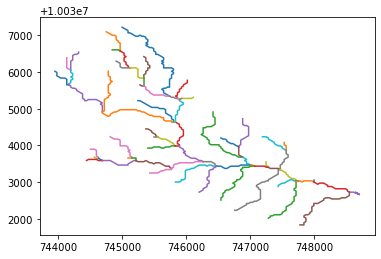

In [15]:
grid.clip_to('RLCcatch') ## must do this! if clipped to full dem, screws up everything.
branches = grid.extract_river_network('RLCcatch', 'acc')
fig, ax = plt.subplots()
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    ax.plot(line[:, 0], line[:, 1])

We can turn these into geopandas series also, to make for easy plotting:

In [17]:
grid.clip_to('RLCcatch')
branches = grid.extract_river_network('RLCcatch', 'acc')
listOfLSes = [ shapely.geometry.LineString(i['geometry']['coordinates']) for i in branches['features'] ]
RLC_multistring = shapely.geometry.MultiLineString(listOfLSes)
RLCgpd = gpd.GeoSeries(RLC_multistring)
RLCgpd = RLCgpd.set_crs('EPSG:32717')
#RLCgpd.to_file("./GIS/rioLCpredicted.geojson", driver='GeoJSON')

grid.clip_to('RMCcatch')
branches = grid.extract_river_network('RMCcatch', 'acc')
listOfLSes = [ shapely.geometry.LineString(i['geometry']['coordinates']) for i in branches['features'] ]
RMC_multistring = shapely.geometry.MultiLineString(listOfLSes)
RMCgpd = gpd.GeoSeries(RMC_multistring)
RMCgpd = RMCgpd.set_crs('EPSG:32717')
#RMCgpd.to_file("./GIS/rioMCpredicted.geojson", driver='GeoJSON')

How do these look in comparison to our digitized stream network from the old los Cedros topo?

Text(0.5, 1, 'Rio Magdalena Chico')

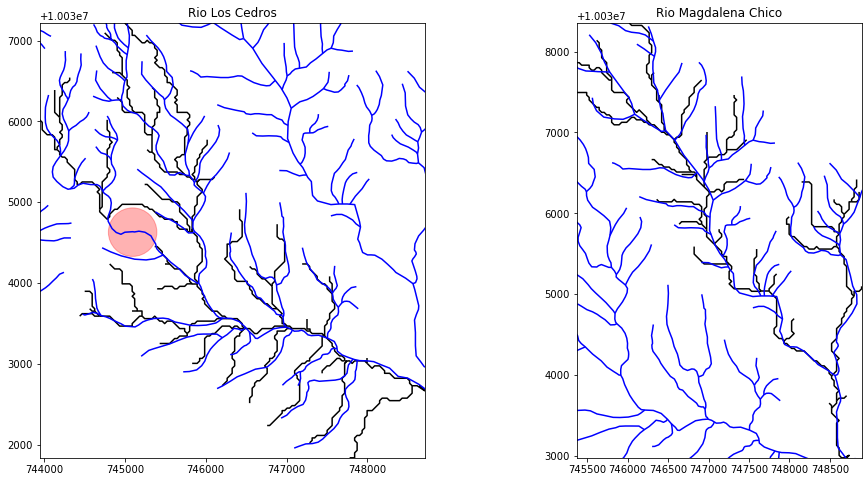

In [26]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
## RLC
RLCgpd.plot(color='Black', ax=ax[0])
hydro.plot(color='Blue', ax=ax[0])
ax[0].set_xlim(RLCgpd.bounds.minx[0],RLCgpd.bounds.maxx[0])
ax[0].set_ylim(RLCgpd.bounds.miny[0],RLCgpd.bounds.maxy[0])
ax[0].set_title('Rio Los Cedros')
circCent = (745095, 10034629)
circ = plt.Circle(circCent, radius=300, alpha=0.3, color='red')
ax[0].add_artist(circ)
## RMC
RMCgpd.plot(color='Black', ax=ax[1])
hydro.plot(color='Blue', ax=ax[1])
ax[1].set_xlim(RMCgpd.bounds.minx[0],RMCgpd.bounds.maxx[0])
ax[1].set_ylim(RMCgpd.bounds.miny[0],RMCgpd.bounds.maxy[0])
ax[1].set_title('Rio Magdalena Chico')

Black is the predicted stream from the digital elevation maps, and blue is the hand digitized stream network from the los Cedros topographical map (from the 1990's). Assuming the topographical map is more correct (drawn from aerial photos), we see some errors in the predictions. Some of this is probably related to pixel size, 30m on a side for the DEM cells. The largest error I see is in the jump in the upper RLC watershed (red circle, left). This error is not trivial - it is rerouting the upper Rio Los Cedros! Also just south of there it looks like a fairly large stream "jumped" away, is predicted to be part of the quebrada de mono catchment. Other jumps occurred throughout the southern side. 

Makes me wonder if these DEMs are intended for this fine level work. Anyway, we'll use it as a first pass for delineating watersheds. We can get the main stems of each of the two rivers:

In [75]:
## Rio Los Cedros main stem:
grid.clip_to('RLCcatch')
branch = grid.extract_river_network('RLCcatch', 'acc', threshold=3000)
line = np.asarray(branch['features'][0]['geometry']['coordinates'])

## get our cutoff point from maps above. For the RLC, we'll exclude the 
## branches starting around the new waterfall, pick this off of one 
## of the maps above interactively with ginput:

#breakat = plt.ginput(n=1, timeout=0)
#breakat_snapped = grid.snap_to_mask(grid.acc > 50, breakat[0], return_dist=False)

## snapped point is:
breakat_snapped = np.array([745893.39740855, 10033958.6773012])

## clip this line at the break_at point:
masc = line[:,1] < breakat_snapped[1]
lineSouth = line[masc,:]

## make this into a geoseries
shLine = shapely.geometry.LineString(lineSouth)
mainRLC = gpd.GeoSeries(shLine)
mainRLC = mainRLC.set_crs('EPSG:32717')
#mainRLC.to_file('./GIS/mainRLC.geojson', driver='GeoJSON')

In [76]:
## Rio Magdalena Chico main stem:
grid.clip_to('RMCcatch')
branch = grid.extract_river_network('RMCcatch', 'acc', threshold=3000)
line = np.asarray(branch['features'][0]['geometry']['coordinates'])

## get our cutoff point from maps above. For the RLC, we'll exclude the 
## branches starting around the new waterfall, pick this off of one 
## of the maps above interactively with ginput:

#breakat = plt.ginput(n=1, timeout=0)
#breakat_snapped = grid.snap_to_mask(grid.acc > 50, breakat[0], return_dist=False)

## snapped point is:
breakat_snapped = np.array([746975.71480033, 10035711.15579062])

## clip this line at the break_at point:
masc = line[:,1] < breakat_snapped[1]
lineSouth = line[masc,:]

## make this into a geoseries
shLine = shapely.geometry.LineString(lineSouth)
mainRMC = gpd.GeoSeries(shLine)
mainRMC = mainRMC.set_crs('EPSG:32717')
#mainRMC.to_file('./GIS/mainRMC.geojson', driver='GeoJSON')

These main stems of the rivers look like this:

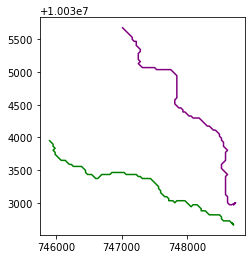

In [23]:
fig, ax = plt.subplots()
mainRLC.plot(ax=ax, color='green')
mainRMC.plot(ax=ax, color='purple')

We'll use the buffers of these rivers as catchments in themselves, for later consideration:

In [38]:
rlcCorridor = mainRLC.buffer(200)
rmcCorridor = mainRMC.buffer(200)

#rlcCorridor.to_file('GIS/rlcCorridor.geojson', driver='GeoJSON')
#rmcCorridor.to_file('GIS/rmcCorridor.geojson', driver='GeoJSON')

Now we make sub-watersheds from all the tributaries off of these two main branches. A function for making a geoseries with polygon geometry from a pyshed catchment. It takes a grid object and a tuple of (x,y). These coordinates can be approximate-but-close, we snap them to the high-accumulation cells in the grid:

In [25]:
def getCatchGPD(grid, coords):
    grid2 = copy.deepcopy(grid)
    snapX, snapY = grid.snap_to_mask(grid.acc > 50, coords, return_dist=False)
    grid2.catchment(y=snapY, x=snapX, data='dir', out_name=('littleCatch'),
                       recursionlimit=15000, xytype='label')
    grid2.clip_to('littleCatch')
    shapes = grid2.polygonize()
    lsh = list(shapes)
    aa = shapely.geometry.polygon.Polygon(lsh[0][0]['coordinates'][0])
    p = gpd.GeoSeries(aa)
    p = p.set_crs('EPSG:32717')
    return(p)

Here we put a small buffer around the main river stems, and find the intersection between the boundary of the buffer and the tributaries. These points of intersection become pourpoints for the sub-watersheds (catchments), using the `getCatchGPD` function:

In [26]:
### get RLC tributary catchments
mainRLC = gpd.read_file('GIS/mainRLC.geojson')
RLCgpd = gpd.read_file('GIS/rioLCpredicted.geojson')

## pour point for each tributary:
pourPtsPoly = mainRLC.buffer(50)
pourPts = pourPtsPoly.boundary.intersection(RLCgpd)
pourPts = pourPts.explode()
pourPts.reset_index(inplace=True, drop=True)

## make subwatersheds:
coords = [ i.coords[0] for i in pourPts ]
grid.clip_to('dem')

In [32]:
## this can be a little memory intensive:
rlccatchpolys = [ getCatchGPD(grid, i).geometry[0] for i in coords ]
RLCCatchPolys = gpd.GeoSeries(rlccatchpolys, crs='EPSG:32717')
#RLCCatchPolys.to_file('GIS/RLCCatchPolys.geojson', driver='GeoJSON')

The Rio Magdalena Chico is shaped very differently than the RLC. In the area of our study it doesn't have large tributaries into our area, but we can run the same pipeline on them:

In [27]:
### get RMC tributary catchments

## pour point for each tributary:
pourPtsPoly = mainRMC.buffer(50)
pourPts = pourPtsPoly.boundary.intersection(RMCgpd)
pourPts = pourPts.explode()
pourPts.reset_index(inplace=True, drop=True)

In [28]:
## make subwatersheds:
coords = [ i.coords[0] for i in pourPts ]
grid.clip_to('dem')
## this can be a little memory intensive:
rmccatchpolys = [ getCatchGPD(grid, i).geometry[0] for i in coords ]
RMCCatchPolys = gpd.GeoSeries(rmccatchpolys, crs='EPSG:32717')
#RMCCatchPolys.to_file('GIS/RMCCatchPolys.geojson', driver='GeoJSON')

Here is a map of the watersheds and river buffers:

In [6]:
def genXKCDColors(nu):
    Xcolors = random.choices(list(mcolors.XKCD_COLORS.values()), k=nu)
    cmap = mcolors.ListedColormap(Xcolors)
    return(cmap)

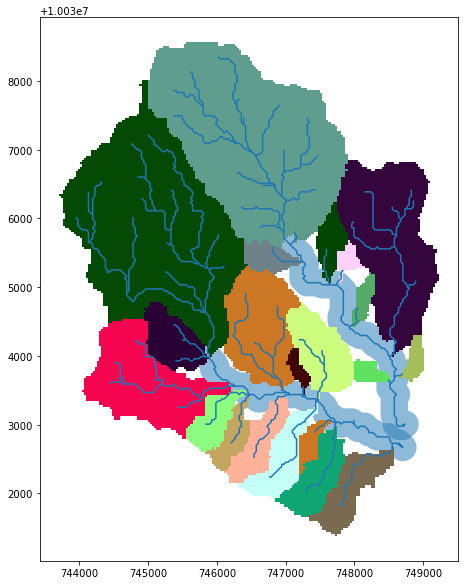

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
rlcCorridor.plot(ax=ax, alpha=0.5)
rmcCorridor.plot(ax=ax, alpha=0.5)
cmap=genXKCDColors(len(RMCCatchPolys))
RMCCatchPolys.plot(ax=ax, cmap=cmap)
cmap=genXKCDColors(len(RLCCatchPolys))
RLCCatchPolys.plot(ax=ax, cmap=cmap)
RMCgpd.plot(ax=ax)
RLCgpd.plot(ax=ax)

We need to hand-curate this a bit, for several reasons:

 1. these microcuencas are based on stream predictions generated from our DEM. There are some errors in these stream predictions, noted above, causing errors in the boundaries of the polygons of the microcuencas. 
 2. the Rio Los Cedros and Rio Magdalena Chico river buffers can't really act as satisfactory microcuencas, they don't behave the same as the other microcuencas. If left in, they act as centralizing highways, connecting all microcuencas to other other microcuencas within two jumps. This may be realistic at times, but in the steep and complex topography of los Cedros, I think keeping these river buffers makes the model of microcuencas less useful for testing the differences among microwatersheds. But getting rid of these river buffers leaves a lot of gaps
 
So here we hand curate the above polygons a bit with QGIS. Our layer for digitized is the georeferenced topographic map of los Cedros by the Instituto Geográfico Militar. The process is subjective at times, but generally follows the following rules:

1. Every tributary that directly enters the Rio Los Cedros and Rio Magdalena Chico from the south/west side gets its own watershed. These may be split, see #4. 

2. We only go as far as the waterfalls ("Old Waterfall" and "New Waterfall") roughly. Meaning that for now the watersheds of the upper Rio Los Cedros and upper Rio Magdalena Chico are left alone. They are too big, but it doesn't matter because, only their lower regions affect the topology of the graph of polygons (defined below). 

3. The boundaries of out initial, automatically-generated watershed polygons are hand-curated to match the contours and observed actual river shape from the topographic map.

3. where significant sub-watersheds remain hidden,  we "crept up" the buffer size from the stream to split them. As in, the first candidate for splitting is from the "bottom-up" of a stream, by expanding buffers around streams until intersecting with new entry-points for tributaries. The first, and only, splitting event of this type occurred by increasing the river buffer from 50m to 200m, resulting in a new sub-watershed in the north central portion of the RLC watershed (microcuenca #5). 

4. We try to eliminate the RLC river buffer, as in it does not get its own watershed status, and other watersheds are expanded within reason down to the river. This is to bring watersheds that are directly across from each other on the rivers. But this is not forced beyond a reasonable extent, such that we do not attempt to cover all surface area of the map, there are blank areas allowed that do not belong to any watershed. Technically these are tiny microcuencas that feed directly into the river, but they do not affect the topology of the polygon graph and there are no points in them. 

5. Several of the watersheds above are out of the scope of the study, so these are trimmed. Basically every watershed on the north/east side of the Rio Magdalena Chico.  

The magdalena chico is really tough. It is one long strip of really steep mountainside, with a few small streams. There are some large flats that are pasture, and some really steep hillsides. If we consider it one continuous watershed, this seems incongruous with our microcuencas carved from the RLC. For the moment, I have basically considered the RMC a single watershed, but I broke it apart at an especially steep cliff. I also took the liberty of including the points in the southeast portion of Ana's study,  even though they are across the RMC. Some inconsistencies, but I think they are in the spirit of testing the general idea that it is hard to get around in the tropical Andes, slowing dispersal. 

Anyway, looks like this: 

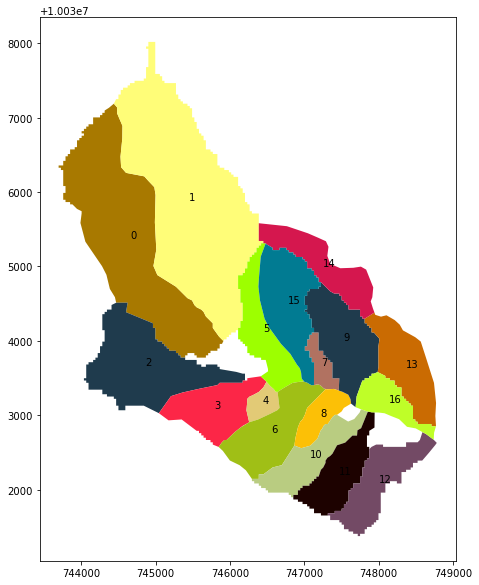

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
colmap = genXKCDColors(curatedMicrocuencas.shape[0])
curatedMicrocuencas.plot(ax=ax, cmap=colmap)
for i in curatedMicrocuencas.index:
    ax.annotate(s=i,
                xy=curatedMicrocuencas.loc[i][0].centroid.coords[0],
                )


[back to top](#contents)

<a id='microcuencaDistanceMatrix'></a>
#### Making a distance matrix from microcuenca map

The goal here is get a distance matrix that shows how many small watersheds one has to cross to arrive at each sample site from every other sample site. From here we treat this map of microcuencas as a graph, where each polygon is a node, and every shared boundary between polygons is an edge (link). To make our adjacency matrix for the graph, we'll use shapely predicates on the polygons:

In [10]:
def checkAdjacency(microcuencaA, microcuencaB):
    '''use two, single row geoseries'''
    if microcuencaA[0].touches(microcuencaB[0]):
        a=True
    elif microcuencaA[0].intersects(microcuencaB[0]):
        a=True
    elif microcuencaA[0].overlaps(microcuencaB[0]):
        a=True
    else: a=False
    return(a)

In [13]:
lOfadj = []
for j in curatedMicrocuencas.index:
    lOfadj.append(
        [ checkAdjacency(curatedMicrocuencas.iloc[i], curatedMicrocuencas.iloc[j]) for i in curatedMicrocuencas.index ]
        )

## so this should be our adjaceny matrix:
adjMat = pd.DataFrame(lOfadj)

In [14]:
adjMat

0      1      2      3      4      5      6      7      8      9   \
0    True   True   True  False  False  False  False  False  False  False   
1    True   True  False  False  False   True  False  False  False  False   
2    True  False   True   True  False  False  False  False  False  False   
3   False  False   True   True   True   True   True  False  False  False   
4   False  False  False   True   True   True   True  False  False  False   
5   False   True  False   True   True   True   True  False  False  False   
6   False  False  False   True   True   True   True   True   True  False   
7   False  False  False  False  False  False   True   True   True   True   
8   False  False  False  False  False  False   True   True   True   True   
9   False  False  False  False  False  False  False   True   True   True   
10  False  False  False  False  False  False   True  False   True  False   
11  False  False  False  False  False  False  False  False  False  False   
12  False  False  False  False  False  False  False  False  False  False   
13  False  False  False  False  False  False  False  False  False   True   
14  False   True  False  False  False   True  False  False  False   True   
15  False  False  False  False  False   True   True   True  False   True   
16  False  False  False  False  False  False  False  False  False   True   

       10     11     12     13     14     15     16  
0   False  False  False  False  False  False  False  
1   False  False  False  False   True  False  False  
2   False  False  False  False  False  False  False  
3   False  False  False  False  False  False  False  
4   False  False  False  False  False  False  False  
5   False  False  False  False   True   True  False  
6    True  False  False  False  False   True  False  
7   False  False  False  False  False   True  False  
8    True  False  False  False  False  False  False  
9   False  False  False   True   True   True   True  
10   True   True  False  False  False  False   True  
11   True   True   True  False  False  False   True  
12  False   True   True  False  False  False   True  
13  False  False  False   True   True  False   True  
14  False  False  False   True   True   True  False  
15  False  False  False  False   True   True  False  
16   True   True   True   True  False  False   True

We can use the [NetworkX](https://networkx.org) package to turn this into a network graph and do some simple analysis: 

In [17]:
gMicrocuencas = networkx.from_pandas_adjacency(adjMat)
print(networkx.info(gMicrocuencas))

Name: 
Type: Graph
Number of nodes: 17
Number of edges: 51
Average degree:   6.0000


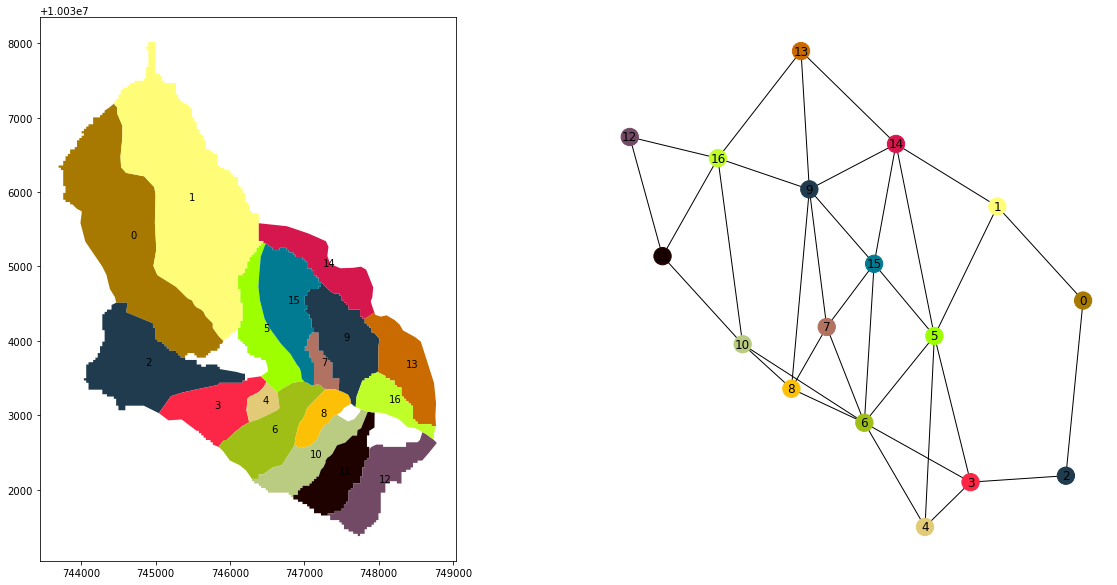

In [23]:
layout = networkx.spring_layout(gMicrocuencas)

fig, ax = plt.subplots(1,2, figsize=(20,10))
#colmap = genXKCDColors(curatedMicrocuencas.shape[0])
curatedMicrocuencas.plot(ax=ax[0], cmap=colmap)
for i in curatedMicrocuencas.index:
    ax[0].annotate(s=i,
                xy=curatedMicrocuencas.loc[i][0].centroid.coords[0],
                )

## reuse our colormap 
networkx.draw(gMicrocuencas,
              layout,
              with_labels=True,
              node_color=colmap.colors,
              ax=ax[1])


NetworkX has djikstra's algorithm for finding shortest paths, we can use it for creating a distance matrix among the microcuencas, in units of "hops" through other watersheds:

In [24]:
jumps = []
for j in range(17):
    jumps.append([ networkx.dijkstra_path_length(gMicrocuencas, i, j) for i in range(17) ])

watershedDistMat = pd.DataFrame(jumps)
#watershedDistMat.to_csv('watershedDistMat.csv')
## note that when that is reloaded, you need to change column names 
## back to integers (reading from CSV turns them into strings)

In [13]:
watershedDistMat

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0    0   1   1   2   3   2   3   4   4   3   4   5   5   3   2   3   4
1    1   0   2   2   2   1   2   3   3   2   3   4   4   2   1   2   3
2    1   2   0   1   2   2   2   3   3   4   3   4   5   4   3   3   4
3    2   2   1   0   1   1   1   2   2   3   2   3   4   3   2   2   3
4    3   2   2   1   0   1   1   2   2   3   2   3   4   3   2   2   3
5    2   1   2   1   1   0   1   2   2   2   2   3   4   2   1   1   3
6    3   2   2   1   1   1   0   1   1   2   1   2   3   3   2   1   2
7    4   3   3   2   2   2   1   0   1   1   2   3   3   2   2   1   2
8    4   3   3   2   2   2   1   1   0   1   1   2   3   2   2   2   2
9    3   2   4   3   3   2   2   1   1   0   2   2   2   1   1   1   1
10   4   3   3   2   2   2   1   2   1   2   0   1   2   2   3   2   1
11   5   4   4   3   3   3   2   3   2   2   1   0   1   2   3   3   1
12   5   4   5   4   4   4   3   3   3   2   2   1   0   2   3   3   1
13   3   2   4   3   3   2   3   2   2   1   2   2   2   0   1   2   1
14   2   1   3   2   2   1   2   2   2   1   3   3   3   1   0   1   2
15   3   2   3   2   2   1   1   1   2   1   2   3   3   2   1   0   2
16   4   3   4   3   3   3   2   2   2   1   1   1   1   1   2   2   0

We can use this to find the distance between sample sites. But we need to assign each sample site to a watershed:

In [14]:
aa = anaPt.set_index('PsubP')
bb = aa.geometry.apply(lambda x: curatedMicrocuencas.contains(x))

In [15]:
bb.head()

0      1      2      3      4      5      6      7      8      9   \
PsubP                                                                         
1.1    False  False  False  False  False  False  False  False  False  False   
1.2    False  False  False  False  False  False  False  False  False   True   
1.3    False  False  False  False  False  False  False  False  False   True   
1.4    False  False  False  False  False  False  False  False  False   True   
1.5    False  False  False  False  False  False  False  False  False   True   

          10     11     12     13     14     15     16  
PsubP                                                   
1.1    False  False  False   True  False  False  False  
1.2    False  False  False  False  False  False  False  
1.3    False  False  False  False  False  False  False  
1.4    False  False  False  False  False  False  False  
1.5    False  False  False  False  False  False  False

In [16]:
## do all sample sites belong to one - and only one - microcuenca?
(bb.sum(axis=1) == 1).all()

True

Great, but let's flatten it to a single column that describes to which microcuenca each one belongs:

In [17]:
cc = pd.melt(bb, var_name='microcuenca', ignore_index=False)
dd = (cc[cc.value]
        .drop('value', axis=1).sort_index())


In [18]:
dd

microcuenca
PsubP             
1.1             13
1.2              9
1.3              9
1.4              9
1.5              9
...            ...
9.9              2
10.1             9
10.2             9
10.3             7
10.4             7

[61 rows x 1 columns]

This can be added to our environmental matrix:

In [19]:
envOnly = pd.read_csv('envOnly.csv', index_col='PsubP')
envOnly['microcuenca'] = dd['microcuenca']
#envOnly.to_csv('envOnly.csv')

and now we can use our dataframe of microcuenca "hops" to look up the distance in hops between each sample site: 

In [21]:
psubpHops = []
for i in envOnly.microcuenca:
    psubpHops.append(
        [ watershedDistMat.loc[i, j] for j in envOnly.microcuenca ]
    )
psubpHopsDF = pd.DataFrame(psubpHops, index=envOnly.index, columns=envOnly.index)

In [23]:
psubpHopsDF

PsubP  1.1   1.2   1.3   1.4   1.5   2.1   2.2   2.3   2.4   3.1   ...  9.4   \
PsubP                                                              ...         
1.1       0     1     1     1     1     0     0     0     0     2  ...     3   
1.2       1     0     0     0     0     1     1     1     1     1  ...     3   
1.3       1     0     0     0     0     1     1     1     1     1  ...     3   
1.4       1     0     0     0     0     1     1     1     1     1  ...     3   
1.5       1     0     0     0     0     1     1     1     1     1  ...     3   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
9.9       4     4     4     4     4     4     4     4     4     3  ...     1   
10.1      1     0     0     0     0     1     1     1     1     1  ...     3   
10.2      1     0     0     0     0     1     1     1     1     1  ...     3   
10.3      2     1     1     1     1     2     2     2     2     1  ...     2   
10.4      2     1     1     1     1     2     2     2     2     1  ...     2   

PsubP  9.5   9.6   9.7   9.8   9.9   10.1  10.2  10.3  10.4  
PsubP                                                        
1.1       4     4     3     4     4     1     1     2     2  
1.2       4     4     3     4     4     0     0     1     1  
1.3       4     4     3     4     4     0     0     1     1  
1.4       4     4     3     4     4     0     0     1     1  
1.5       4     4     3     4     4     0     0     1     1  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
9.9       0     0     1     0     0     4     4     3     3  
10.1      4     4     3     4     4     0     0     1     1  
10.2      4     4     3     4     4     0     0     1     1  
10.3      3     3     2     3     3     1     1     0     0  
10.4      3     3     2     3     3     1     1     0     0  

[61 rows x 61 columns]

This is our microcuenca distance matrix, basically. We'll use this above, where we examine turnover in tree community structure.

[back to top](#contents)

<a id='indSpp'></a>

### Indicator species analysis

Let's look to see if we pick up any obvious indicator species for either the habitat types (clearing, bosque secondario, regenerating finca sites, etc) or for our clustering results. Back in R:

In [1]:
library(indicspecies)

Loading required package: permute



In [11]:
## our community matrix...
comM <- read.csv('subParcelComm.csv')
rownames(comM) <- comM$PsubP

## general plant observation dataframe
specObs <- read.csv('specObs.csv', row.names=1)
## make a PsubP/habitat dataframe:
habs <- unique(specObs[,c('PsubP','habitat')])
rownames(habs) <- NULL

## and our cluster groups:
cldf <- read.csv('cGroup.csv')

## make sure they are the same order
habs <- habs[order(habs$PsubP),]
comM <- comM[order(comM$PsubP),]
cldf <- cldf[order(cldf$PsubP),]
all(habs$PsubP == comM$PsubP)
all(habs$PsubP == rownames(comM))
all(cldf$PsubP == rownames(comM))

## now we can make a vector of our habs dataframe:
habsV <- habs$habitat
clV <- cldf$gr

## clean up extra column of com matrix, careful with this
comM <- comM[,-1] ## get rid of PsubP

[1] TRUE

[1] TRUE

[1] TRUE

In [12]:
habIndSpp <- multipatt(comM, habsV, func = 'r.g', control=how(nperm=9999))

clustIndSpp <- multipatt(comM, clV, func = 'r.g', control=how(nperm=9999))

In [13]:
summary(habIndSpp)


 Multilevel pattern analysis
 ---------------------------

 Association function: r.g
 Significance level (alpha): 0.05

 Total number of species: 343
 Selected number of species: 24 
 Number of species associated to 1 group: 20 
 Number of species associated to 2 groups: 3 
 Number of species associated to 3 groups: 1 
 Number of species associated to 4 groups: 0 

 List of species associated to each combination: 

 Group BC  #sps.  1 
                              stat p.value  
Moraceae.Pseudolmedia.rigida 0.423  0.0332 *

 Group BS  #sps.  3 
                                    stat p.value  
Rubiaceae.Psychotria.paeonia       0.478  0.0153 *
Lauraceae.Persea.pseudofasciculata 0.432  0.0351 *
Myrtaceae.Myrcia.aff..aliena       0.425  0.0337 *

 Group CLB  #sps.  1 
                                    stat p.value  
Lauraceae.Endlicheria.cf..chalisea 0.431  0.0315 *

 Group RCA  #sps.  11 
                                          stat p.value    
Boraginaceae.Cordia.colombiana    

In [14]:
summary(clustIndSpp)


 Multilevel pattern analysis
 ---------------------------

 Association function: r.g
 Significance level (alpha): 0.05

 Total number of species: 343
 Selected number of species: 48 
 Number of species associated to 1 group: 32 
 Number of species associated to 2 groups: 16 
 Number of species associated to 3 groups: 0 

 List of species associated to each combination: 

 Group 1  #sps.  9 
                                         stat p.value    
Boraginaceae.Cordia.colombiana          0.661  0.0001 ***
Melastomataceae.Meriania.tomentosa      0.641  0.0001 ***
Actinidaceae.Saurauia.sp..1             0.545  0.0002 ***
Cyatheaceae.Cyathea.halonata            0.458  0.0037 ** 
Fab.Caesalpiniaceae.Senna.dariensis     0.449  0.0054 ** 
Moraceae.Ficus.caldasiana               0.420  0.0210 *  
Melastomataceae.Leandra.subseriata      0.370  0.0167 *  
Melastomataceae.Miconia.aff..brevitheca 0.368  0.0221 *  
Staphyleaceae.Turpinia.occidentalis     0.346  0.0425 *  

 Group 2  #sps.  5 
   

We'll make some notes on the species oberved in these groups here. This can probably be removed once entered into the manuscript body, just need to keep it for a moment:

#### Group 1:  
<i><b> Senna dariensis</i></b> - is well documented at STRI in Panama, from roadsides and natural clearings. STRI Entry is [here](https://stricollections.org/portal/taxa/index.php?tid=69569).

<i><b>Turpinia occidentalis</i></b> is known from throughout the Chocó it seems. Not necessarily weedy, but not an endemic, for sure. [STRI entry](#https://stricollections.org/portal/taxa/index.php?taxon=Turpinia+occidentalis&formsubmit=Search+Terms).

<i><b> Saurauia </b></i> spp. are just weedy and everybody knows it. Gentry can be cited on this if need be.

#### Group 4:
<i><b>Garcinia macrophylla</i></b> almost certainly [primate distributed](https://doi.org/10.1002/(SICI)1098-2345(200004)50:4%3C275::AID-AJP4%3E3.0.CO;2-K), large seeds.

<i><b> </i></b>




[back to top](#contents)

<a id='mantel'></a>

### Mantel tests

Let's check the estimations of spatial autocorrelation in the plant community with mantel correlograms/tests.

In [41]:
library('vegan')
library('ecodist')

pts <- read.csv('pts.csv', row.names='PsubP')

physdist <- vegdist(pts, method='euclidean')
## make the community dissimilarity matrix
bb <- read.csv('subParcelComm.csv')
bb <- bb[order(bb$PsubP),]
row.names(bb) <- bb$PsubP
bb <- bb[,-1]
all(aa$PsubP == rownames(bb))
braydist <- vegdist(bb, method='bray')
## do the global test:
global_mant_test <- mantel(braydist ~ physdist, nperm = 10000) ## overall test
global_mant_test 

[1] TRUE

mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.2377790  0.0001000  1.0000000  0.0001000  0.2013864  0.2722124

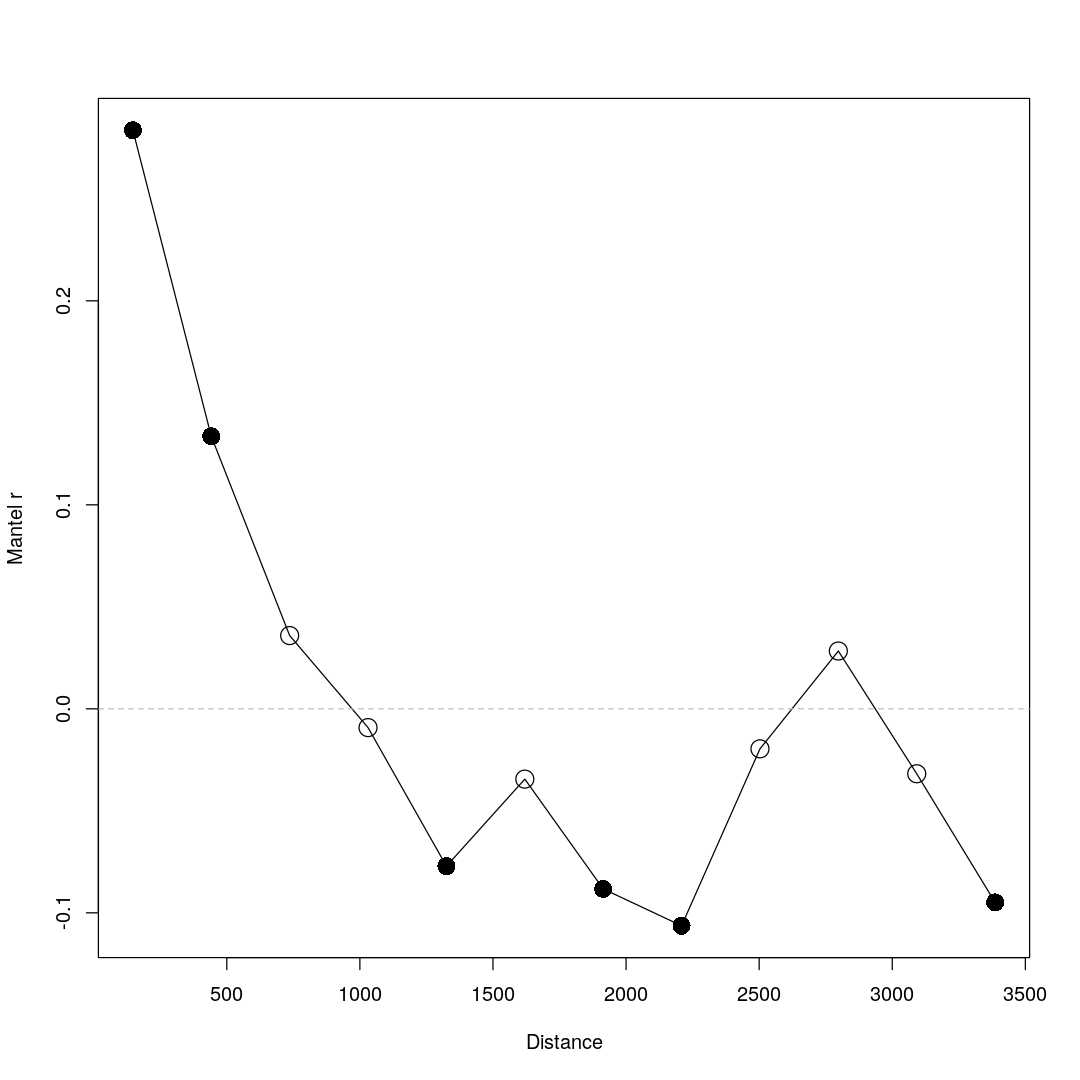

In [42]:
## correlogram
options(repr.plot.width=9, repr.plot.height=9)
cgram <- mgram(braydist, physdist) ## correlogram object
plot(cgram)

Okay w

In [43]:
getDists <- function(comfile, physfile='pts.csv'){
    comM <- read.csv(comfile, row.names=1)
    comM <- comM[order(as.numeric((rownames(comM)))),]
    spM <- read.csv(physfile, row.names=1)
    spM <- spM[order(rownames(spM)),]
    physdist <- vegdist(spM, method='euclidean')
    spM <- spM[rownames(spM)%in%rownames(comM),]
    spM <- spM[order(as.numeric((rownames(spM)))),]
    if(all(rownames(spM) == rownames(comM))){
        physdist <- vegdist(spM, method='euclidean')
        braydist <- vegdist(comM, method='bray')
        return(list(braydist, physdist))
        } else {print("something doesn't fit right")}
    }


In [55]:
getDists <- function(comfile, physfile='finalReport2012Coords.csv'){
    comM <- read.csv(comfile, row.names=1)
    comM <- comM[order(as.numeric((rownames(comM)))),]
    spM <- read.csv('finalReport2012Coords.csv')[,-2]
    spM <- spM[order(spM$PsubP),]
    rownames(spM) <- spM$PsubP
    spM <- spM[,-1]
    physdist <- vegdist(spM, method='euclidean')
    spM <- spM[rownames(spM)%in%rownames(comM),]
    spM <- spM[order(as.numeric((rownames(comM)))),]
    if(all(rownames(spM) == rownames(comM))){
        physdist <- vegdist(spM, method='euclidean')
        braydist <- vegdist(comM, method='bray')
        return(list(braydist, physdist))
        }
    else{print("something doesn't fit right")}
    }


[1] "BC_comm.csv"
[1] "BS_comm.csv"
[1] "CLB_comm.csv"
[1] "RCA_comm.csv"
[1] "RG_comm.csv"


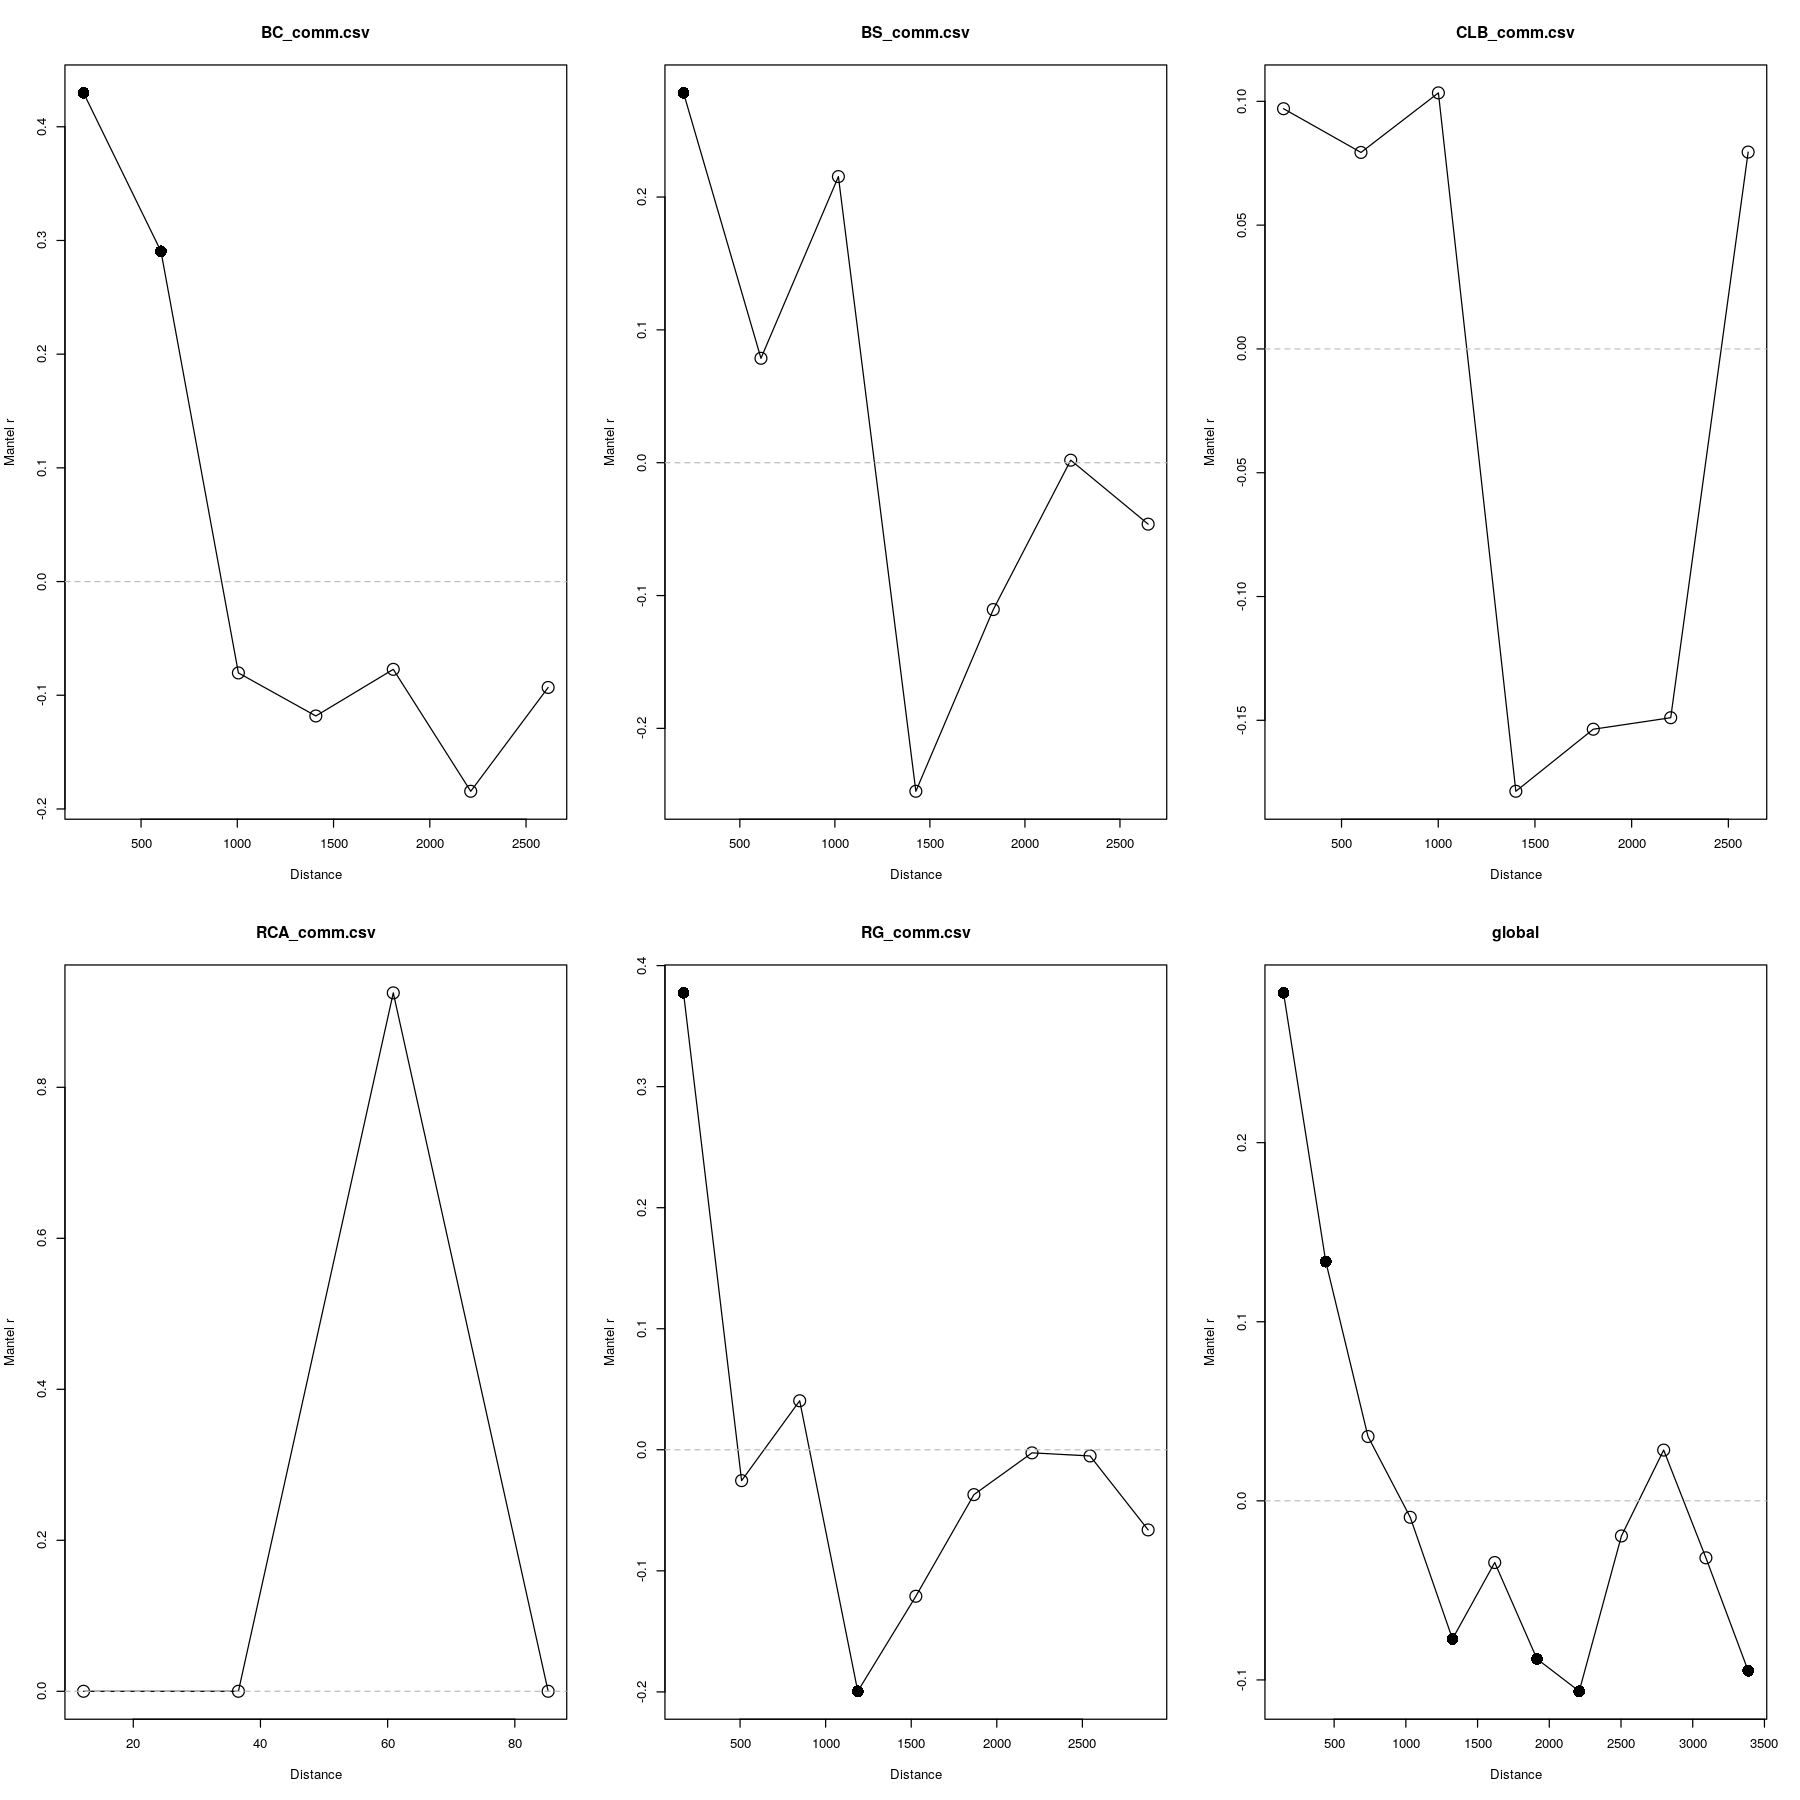

In [44]:
options(repr.plot.width=15, repr.plot.height=15)

## filenames
comms <- c('BC_comm.csv', 'BS_comm.csv', 'CLB_comm.csv', 'RCA_comm.csv', 'RG_comm.csv')
## start df
all_mant_test  <- global_mant_test

## test individually
par(mfrow=c(2,3))
for (i in 1:length(comms)){
    print(comms[i])
    dists.i <- getDists(comms[i])
    cgram.i <- mgram(dists.i[[1]], dists.i[[2]]) ## correlogram object
    plot(cgram.i, main = comms[i] )
    mant_test.i <- mantel(dists.i[[1]] ~ dists.i[[2]], nperm = 10000) ## overall test
    all_mant_test <- rbind(mant_test.i, all_mant_test)
}
plot(cgram, main = "global" )


In [47]:
rownames(all_mant_test) <- c(rev(comms), "global")
all_mant_test[c(5,4,3,2,1,6),]

mantelr    pval1  pval2  pval3  llim.2.5%  ulim.97.5%
BC_comm.csv  0.43360085 0.0030 0.9971 0.0030  0.3453213 0.5027305 
BS_comm.csv  0.28107333 0.0322 0.9679 0.0329  0.1760572 0.3930036 
CLB_comm.csv 0.03913118 0.3428 0.6573 0.7462 -0.1390429 0.1956787 
RCA_comm.csv 0.63448996 0.2933 0.7495 0.3385  0.5470088 0.9820520 
RG_comm.csv  0.25342715 0.0062 0.9939 0.0062  0.1828187 0.3481677 
global       0.23777902 0.0001 1.0000 0.0001  0.2013864 0.2722124

The RCA plots have a negative trend in autocorrelation - there is a homogenizing effect somewhere on them, plots that are far away are more similar that you would expect. Bosques cerrados are highly positively autocorrelated, the most autocorrelated type of the habitat in the system.

We can take a look at how the old forest sites behave as group, also:

In [46]:
options(repr.plot.width=8, repr.plot.height=8)

specObs <- read.csv('specObs.csv', row.names=1)
## make a PsubP/habitat dataframe:
habs <- unique(specObs[,c('PsubP','habitat')])
## order by site
habs <- habs[order(habs$Psub),]
rownames(habs) <- NULL
## find old forest subparcels
PsubPoldForest <- habs$habitat != 'RCA' & habs$habitat != 'RG'

aa <- read.csv('finalReport2012Coords.csv')[,-2]
aa <- aa[order(aa$PsubP),]
rownames(aa) <- aa$PsubP
aa <- aa[,-1]

bb <- read.csv('subParcelComm.csv')
bb <- bb[order(bb$PsubP),]
rownames(bb) <- bb$PsubP

all(habs$PsubP == aa$PsubP)
all(habs$PsubP == bb$PsubP)
## subset these:
aa <- aa[PsubPoldForest,]
bb <- bb[PsubPoldForest,]
all(rownames(aa) == rownames(bb))

[1] TRUE

[1] TRUE

[1] TRUE

mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.3764229  0.0001000  1.0000000  0.0001000  0.3236591  0.4347705

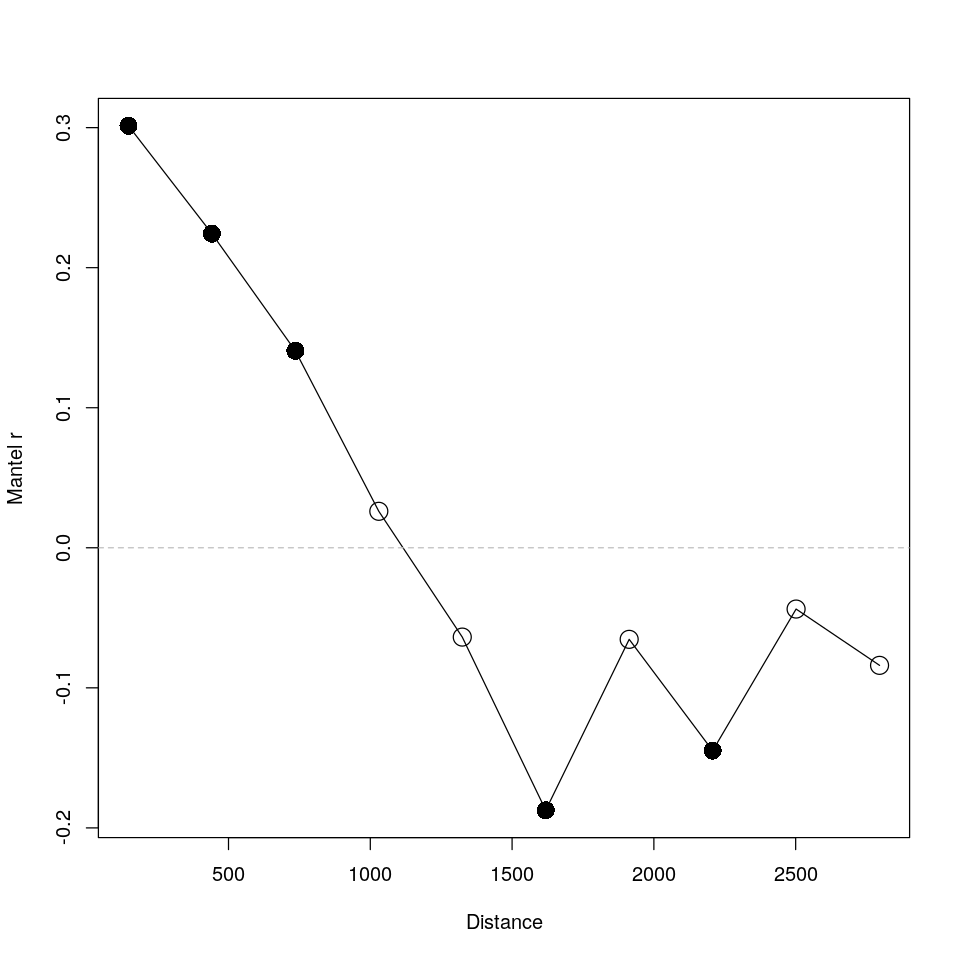

In [71]:
## make dist objects
physdist <- vegdist(aa, method='euclidean')
braydist <- vegdist(bb, method='bray')
cgram <- mgram(braydist, physdist) ## correlogram object
plot(cgram)
mant_test <- mantel(braydist ~ physdist, nperm = 10000) ## overall test
mant_test

When we subset to just the old forest subplots, there are clear signs of positive autocorrelation until ~1000 m. Following this, we again find some sort of homogenizing effect in 1500-2200 m. I'd guess the negative autocorrelation has to do with the layout of the plots: many of the plots are clustered, and the clusters are ~1000 m apart. This may also have something to do with the locations of the two types of forest - because of elevation the two forest types may be coupled (and therefore different) on a pretty local spatial scale, but once enough distance is covered, and the valleys/ridges are scaled, the test encounters similar habitat again. Not sure. But we can try to look a little closer with PCNMs. 

[back to top](#contents)

<a id="mem"></a>
### MEM spatial analysis (all points)

Let's look at the spatial patterns with a more refined tool than the mantel tests. I think of mantel tests as sledge hammers: if there is an obvious spatial pattern going on in your system, take a swing with a mantel's R correlogram and you may hit it. But here we have a different family of approaches, [MEM](https://cran.r-project.org/web/packages/adespatial/vignettes/tutorial.html). 

<img src="MEMDiagram.png">

(Image from the tutorial linked above, by Dray) 

This method is eigen-decomposition-based. First we created a spatially-weighted neighborhood matrix (SWM), where all neighbors to each of our points are defined and ranked according to their distance. Turns out that if you take the eigen vectors and values of a diagonalized SWM, you get a list of eigen values that are equal to a Moran's I (the geographer's correlation coefficient) and a list of eigenvectors that are orthoganal to each other, so that they can act as independent spatial variables in linear models. This is the current solution to the riddle of spatial patterns - spatial trends classically muck up linear models badly: if they are not addressed, they cause false positives in other correlations because of autocorrelation, and spatial patterns of different scales are hard to quantify or separate from one another into terms of a model. With MEM methods, we can start to get a handle on finding, quantifying, and modeling spatial patterns, with other variables.

In [1]:
library(vegan)
library(ade4)
library(adespatial)
library(adegraphics)
library(spdep)
library(maptools)
library(sp)


Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6

Registered S3 methods overwritten by 'adegraphics':
  method         from
  biplot.dudi    ade4
  kplot.foucart  ade4
  kplot.mcoa     ade4
  kplot.mfa      ade4
  kplot.pta      ade4
  kplot.sepan    ade4
  kplot.statis   ade4
  scatter.coa    ade4
  scatter.dudi   ade4
  scatter.nipals ade4
  scatter.pco    ade4
  score.acm      ade4
  score.mix      ade4
  score.pca      ade4
  screeplot.dudi ade4



ERROR: Error: package or namespace load failed for ‘adespatial’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/usr/local/lib/R/site-library/igraph/libs/igraph.so':
  libgfortran.so.4: cannot open shared object file: No such file or directory


Start by getting our spatial data in place:

In [2]:
## get data:
pts <- read.csv('pts.csv', row.names='PsubP')
env <- read.csv('envOnly.csv', row.names='PsubP')
comM <- read.csv('subParcelComm.csv', row.names="PsubP")
## are these in order?
all(rownames(comM) == rownames(pts))
all(rownames(comM) == rownames(env))

[1] TRUE

[1] TRUE

In [3]:
load('lcPoly.rda')

In [4]:
s.label(pts, labels=row.names(pts), ppoint.col = "darkseagreen4", Sp = lcPoly)

ERROR: Error in s.label(pts, labels = row.names(pts), ppoint.col = "darkseagreen4", : unused arguments (labels = row.names(pts), ppoint.col = "darkseagreen4", Sp = lcPoly)


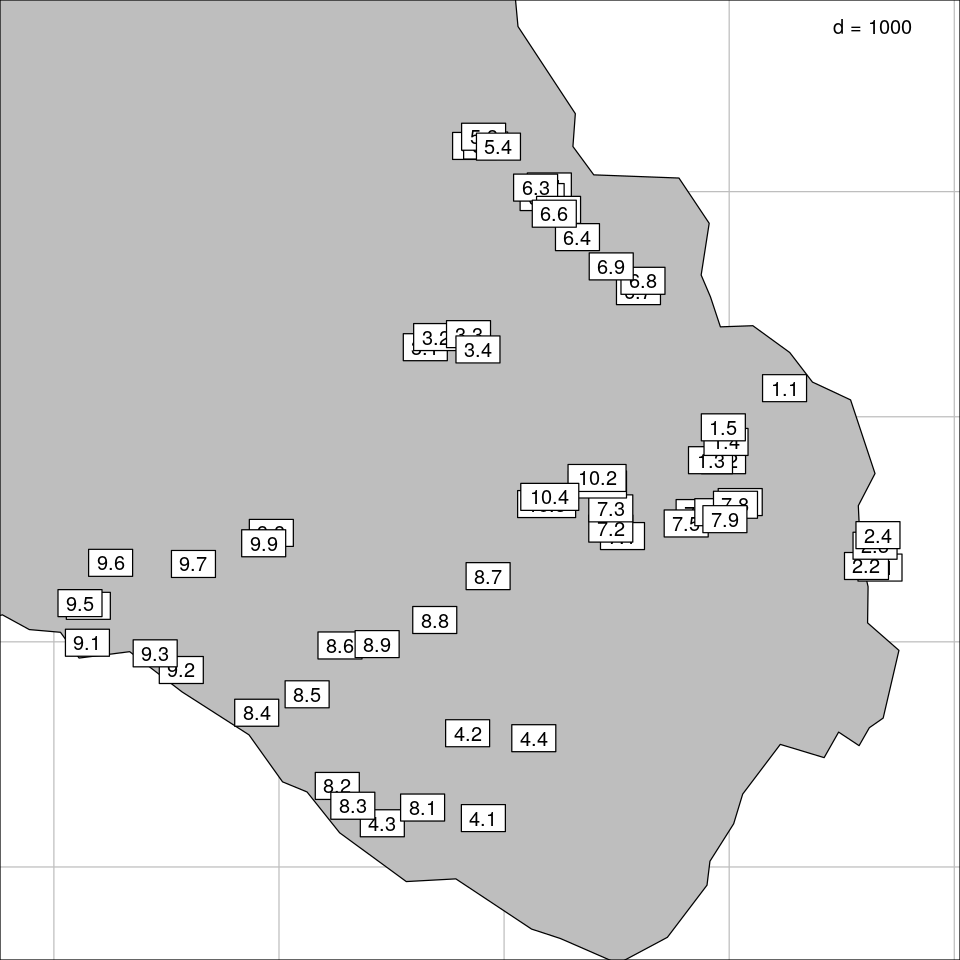

In [58]:
load('lcPoly.rda')
## sanity plot check:
s.label(pts[,2:3], labels=pts$PsubP, ppoint.col = "darkseagreen4", Sp = lcPoly)

Let's bring our points down to the axes. It seems to mess with the adegraphics plotting setup if we using the full UTM coordinates.

In [68]:
pJ <- as.matrix(pts[,2:3])
colnames(pJ) <- c('x','y')

mx <- min(pJ[,1])
my <- min(pJ[,2])
pJ <- cbind(pJ[,1] - mx, pJ[,2] - my)
rownames(pJ) <- pts$PsubP

In [110]:
## these might be handy later:
ptsmxmy <- c(mx,my)
#save(ptsmxmy, file='ptsmxmy.rda')

Make our SWM:

In [69]:
## choose neighborhood type. "2" = gabriel:
nb <- chooseCN(coordinates(pJ), type = 2, plot.nb = FALSE)
## get the distances of each link:
distnb <- nbdists(nb, coordinates(pJ))
## weight them, by their length. Here a linear weighting:
fdist <- lapply(distnb, function(x) 1 - x/max(dist(pJ)))
## combine nb and fdist: 
lw <- nb2listw(nb, style = 'W', glist = fdist, zero.policy = TRUE)

We used a "Gabriel" method to construct our neighborhoods. Looks like this:

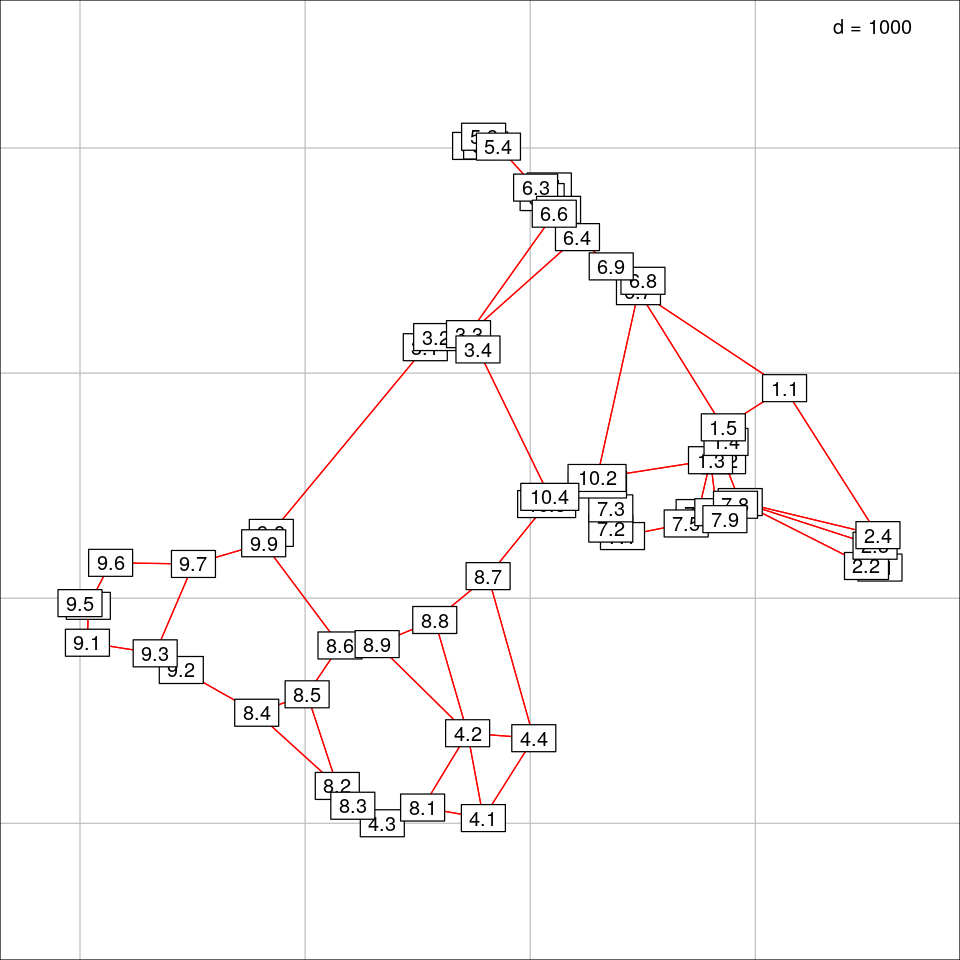

In [72]:
s.label(pJ, nb=nb, pnb.edge.col='red')

We weighted these links by distance, and now we can run the MEM construction on the weighted matrix of neighbors:

In [73]:
mem.lw <- mem(lw)

Take a look at some of them. They are constructed in order of "size", meaning the spatial scale that they can detect. 

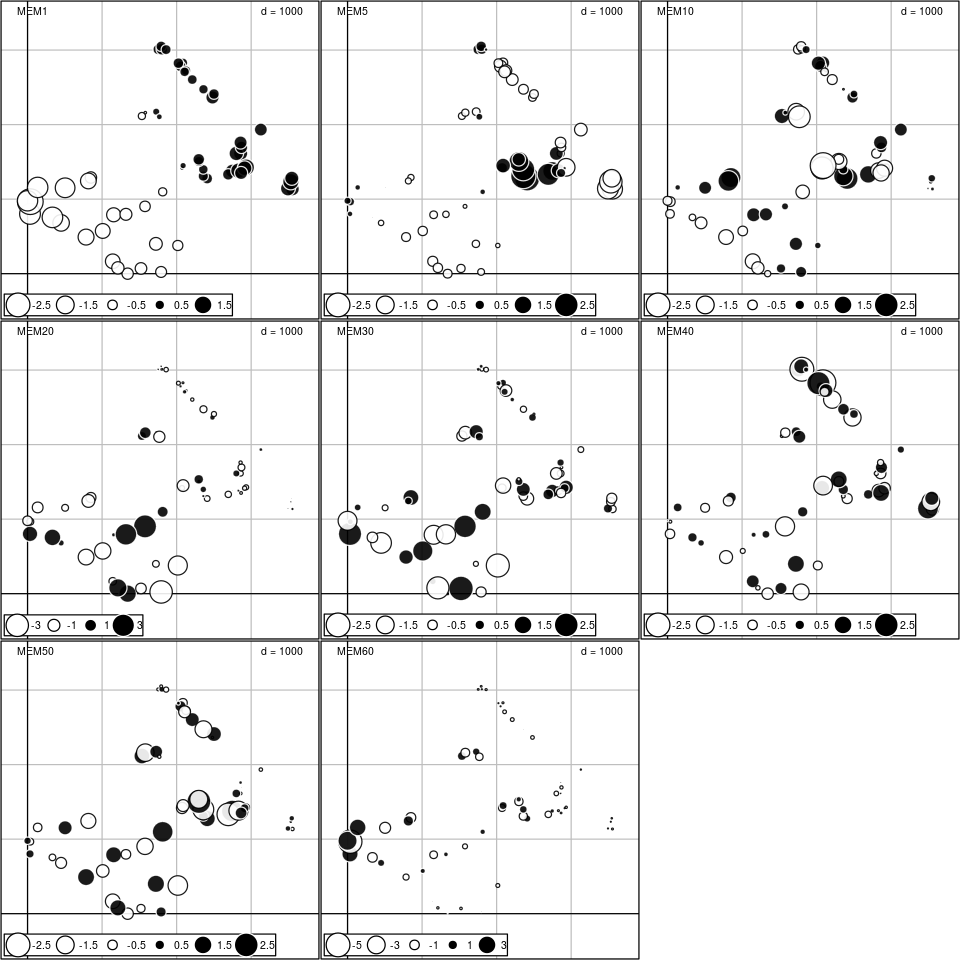

In [74]:
s.value(pJ, mem.lw[,c(1, 5, 10, 20, 30, 40, 50, 60)], symbol="circle")

There are almost as many of these MEMs as there are points on our map of plots. Right now they are meaningless, they are simply different patterns that could be useful, that we can test against our data. 

So we have to subset to ones that seem to reflect changes in space of our plant community. We need to do some model selection - running different combinations of the MEMs as models explaining changes in our community matrix, and finding only the ones that seem to explain some variance in our community, balanced by a need for simplicity (avoiding retaining too many MEMs to avoid overfitting). 

The best, currently-available tool for model-selection of MEMS is in the ade4 package, the "mem.select" function. It is frequentist, meaning that it first checks for global significance of the MEMS, with a default alpha cutoffs of 0.05, and with heavy penalties for multiple testing. This causes some small problems, it puts a sort of moral stop on checking out the individual MEMs as informative or not. But this is the tool that is available. 

First, we need to simplify our community matrix a bit, to use an explanatory variable to test the importance of our MEMS. We run a hellinger standardization and pick some important PCA axes out of this matrix:

In [75]:
comM.hell <- decostand(comM, 'hellinger')
pca.hell <- dudi.pca(df = comM.hell, scale = FALSE, scannf = FALSE, nf = 4)

We can check our MEMs against these new axes. 

In [76]:
mem.comM.sel <- mem.select(pca.hell$tab,
    method="FWD",
    listw = lw,
    nperm=9999,
    )

Procedure stopped (alpha criteria): pvalue for variable 14 is 0.111600 (> 0.050000)


In [77]:
mem.comM.sel$summary

variables order R2         R2Cum      AdjR2Cum   pvalue
1  MEM2       2    0.04265480 0.04265480 0.02642861 0.0001
2  MEM1       1    0.04115028 0.08380508 0.05221215 0.0001
3  MEM8       8    0.03590965 0.11971473 0.07338392 0.0002
4  MEM10     10    0.03091845 0.15063318 0.08996412 0.0010
5  MEM3       3    0.03051204 0.18114522 0.10670387 0.0005
6  MEM12     12    0.02660190 0.20774712 0.11971902 0.0025
7  MEM5       5    0.02470054 0.23244766 0.13107282 0.0031
8  MEM9       9    0.02393299 0.25638065 0.14197767 0.0037
9  MEM13     13    0.02336687 0.27974752 0.15264414 0.0056
10 MEM6       6    0.02319278 0.30294030 0.16352836 0.0034
11 MEM7       7    0.02263385 0.32557415 0.17417243 0.0022
12 MEM11     11    0.02015320 0.34572735 0.18215919 0.0098
13 MEM4       4    0.01979522 0.36552257 0.19002882 0.0102

For the record, if we do try to relax this alpha?

In [79]:
mem.comM.sel.p20 <- mem.select(pca.hell$tab, method="FWD", listw = lw, alpha=0.2)

Procedure stopped (alpha criteria): pvalue for variable 14 is 0.130000 (> 0.050000)


In [80]:
mem.comM.sel.p20$summary

variables order R2         R2Cum      AdjR2Cum   pvalue
1  MEM2       2    0.04265480 0.04265480 0.02642861 0.001 
2  MEM1       1    0.04115028 0.08380508 0.05221215 0.001 
3  MEM8       8    0.03590965 0.11971473 0.07338392 0.001 
4  MEM10     10    0.03091845 0.15063318 0.08996412 0.001 
5  MEM3       3    0.03051204 0.18114522 0.10670387 0.001 
6  MEM12     12    0.02660190 0.20774712 0.11971902 0.006 
7  MEM5       5    0.02470054 0.23244766 0.13107282 0.005 
8  MEM9       9    0.02393299 0.25638065 0.14197767 0.007 
9  MEM13     13    0.02336687 0.27974752 0.15264414 0.005 
10 MEM6       6    0.02319278 0.30294030 0.16352836 0.003 
11 MEM7       7    0.02263385 0.32557415 0.17417243 0.003 
12 MEM11     11    0.02015320 0.34572735 0.18215919 0.006 
13 MEM4       4    0.01979522 0.36552257 0.19002882 0.016

The alpha value cutoff parameter doesn't seem to change anything, the function throws out anything (global or individual with p>.05). Perhaps I will post about it somewhere and see if those brilliant french ecologists will get back to me.

Anyway, we can look at these MEMs that seem to reflect changes in the tree community. Let's get a polygon of los cedros to place in the background.

In [85]:
load('lcPoly.rda')
xx <- lcPoly@polygons[[1]]@Polygons[[1]]@coords[,'LCpolE']
yy <- lcPoly@polygons[[1]]@Polygons[[1]]@coords[,'LCpolN']
## the minimums of our sample sites was here:
pts <- read.csv('pts.csv')
pJ <- as.matrix(pts[,2:3])
colnames(pJ) <- c('x','y')
mx <- min(pJ[,1])
my <- min(pJ[,2])
pJ <- cbind(pJ[,1] - mx, pJ[,2] - my)
## transform our polygon points with these values?
xx <- xx - mx
yy <- yy - my
## and make a spatial polygon out of this?
lcPolyMoved <- SpatialPolygons(list(Polygons(list(Polygon(cbind(xx,yy))), ID="lcPolyMoved")))
#save(lcPolyMoved, file="lcPolyMoved.rda")

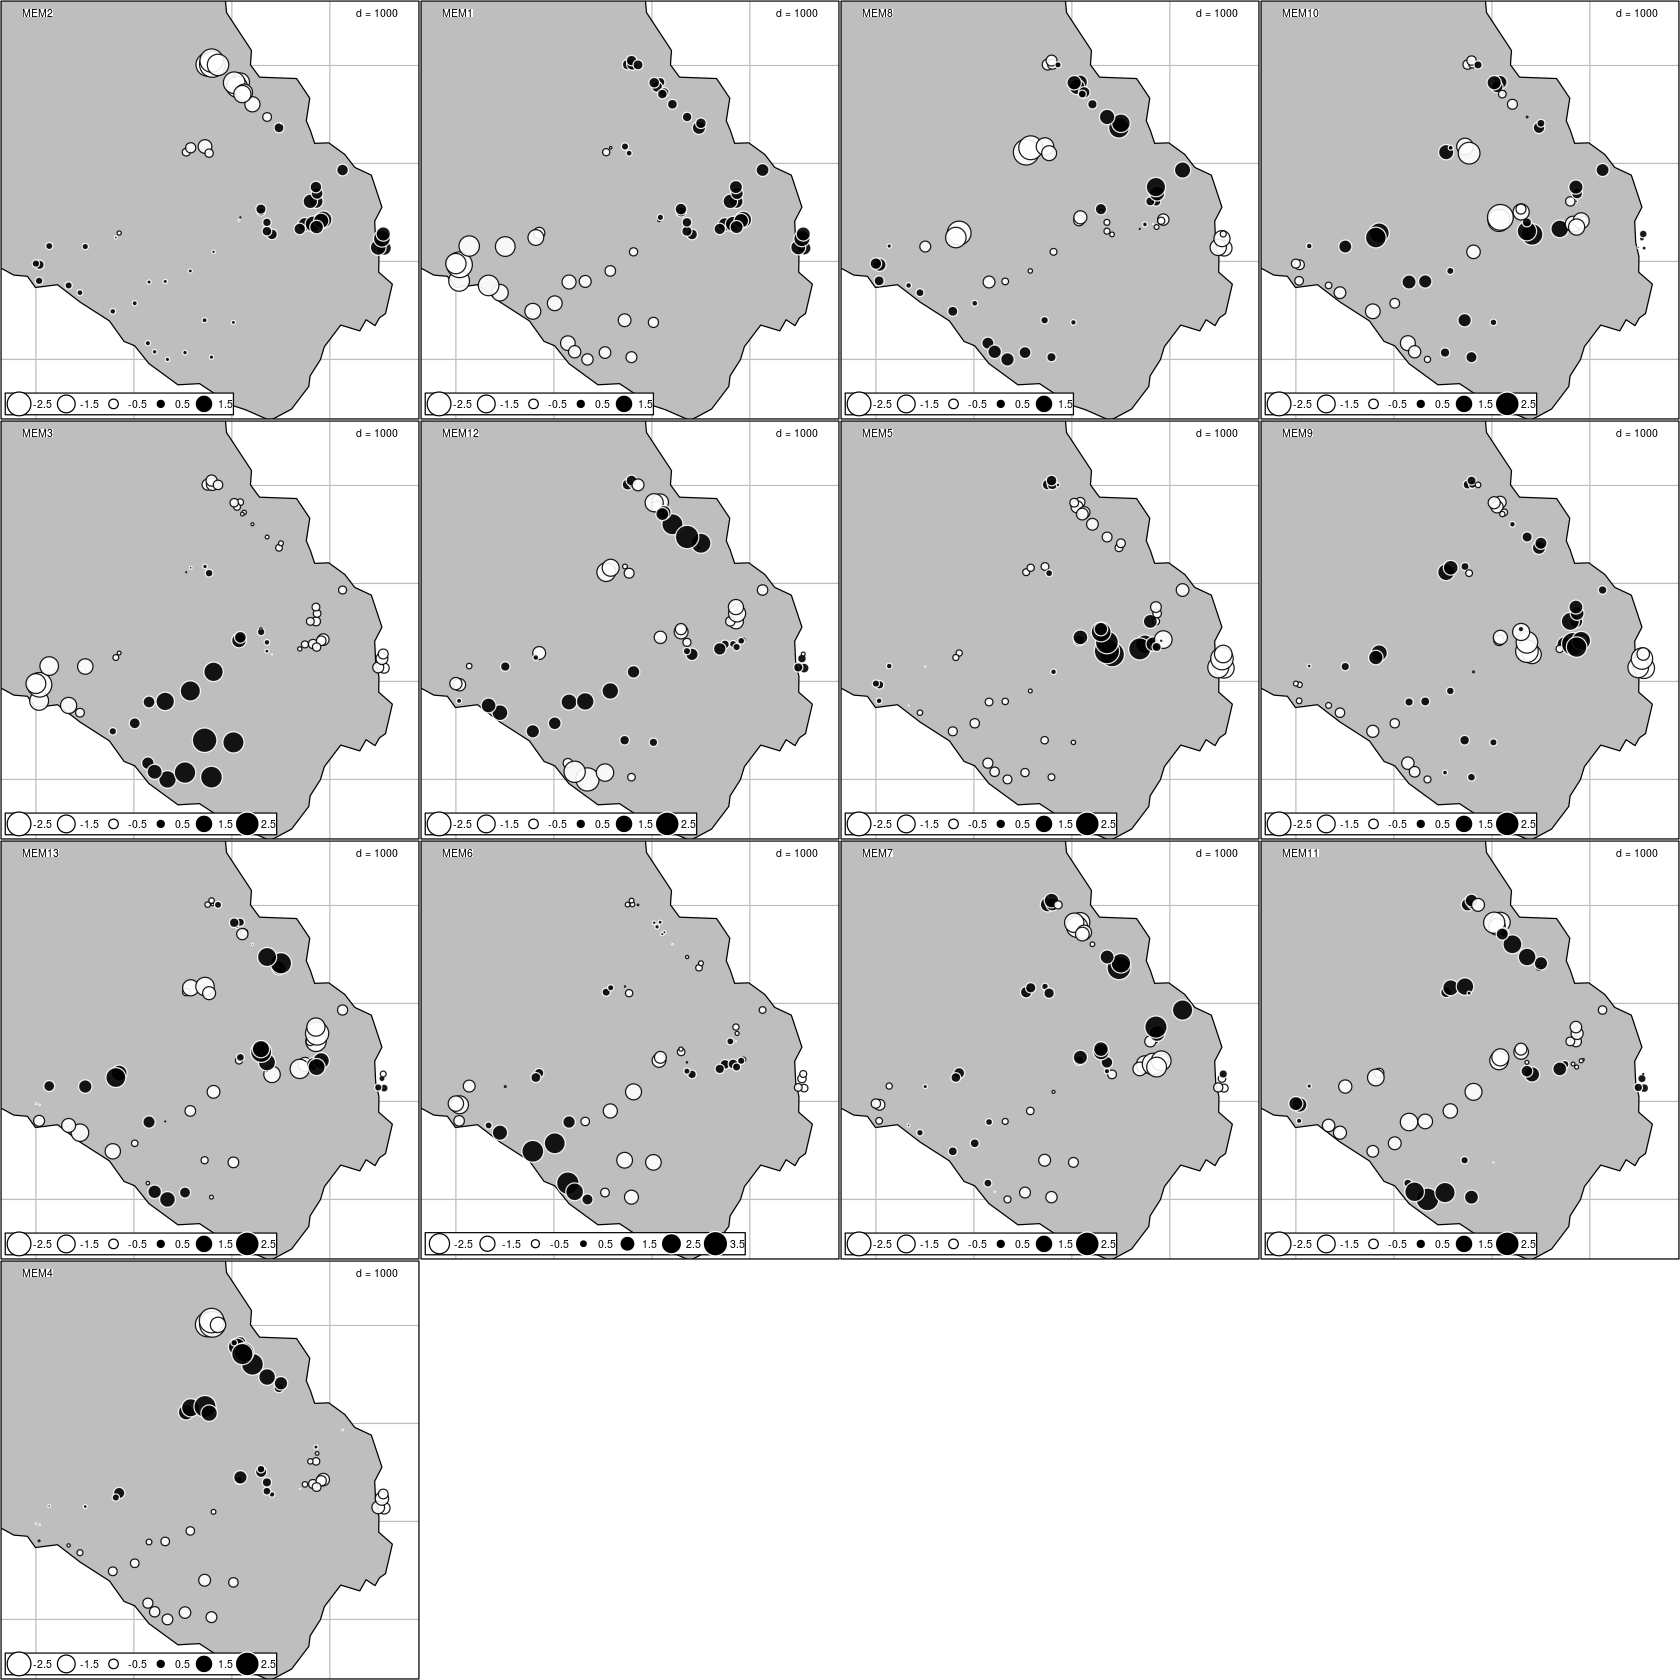

In [94]:
options(repr.plot.width=14, repr.plot.height=14)
s.value(pJ, mem.comM.sel$MEM.select, symbol="circle", Sp=lcPolyMoved)

In [98]:
sigMEM <- mem.comM.sel$MEM.select
#save(sigMEM, file='sigMEM.rda')
aa <- cbind(pts,sigMEM)
#write.csv(aa, file='sigMEM.csv', row.names=FALSE)

[back to top](#contents)

<a id=MEM2python></a>
#### Turning MEMs into spatial objects for python
The ade packages are great, but I am more comfortable in python these days, so let's port all this over:

In [3]:
aa = pd.read_csv('sigMEM.csv', index_col='PsubP')
mems = gpd.GeoDataFrame(aa, geometry=gpd.points_from_xy(aa.X, aa.Y))
mems.drop(['X', 'Y'], axis='columns', inplace=True)
mems = mems[['MEM1', 'MEM2', 'MEM3', 'MEM4', 'MEM5', 'MEM6', 'MEM7', 'MEM8', 'MEM9', 'MEM10', 'MEM11', 'MEM12', 'MEM13', 'geometry']]
mems.set_crs('EPSG:32717', inplace=True)


MEM1      MEM2      MEM3      MEM4      MEM5      MEM6      MEM7  \
PsubP                                                                         
1.1    0.856201  0.712657 -0.364962  0.025069 -0.827872 -0.361307  1.887439   
1.2    0.995398  0.999882 -0.442413 -0.328770 -0.295557  0.000692  0.185965   
1.3    1.045559  1.039525 -0.349818 -0.181647  0.982936  0.380443 -0.660338   
1.4    0.787947  0.724115 -0.337850 -0.093873 -0.415951 -0.147930  1.234973   
1.5    0.874846  0.708159 -0.349425  0.113478 -0.609896 -0.315884  2.218433   
...         ...       ...       ...       ...       ...       ...       ...   
9.9   -1.213697  0.060378 -0.213465  0.303941 -0.227683  0.712053  0.512716   
10.1   0.546614  0.368970  0.320838  0.655661  1.816236 -0.440743  1.217880   
10.2   0.715818  0.562616 -0.047389  0.338401  0.919984 -0.154046  1.078535   
10.3  -0.043937  0.029663  1.065254  0.363375  0.618120 -1.262406  0.511875   
10.4   0.243084 -0.009882  0.728801  0.911117  1.081141 -0.979542  1.012600   

           MEM8      MEM9     MEM10     MEM11     MEM12     MEM13  \
PsubP                                                               
1.1    1.274646  0.407887  0.868838 -0.402284 -0.582898 -0.552645   
1.2    0.503236  0.897081  0.062753 -0.620801 -1.102745 -1.896984   
1.3    0.453882  1.534730 -0.483296 -0.428236 -0.486937 -0.405355   
1.4    1.137002  0.967695  0.622304 -0.764976 -1.396418 -2.404034   
1.5    1.734361  0.974079  1.013622 -0.702918 -1.135233 -1.569951   
...         ...       ...       ...       ...       ...       ...   
9.9   -1.926285  1.052222  1.958847 -1.333739  0.201403  1.834372   
10.1  -0.169225 -1.396649 -1.264630 -1.059771 -0.970281  1.997057   
10.2   0.674321  0.186473 -0.537556 -0.741146 -0.665174  1.430058   
10.3  -0.601440 -0.559709 -2.187272 -1.613923 -0.040974 -0.296781   
10.4  -0.874329 -0.998389 -2.880877 -1.404023 -0.791579  0.353731   

                              geometry  
PsubP                                   
1.1    POINT (748246.000 10034127.000)  
1.2    POINT (747975.000 10033807.000)  
1.3    POINT (747917.000 10033807.000)  
1.4    POINT (747986.000 10033888.000)  
1.5    POINT (747974.000 10033953.000)  
...                                ...  
9.9    POINT (745932.000 10033438.000)  
10.1   POINT (747415.000 10033699.000)  
10.2   POINT (747413.000 10033728.000)  
10.3   POINT (747189.000 10033612.000)  
10.4   POINT (747203.000 10033644.000)  

[61 rows x 14 columns]

In [74]:
#mems.to_file('mems.geojson', driver='GeoJSON')

Since we're out the R/ADE4 world, we need to make our own plotter for these MEMs:

In [4]:
def plotMEM(mem, ax, scale=50, marg=650, lx=745000, ly=10035500, fontsize='large'):
    mem=mem
    ax=ax
    scale=scale
    ms = mems[mem].abs()*scale
    fontsize=fontsize
    marg = marg
    negPos = mems[mem].copy()
    negPos[negPos >= 0 ] = 1
    negPos[negPos < 0 ] = -1
    cDict = { 1 : "white", -1 : "black" }
    edgeCols = [ cDict[i] for i in negPos ]
    cmap = mcolors.ListedColormap(['white','black'])
    mems.plot(column=mem,
        c=negPos,
        cmap=cmap,
        edgecolors=edgeCols,
        ax=ax,
        markersize = ms,
        ## these are to center our color map to -1,1 w/b scheme:
        vmin=-1., vmax=1.,
        )
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlim(mems.total_bounds[0]-marg, mems.total_bounds[2]+marg)
    ax.set_ylim(mems.total_bounds[1]-marg, mems.total_bounds[3]+marg)
    ax.text(lx,ly,mem, fontsize=fontsize)


For one MEM, looks like this:

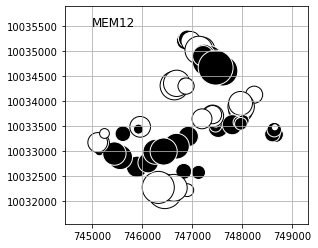

In [5]:
plt.close('all')
scale=500 #size of points
mem = 'MEM12'
fig, ax = plt.subplots()
ax.grid(True)
plotMEM(mem, ax, scale=scale)

For all of the significant MEMs:

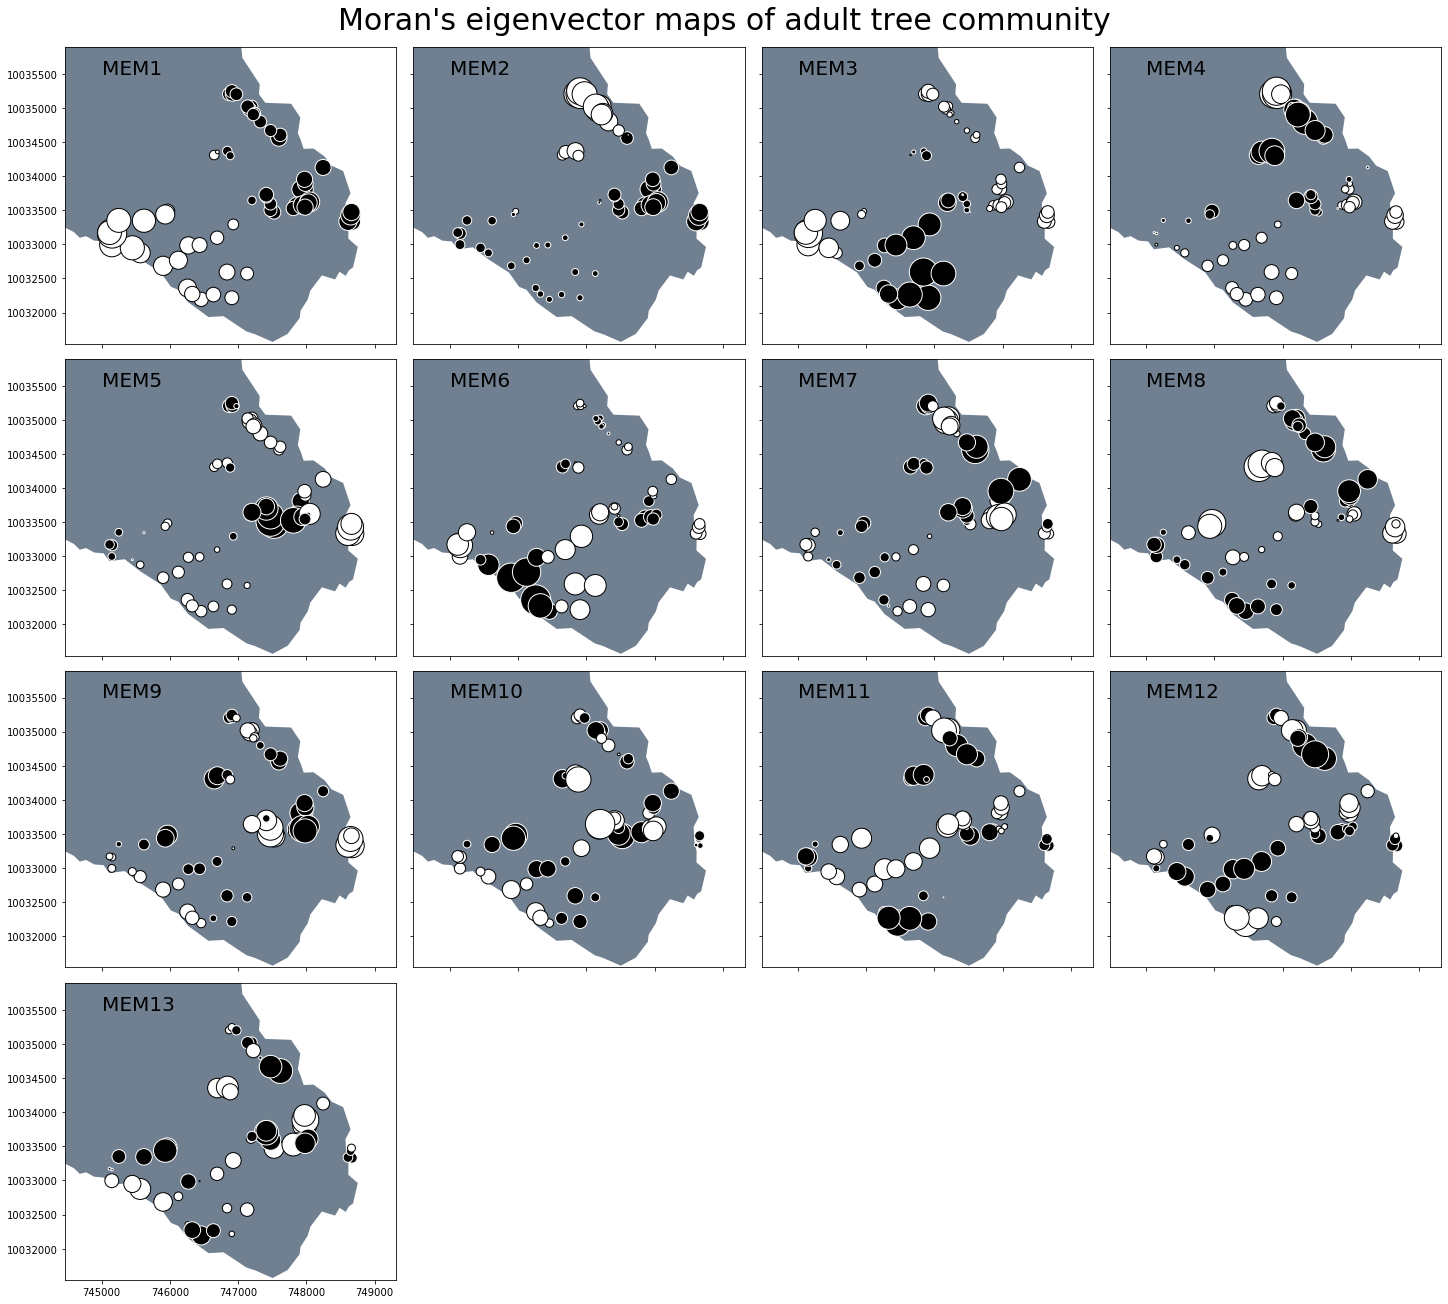

In [13]:
fig, axes = plt.subplots(4,4, figsize=(20,18), sharex=True, sharey=True, constrained_layout=True)
memList = mems.columns.to_list()[:-1]
flatAx = axes.ravel()

for i in range(13,16):
    flatAx[i].set_axis_off()

for i,j in enumerate(memList):
    lcPoly.plot(ax=flatAx[i], color="slategrey")
    plotMEM(j,flatAx[i], scale=300, fontsize = 20)

fig.suptitle("Moran's eigenvector maps of adult tree community", fontsize=30)
#plt.savefig("graphics/MEMs.svg")

So now we can take a closer look at any one of these, and plot them with any of our geodataframes. I find this to be a much more user-friendly environment. We have run a series of correlations to detect which, if any, of our available environmental predictor variables are correlation with with these MEMs, [below](#MEMcorrmat).

For example, here is MEM8, which from above looks to me like a pattern that correlates with the presence of ridgetops/river-bottom habitat:

<a id="MEM8"></a>

(10032144.0, 10035294.0)

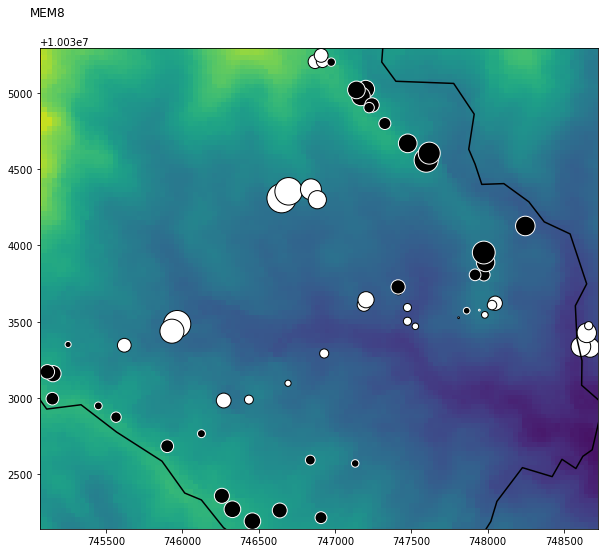

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(dem, ax=ax)
lcPoly.boundary.plot(ax=ax, color='black')
plotMEM('MEM8', ax, scale=300)
marg = 50
ax.set_xlim(mems.total_bounds[0]-marg, mems.total_bounds[2]+marg)
ax.set_ylim(mems.total_bounds[1]-marg, mems.total_bounds[3]+marg)

[back to top](#contents)

<a id='MEMcorrs'></a>
#### Correlations among MEMs and environmental data

But we can do a little better than the eyeball test. Let's check for correlations between our MEMs and the environmental data that we have:

In [45]:
## get our continuous environmental variables. DEM and elevation are pretty much redundant.
envVarsForMEM = envOnly.drop(['microcuenca','habitat','elevacion'], axis='columns')
## break up habitat into dummy variables
envVarsForMEM = pd.concat([envVarsForMEM, pd.get_dummies(envOnly.habitat)], axis=1)
memPanda = pd.DataFrame(mems.drop('geometry', axis='columns'))

In [46]:
## make our correlation matrix
memEnvCorrMat = pd.DataFrame(index=memPanda.columns)
memEnvCorrSigMat = pd.DataFrame(index=memPanda.columns)
for i in envVarsForMEM.columns:
    memEnvCorrMat[i] = memPanda.corrwith(envVarsForMEM.loc[:,i])
    pvals_i = []
    for j in memPanda.columns:
        _,_,_,p,_ = stats.linregress(memPanda[j], envVarsForMEM.loc[:,i])
        pvals_i += [p]
    memEnvCorrSigMat[i] = pvals_i

In [47]:
    
## correct for multiple corrections, at least along one axis here:
memEnvCorrSigAdjMat = pd.DataFrame(index=memPanda.columns)
for (columnName, columnData) in memEnvCorrSigMat.iteritems():
    aOrR, pAdj, _, _ = multipletests(columnData,
                                alpha=0.2,
                                method='fdr_bh',
                                returnsorted=False)
    memEnvCorrSigAdjMat[columnName] = pAdj

The above code gives us two matrices with the same shape, one with correlation R values from a linear regression, the other with adjusted p-values (family-wise error rates), using a Benjamini-Hochberg correction:

In [48]:
memEnvCorrSigAdjMat

slope           DEM    aspect   exposeE   exposeN  toStream  \
MEM1   0.420788  5.633692e-03  0.873426  0.909728  0.466734  0.759119   
MEM2   0.086305  4.737884e-07  0.845200  0.909728  0.452403  0.254214   
MEM3   0.374517  4.708526e-01  0.873426  0.909728  0.872149  0.106498   
MEM4   0.791097  4.708526e-01  0.845200  0.909728  0.075086  0.772973   
MEM5   0.420788  5.378071e-01  0.868842  0.909728  0.956667  0.772973   
MEM6   0.917379  2.882437e-01  0.845200  0.909728  0.452403  0.071828   
MEM7   0.374517  5.398868e-01  0.845200  0.909728  0.452403  0.825385   
MEM8   0.791680  5.633692e-03  0.845200  0.909728  0.452403  0.002490   
MEM9   0.420788  2.882437e-01  0.845200  0.909728  0.589534  0.939321   
MEM10  0.818589  4.708526e-01  0.845200  0.909728  0.964932  0.048319   
MEM11  0.948957  2.882437e-01  0.176592  0.909728  0.589534  0.090540   
MEM12  0.374517  8.137220e-01  0.872507  0.909728  0.452403  0.151773   
MEM13  0.791097  8.137220e-01  0.872507  0.909728  0.452403  0.254214   

             BC        BS       CLB       RCA        RG  
MEM1   0.675165  0.846389  0.715536  0.081225  0.166497  
MEM2   0.912456  0.972570  0.715536  0.068539  0.153873  
MEM3   0.909974  0.972570  0.715536  0.385223  0.153873  
MEM4   0.755687  0.846389  0.715536  0.272875  0.409749  
MEM5   0.909974  0.885735  0.715536  0.000473  0.409749  
MEM6   0.675165  0.514534  0.715536  0.574924  0.153873  
MEM7   0.675165  0.846389  0.715536  0.745992  0.014006  
MEM8   0.912456  0.846389  0.715536  0.101284  0.409749  
MEM9   0.675165  0.912197  0.715536  0.001697  0.153873  
MEM10  0.863209  0.846389  0.715536  0.745992  0.153873  
MEM11  0.675165  0.972570  0.715536  0.701972  0.872437  
MEM12  0.675165  0.846389  0.715536  0.701972  0.013338  
MEM13  0.083934  0.972570  0.715536  0.745992  0.153873

In [49]:
memEnvCorrMat

slope       DEM    aspect   exposeE   exposeN  toStream        BC  \
MEM1   0.161576 -0.402521 -0.020826  0.031591  0.138469 -0.082855 -0.141610   
MEM2  -0.343989 -0.635955 -0.108002  0.164611  0.162693 -0.183699 -0.014373   
MEM3  -0.203763 -0.127893  0.026925  0.091395  0.043717  0.262520 -0.038215   
MEM4   0.082755 -0.137640 -0.083939  0.070130  0.349427 -0.058540  0.095299   
MEM5  -0.157111 -0.106564 -0.068198  0.014823  0.019226 -0.062339  0.043346   
MEM6   0.025254  0.203687  0.178676 -0.111860  0.217372  0.305715  0.162633   
MEM7  -0.205644 -0.097052 -0.094378  0.120943  0.187058  0.039598 -0.185331   
MEM8   0.066803  0.403975 -0.092511  0.138542 -0.164990  0.460014  0.022018   
MEM9  -0.180884  0.219147 -0.133022  0.065245  0.097771 -0.009952  0.123803   
MEM10  0.051642 -0.133933  0.088452 -0.027580 -0.005748 -0.339504  0.068929   
MEM11 -0.008370  0.194524  0.314450 -0.222639 -0.104463  0.281687 -0.118376   
MEM12  0.232556 -0.040682  0.044287 -0.057166 -0.151566 -0.233563  0.154204   
MEM13 -0.078485 -0.030799  0.043665 -0.023926  0.152502  0.184226  0.345084   

             BS       CLB       RCA        RG  
MEM1  -0.108057 -0.172490  0.286871  0.203746  
MEM2  -0.004781  0.090577  0.307794 -0.220114  
MEM3  -0.004496 -0.121999 -0.163707  0.223096  
MEM4   0.124116  0.056447 -0.198086 -0.127603  
MEM5   0.078997  0.053483 -0.502755  0.114823  
MEM6   0.264276 -0.056768 -0.120785 -0.246755  
MEM7  -0.124708 -0.118833 -0.051196  0.385492  
MEM8   0.097284  0.188568 -0.265087 -0.119476  
MEM9  -0.062640 -0.047619 -0.451380  0.223832  
MEM10  0.098357  0.064409  0.042332 -0.215904  
MEM11 -0.009595  0.053070  0.079996  0.020990  
MEM12  0.195786  0.086413  0.086535 -0.410204  
MEM13  0.013110 -0.083934  0.044906 -0.252858

We can use the "p-value" one to mask the correlation matrix, to get the more statistically-significant correlation coefficients that might be interesting to look at:

In [50]:
## yup. Now maybe use an FDR < 0.1?:
aa = memEnvCorrSigAdjMat < 0.1
memEnvCorrMat[aa]

slope       DEM  aspect  exposeE   exposeN  toStream        BC  BS  \
MEM1        NaN -0.402521     NaN      NaN       NaN       NaN       NaN NaN   
MEM2  -0.343989 -0.635955     NaN      NaN       NaN       NaN       NaN NaN   
MEM3        NaN       NaN     NaN      NaN       NaN       NaN       NaN NaN   
MEM4        NaN       NaN     NaN      NaN  0.349427       NaN       NaN NaN   
MEM5        NaN       NaN     NaN      NaN       NaN       NaN       NaN NaN   
MEM6        NaN       NaN     NaN      NaN       NaN  0.305715       NaN NaN   
MEM7        NaN       NaN     NaN      NaN       NaN       NaN       NaN NaN   
MEM8        NaN  0.403975     NaN      NaN       NaN  0.460014       NaN NaN   
MEM9        NaN       NaN     NaN      NaN       NaN       NaN       NaN NaN   
MEM10       NaN       NaN     NaN      NaN       NaN -0.339504       NaN NaN   
MEM11       NaN       NaN     NaN      NaN       NaN  0.281687       NaN NaN   
MEM12       NaN       NaN     NaN      NaN       NaN       NaN       NaN NaN   
MEM13       NaN       NaN     NaN      NaN       NaN       NaN  0.345084 NaN   

       CLB       RCA        RG  
MEM1   NaN  0.286871       NaN  
MEM2   NaN  0.307794       NaN  
MEM3   NaN       NaN       NaN  
MEM4   NaN       NaN       NaN  
MEM5   NaN -0.502755       NaN  
MEM6   NaN       NaN       NaN  
MEM7   NaN       NaN  0.385492  
MEM8   NaN       NaN       NaN  
MEM9   NaN -0.451380       NaN  
MEM10  NaN       NaN       NaN  
MEM11  NaN       NaN       NaN  
MEM12  NaN       NaN -0.410204  
MEM13  NaN       NaN       NaN

<a id="MEMcorrmat"></a>
Doesn't look like much, but this is sort of our best guide to environmental predictors of many of the spatial patterns in the tree community. Each MEM is a spatial pattern that is orthogonal and independent of the other spatial patterns. Each of them seems to have 1-3 statistically significant predictors from our data, except for MEM3, which remains entirely unexplained by our environmental data. Most of them have only one or two predictors. For instance MEM8, visualized [above](#MEM8) on top of the elevation model, appears to be somewhat predicted by elevation and distance-nearest-stream. This is in-line with our eye-ball estimate that this is a "ridgetop" pattern.  

Just to note, a negative correlation coefficient here is the same as a positive, the magnitude is what is important. 

[back to top](#contents)

<a id='ofs'></a>

### Old Forest Sites - a closer look

There is much evidence in the above analyses that the old forest sites are very similar, among habitat types - bosques cerrados (BC), bosques secondarios (BS), and claros del bosque (CLB). However, these sites seem naturally cluster into two forest types, regardless of their successional stage. Let's subset to these old forest sites and see if we can find differences/patterns.

In [3]:
library(vegan)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



In [ ]:
## make our old forest data:
oldF <- envOnly$habitat != 'RG' & envOnly$habitat != 'RCA'
load('cGroup.rda')
all(cGroup$PsubP == envOnly$PsubP)
envOnly$clGr <- cGroup$gr
oldForestEnv <-  envOnly[oldF,]
rownames(oldForestEnv) <- NULL
oldForestComm <- sPC[oldF,]
all(rownames(sPC) == envOnly$PsubP )
nonzs <- colSums(oldForestComm) != 0
oldForestComm <- oldForestComm[,nonzs]
all(oldForestEnv$PsubP == rownames(oldForestComm))
## spatial data:
oldForestSp <- read.csv("subParcelSpatial.csv")
oldForestSp <- oldForestSp[oldForestSp$PsubP %in% oldForestEnv$PsubP,]
all(oldForestSp$PsubP == oldForestEnv$PsubP)

#save(oldForestSp, file='oldForestSp.rda')
#save(oldForestComm, file="oldForestComm.rda")
#save(oldForestEnv, file="oldForestEnv.rda")

<a id='oldPerms'></a>
#### PERMANOVA models of environmental predictors for old forest types

Now that we have our data, let's check it with permanova models:

In [1]:
#load("oldForestComm.rda")
#load("oldForestEnv.rda")

In [7]:
## run test
bb <- adonis(oldForestComm ~ oldForestEnv$habitat*oldForestEnv$elevacion*oldForestEnv$toStream)  
bb


Call:
adonis(formula = oldForestComm ~ oldForestEnv$habitat * oldForestEnv$elevacion *      oldForestEnv$toStream) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                                                                  Df SumsOfSqs
oldForestEnv$habitat                                               2    0.6226
oldForestEnv$elevacion                                             1    1.5919
oldForestEnv$toStream                                              1    0.4654
oldForestEnv$habitat:oldForestEnv$elevacion                        2    0.6770
oldForestEnv$habitat:oldForestEnv$toStream                         2    0.4892
oldForestEnv$elevacion:oldForestEnv$toStream                       1    0.4015
oldForestEnv$habitat:oldForestEnv$elevacion:oldForestEnv$toStream  2    0.4191
Residuals                                                         24    7.3031
Total                                                             35   11.9698
   

If we subset to just the old forest sites (CLB, BS, BC), the permanova test cannot distinguish among habitat types. This makes sense, from the ordination above and the clustering results, there doesn't seem to be a large difference between gaps, closed forest, and recently regenerated gaps, given a constant elevation. They can almost be treated as the same habitat ("old forest"), as far as species composition. But within the old forest, elevation appears to be playing an important role. 

Following this, the distance to stream seems to be somewhat important, explaining about 5% of the variance.

[back to top](#contents)

<a id='oldForestHabitat'></a>
#### check differences among old forest subplots by historical habitat type

The results so far indicate that there isn't much difference among the habitat types of old forest sites (BC, BS, CLB), but we can do some more explicit tests of this here:

In [6]:
OFnms <- metaMDS(oldForestComm, try=40)

Wisconsin double standardization
Run 0 stress 0.285992 
Run 1 stress 0.2852565 
... New best solution
... Procrustes: rmse 0.04228528  max resid 0.1679529 
Run 2 stress 0.3082739 
Run 3 stress 0.2912187 
Run 4 stress 0.2867236 
Run 5 stress 0.3116426 
Run 6 stress 0.3014042 
Run 7 stress 0.2856956 
... Procrustes: rmse 0.01704692  max resid 0.07734838 
Run 8 stress 0.285992 
Run 9 stress 0.3070421 
Run 10 stress 0.2888253 
Run 11 stress 0.3085674 
Run 12 stress 0.2859733 
Run 13 stress 0.285992 
Run 14 stress 0.2910211 
Run 15 stress 0.2873738 
Run 16 stress 0.2915182 
Run 17 stress 0.2867365 
Run 18 stress 0.2872059 
Run 19 stress 0.2919664 
Run 20 stress 0.2939268 
Run 21 stress 0.2859283 
Run 22 stress 0.2973577 
Run 23 stress 0.2992125 
Run 24 stress 0.3044849 
Run 25 stress 0.298593 
Run 26 stress 0.2849566 
... New best solution
... Procrustes: rmse 0.01779067  max resid 0.08116275 
Run 27 stress 0.2953658 
Run 28 stress 0.3006526 
Run 29 stress 0.3011594 
Run 30 stress 0.2860718

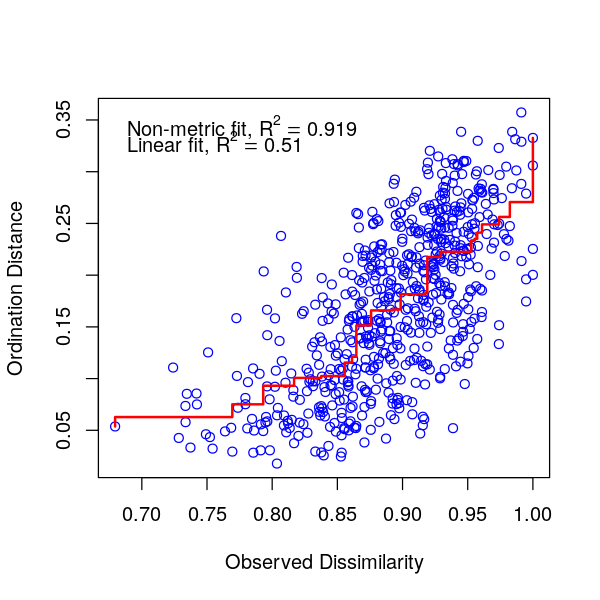

In [7]:
options(repr.plot.width=5, repr.plot.height=5)
stressplot(OFnms)
## as usual, not great, but still generally under 0.3

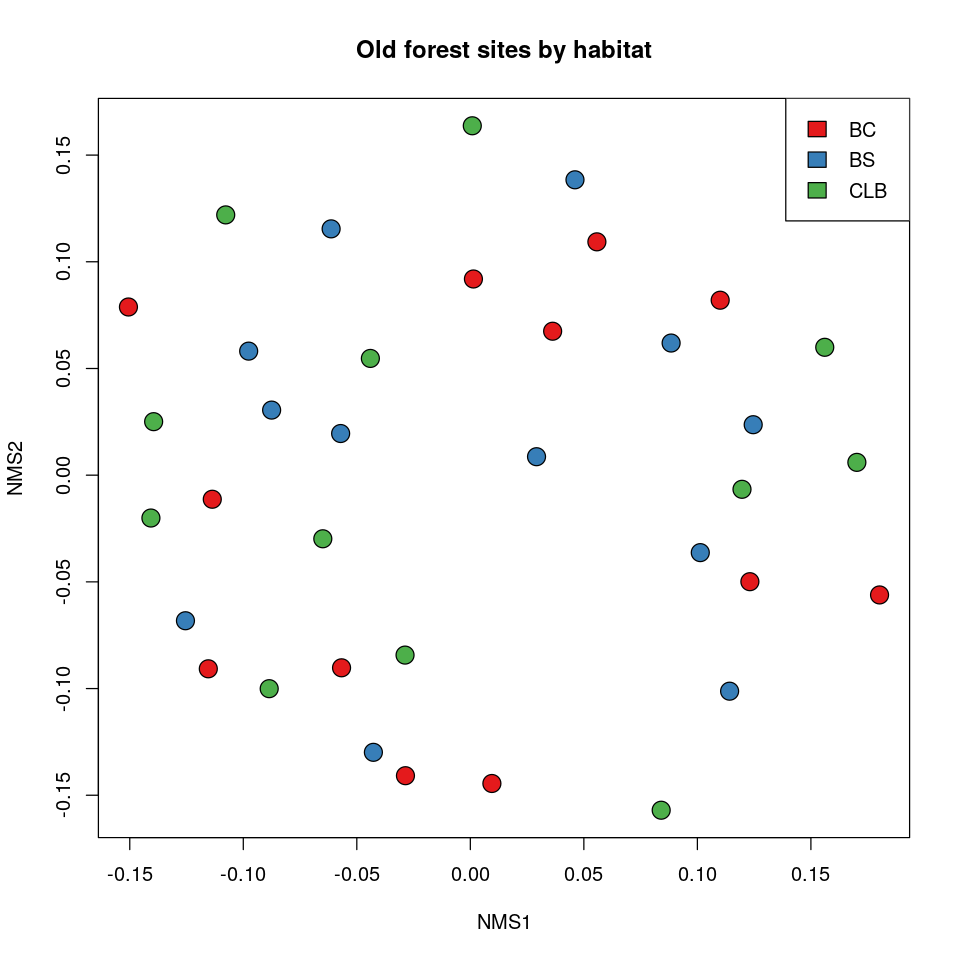

In [8]:
options(repr.plot.width=8, repr.plot.height=8)

XX <- OFnms$points[,'MDS1']
YY <- OFnms$points[,'MDS2']

## Get our colors to match original whole-community NMS:
colz <- vector()
for (i in oldForestEnv$habitat){
    if (i == 'BC'){colz <- c(colz, '#E41A1C')}
    if (i == 'BS'){colz <- c(colz, '#377EB8')}
    if (i == 'CLB'){colz <- c(colz, '#4DAF4A')}
}
plot(XX, YY,
    col="black",
    xlab='NMS1',
    ylab='NMS2',
    pch=21,
    cex=2,
    bg=colz,
    main="Old forest sites by habitat",
    )
legend( x='topright',
        legend = c('BC', 'BS', 'CLB'),
        fill = c('#E41A1C', '#377EB8', '#4DAF4A'),
        cex = 1.0,
        )


I'm not even going to try putting hulls on those groups. But to drive this home, we can model the dissilimarities as a function of habitat type:`

In [75]:
fh <- factor(oldForestEnv$habitat)
adonis(oldForestComm ~ fh)


Call:
adonis(formula = oldForestComm ~ fh) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
fh         2    0.6226 0.31132 0.90539 0.05202  0.653
Residuals 33   11.3472 0.34385         0.94798       
Total     35   11.9698                 1.00000       

The results are pretty much random. 

[back to top](#contents)

<a id='oldForestOrdElev'></a>
#### Grouping in old forests by elevation

Our hierarchical clustering indicated at least two distinct forest types. Do these two types separate out clearly if we ordinate just the forest sites? If so, what are some environmental predictors of this?

In [10]:
OFnms <- metaMDS(oldForestComm, try=40)
XX <- OFnms$points[,'MDS1']
YY <- OFnms$points[,'MDS2']

Wisconsin double standardization
Run 0 stress 0.285992 
Run 1 stress 0.296616 
Run 2 stress 0.2860251 
... Procrustes: rmse 0.05070694  max resid 0.1659396 
Run 3 stress 0.2849085 
... New best solution
... Procrustes: rmse 0.03995425  max resid 0.1695279 
Run 4 stress 0.3063857 
Run 5 stress 0.2930895 
Run 6 stress 0.2859223 
Run 7 stress 0.2872111 
Run 8 stress 0.297605 
Run 9 stress 0.2939086 
Run 10 stress 0.2871889 
Run 11 stress 0.3102844 
Run 12 stress 0.2864445 
Run 13 stress 0.3071152 
Run 14 stress 0.3014557 
Run 15 stress 0.287189 
Run 16 stress 0.3073614 
Run 17 stress 0.3031655 
Run 18 stress 0.285992 
Run 19 stress 0.3069667 
Run 20 stress 0.2859002 
Run 21 stress 0.2995033 
Run 22 stress 0.2912186 
Run 23 stress 0.3071893 
Run 24 stress 0.2849085 
... Procrustes: rmse 9.049816e-05  max resid 0.0001998516 
... Similar to previous best
Run 25 stress 0.2939584 
Run 26 stress 0.2995192 
Run 27 stress 0.2856966 
Run 28 stress 0.2859317 
Run 29 stress 0.2939991 
Run 30 stress 

In [15]:
#save(OFnms, file='OFnms.rda')

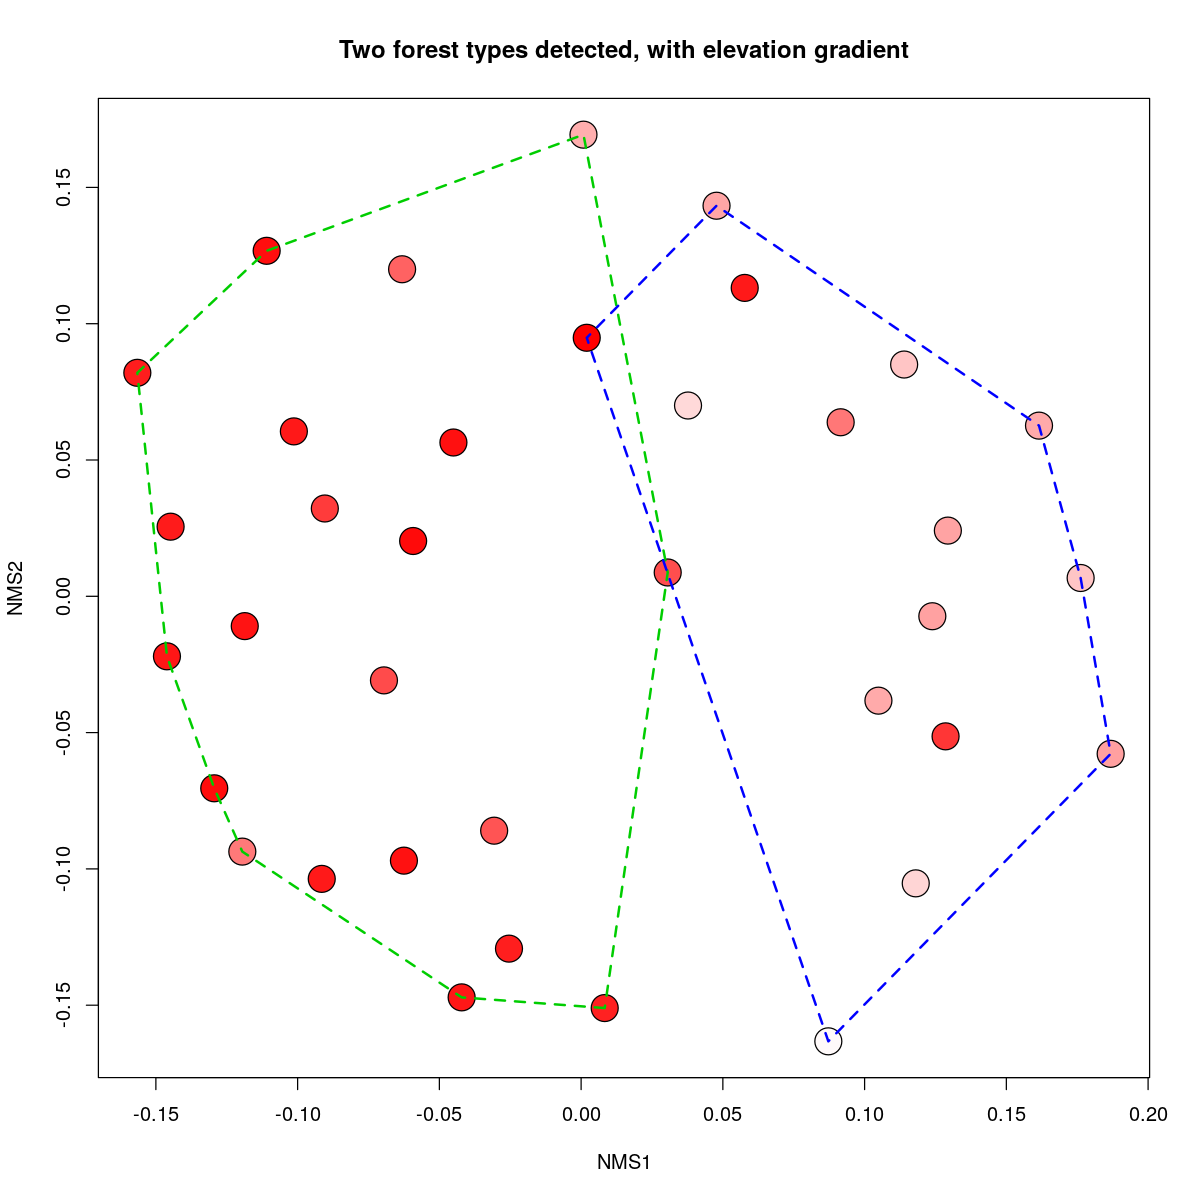

In [14]:
options(repr.plot.width=10, repr.plot.height=10)

## make a color ramp for this elevation data
cGroup <- read.csv('cGroup.csv', row.names="PsubP")
oldForestClGr <- cGroup[row.names(oldForestEnv),]
minElev <- min(oldForestEnv$elevacion)
maxElev <- max(oldForestEnv$elevacion)
rangeElev <- maxElev - minElev
colrsRamp <- colorRampPalette(c(rgb(1,0,0,0), rgb(1,0,0,1)), alpha = TRUE)(rangeElev)
ElevColrs <- colrsRamp[oldForestEnv$elevacion - min(oldForestEnv$elevacion)]

plot(XX, YY,
    col="black",
    pch=21,
    cex=3,
    bg=ElevColrs,
    xlab='NMS1',
    ylab='NMS2',
    main="Two forest types detected, with elevation gradient"
    )
## can we add cluster group data to the plot?
## group order will be:
#names(table(oldForestEnv$clGr))
## so this should work:
ordihull(OFnms, oldForestClGr, col=c(3,4), lwd=2, lty=2)
## yup, that's intriguing. 
#legend( x='topright',
#        legend = c('clustGroup 3', 'clustGroup 4', '1259 m', '1680 m'),
#        col = c(3,4, 1, 1),
#        bty = 'n',
#        pt.bg = c(NA, NA, "transparent", "red"),
#        #merge = FALSE,
#        cex = 2.0,
#        lty = c(2,2, NA, NA),
#        lwd = 2.0,
#        pch = c(NA, NA, 21, 21),
#        )

I am still having troubles with getting the jupyter plotter to handle my legends. From my local plotter:

<img src="oldForestNMSelevClust.png" width=500>

It's pretty clear that there is an elevation difference. But there is a more explicit way to model this, with a logistic regression. For this we will use the bayesian environment given above.

[back to top](#contents)

<a id='oldForestLogit'></a>
#### Linear model for distinguishing old forest types by elevation

Given that height seems to be having an effect on forest tree community, as modeled by the permanova above above, and also visualized in our section on [Elevation of current ecological states](#elevationClust), we'll zoom in a bit and see if we can model elevation as a predictor of forest type, subsetting just to forest types III and IV.

In [3]:
## in bayesAna conda environment

envOnly = pd.read_csv('envOnly.csv', index_col='PsubP')
landUseForesttypeDF = pd.read_csv('landUseForesttypeDF.csv', index_col='site')
elevLUDF = pd.concat([landUseForesttypeDF, envOnly], axis=1)[['landUse','forestType','elevacion']]
df = elevLUDF.query("forestType > 2")

In [4]:
forestTypeColDict = {
                      1:'k',
                      2:'r',
                      3:'g',
                      4:'b',
                    }
colrs = df['forestType'].apply(lambda x: forestTypeColDict[x])

y_0 = pd.Series(index=df.index, dtype=int)
y_0[df['forestType'] == 3] = 1
x_n = 'elevacion'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()


In [6]:
with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + pm.math.dot(x_c, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    trace_0 = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains, 21 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1174.40draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


([<matplotlib.axis.XTick at 0x7fd959756ad0>,
 [Text(-300.0, 0, '1216.5'),
  Text(-200.0, 0, '1316.5'),
  Text(-100.0, 0, '1416.5'),
  Text(0.0, 0, '1516.5'),
  Text(100.0, 0, '1616.5'),
  Text(200.0, 0, '1716.5')])

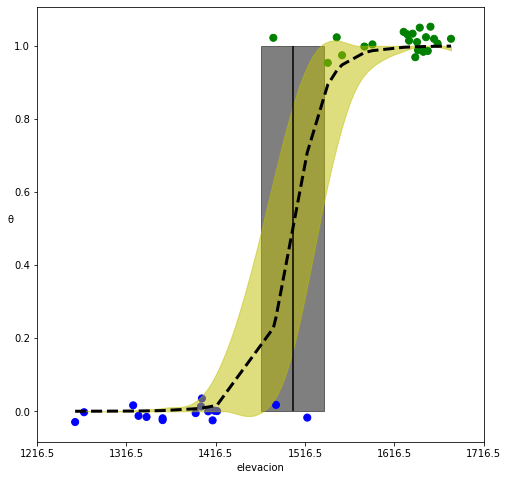

In [7]:
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_c)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x_c[idx], theta[idx], color='k', lw=3, ls='--')
ax.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_0['bd'])
ax.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
ax.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', s= 200, color=colrs)
az.plot_hpd(x_c, trace_0['θ'], color='y')
ax.set_xlabel(x_n)
ax.set_ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))


So somewhere around 1500 m, we see the forests shift from type IV (lower elevation) to type III. Is this a good model?

In [8]:
ppc = pm.sample_posterior_predictive(trace_0, samples=3000, model=model_0)
az.r2_score(y_0, ppc['yl'].mean(axis=0))

/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 3000/3000 [00:02<00:00, 1002.97it/s]


r2        0.874644
r2_std    0.000000
dtype: float64

Does our posterior predict our observed forest types well?:

In [9]:
bb = pd.Series(dtype=int, index=df.index)
aa = trace_0['θ'].mean(axis=0)
bb[aa > 0.5] = 1
percentRight = (bb == y_0).sum()/len(y_0)
print(y_0.to_list())
print(bb.to_list())
print(f'Out of {len(y_0)} we got {(bb == y_0).sum()} right')
print(f'The model predicts the data {round(percentRight,3)*100}% of the time correctly')


[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
Out of 37 we got 35 right
The model predicts the data 94.6% of the time correctly


Not bad. What do the posteriors look like? 

/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/daniel/anaconda3/envs/bayesAna/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwarg

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>]], dtype=object)

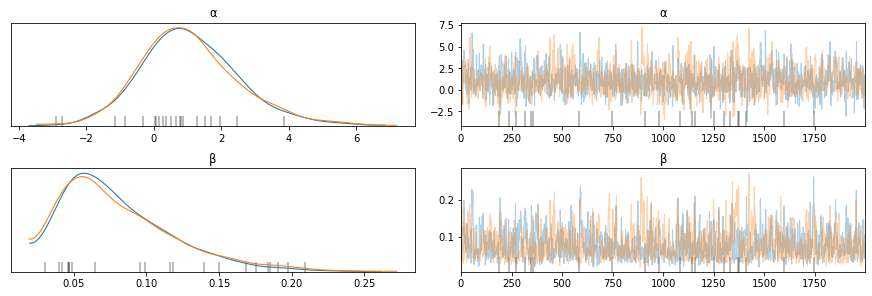

In [10]:
az.plot_trace(trace_0, var_names = ["α", "β"])

In [11]:
az.summary(trace_0, var_names=["α", "β"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α  1.066  1.484  -1.714    3.918      0.042    0.032    1250.0  1047.0   
β  0.081  0.039   0.024    0.155      0.001    0.001     801.0   767.0   

   ess_bulk  ess_tail  r_hat  
α    1334.0    1518.0    1.0  
β     938.0     983.0    1.0

In [14]:
az.summary(trace_0, var_names=["α", "β","bd"])

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α    1.066   1.484  -1.714    3.918      0.042    0.032    1250.0  1047.0   
β    0.081   0.039   0.024    0.155      0.001    0.001     801.0   767.0   
bd -13.674  18.843 -49.762   20.871      0.457    0.328    1703.0  1649.0   

    ess_bulk  ess_tail  r_hat  
α     1334.0    1518.0    1.0  
β      938.0     983.0    1.0  
bd    1788.0    1847.0    1.0

What is the best estimate of our boundary decision?

In [18]:
print("mean boundary decision: " + str(trace_0['bd'].mean() + x_0.mean()))

mean boundary decision: 1502.8395758238444


In [21]:
print("95% credible interval")
[ (az.hpd(trace_0['bd'], credible_interval=0.95)[i] + x_0.mean()) for i in [0,1] ]

95% credible interval


[1464.1025973800452, 1538.4167657587343]

[back to top](#contents)

<a id='oldForestOrdWater'></a>
####  Grouping in old forests by distance to water

 Cluster group 3 tends to higher sites, group 4 to lower. And now let's look at proximity to water: 

In [16]:
load('OFnms.rda')
XX <- OFnms$points[,'MDS1']
YY <- OFnms$points[,'MDS2']
cGroup <- read.csv('cGroup.csv', row.names="PsubP")
oldForestClGr <- cGroup[row.names(oldForestEnv),]

In [19]:
minDtoS <- min(oldForestEnv$toStream)
maxDtoS <- max(oldForestEnv$toStream)
rangeDtoS <- maxDtoS - minDtoS
colrsRamp <- colorRampPalette(c(rgb(0,0,1,0.5), rgb(1,1,0,1)), alpha = TRUE)(rangeDtoS)
DtoSColrs <- colrsRamp[oldForestEnv$toStream - min(oldForestEnv$toStream)]

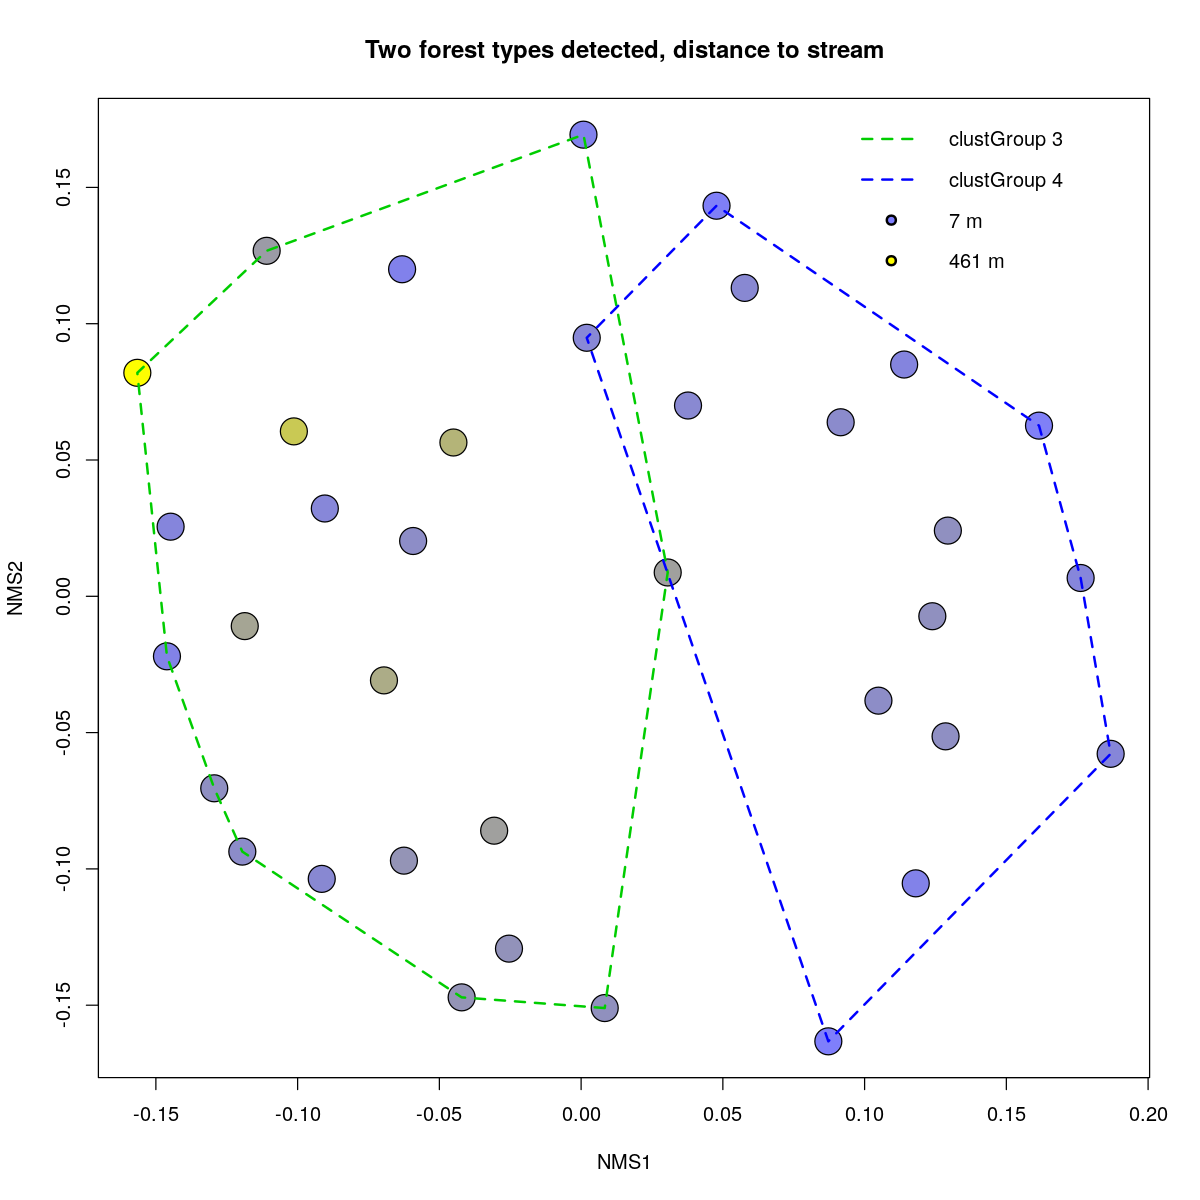

In [21]:
plot(XX, YY,
    col="black",
    pch=21,
    cex=3,
    bg=DtoSColrs,
    xlab='NMS1',
    ylab='NMS2',
    main="Two forest types detected, distance to stream"
    )
ordihull(OFnms, oldForestClGr, col=c(3,4), lwd=2, lty=2)
legend( x='topright',
        legend = c('clustGroup 3', 'clustGroup 4', '7 m', '461 m'),
        col = c(3,4, 1, 1),
        bty = 'n',
        pt.bg = c(NA, NA, colrsRamp[1], colrsRamp[maxDtoS - minDtoS]),
        #pt.bg = c(NA, NA, "transparent", "blue"),
        cex = 1.0,
        lty = c(2,2, NA, NA),
        lwd = 2.0,
        pch = c(NA, NA, 21, 21),
        )


It is sort of apparent that group 3 is farther from streams (~ drier?), even if not a super strong signal. 

There may be other environmental indicators, and particular watersheds may harbor unique species. We can sort of examine this latter question (highly local, endemic species in otherwise similar habitats) by examining our forest MEMs a little.  

[back to top](#contents)

<a id='joven'></a>
### Juvenile communities - a glimpse into the future?

Ana and her team also surveyed the presence of immature - or juvenile - trees. We can take a look at these and try to understand the trajectory that this forest may be taking. 

<a id='juvClean'></a>
#### Notes about preparing the juvenile data 
I did a lot of cleaning up of the juvenile data, which is recorded within the chaos of my personal text notebook in this gitgub repository if you are curious. The juvenile species are obviously much more difficult for the botanists - no flowers, no significant trunk, etc. So I had to remove species that never reached sufficient identification, or species that were ultimately identified to a non-tree species (or at least, a species that when mature would be unlikely to have been detected by the protocols of this study). This was done by automated and manual curation of the juvenile species that were not also in the adult data set, using growth form data requested from the [TRY database](https://www.try-db.org/TryWeb/Home.php), spot checks of the [Encyclopedia of life](https://eol.org/) (which relies heavily on records from TRY, but also other sources), and the [Smithsonian Tropical Research collections site](https://stricollections.org/portal/index.php), which is useful because many of their collections come from the northern Choco (Panama). And of course, the Gentry manual was also frequently consulted. Usually, exact species info was not available and I had to make best guesses based on genus growth forms. 

The end result is a community matrix for the juvenile species, which can be merged with the mature tree community matrix with pandas like this:

In [2]:
## original cleaned mature tree data
specObs = pd.read_csv('specObs.csv')
## original mature tree community matrix and juv matrix
subParcelComm = pd.read_csv('subParcelComm.csv', index_col='PsubP')
juvComm = pd.read_csv('juvComm.csv', index_col='PsubP')

To make our community matrix for the juvenile data we did this (rerun to remake):

In [4]:
juvSpecObs = pd.read_csv('juvSpecObs.csv')
aa = juvSpecObs[['PsubP', 'genusSpecies']]
aa.set_index('PsubP', inplace=True)
bb = pd.get_dummies(aa['genusSpecies'])
## okay, we need to collapse these 
bb.reset_index(inplace=True)
cc = bb.groupby('PsubP')
juvComm = cc.agg(np.sum)
#juvComm.to_csv('juvComm.csv', index='PsubP')

In [3]:
## how many species do they share?
sum(subParcelComm.columns.isin(juvComm.columns.values))

111

In [4]:
juvComm.head()

Actinidaceae Saurauia sp.1  Actinidaceae sp.  \
PsubP                                                 
1.1                             0                 0   
1.2                             0                 1   
1.3                             0                 0   
1.4                             0                 0   
1.5                             0                 0   

       Anacardiaceae Tapirira guianensis  Annonaceae Guatteria megalophylla  \
PsubP                                                                         
1.1                                    0                                  0   
1.2                                    0                                  0   
1.3                                    0                                  0   
1.4                                    0                                  0   
1.5                                    0                                  0   

       Annonaceae sp.  Araliaceae Dendropanax aff. macrophyllum  \
PsubP                                                             
1.1                 0                                         0   
1.2                 0                                         0   
1.3                 0                                         0   
1.4                 0                                         0   
1.5                 0                                         0   

       Arecaceae Chamaedorea pinnatifrons  Arecaceae Hyospathe elegans  \
PsubP                                                                    
1.1                                     0                            0   
1.2                                     0                            0   
1.3                                     0                            0   
1.4                                     0                            0   
1.5                                     0                            0   

       Arecaceae Wettinia aff. oxycarpa  \
PsubP                                     
1.1                                   0   
1.2                                   0   
1.3                                   0   
1.4                                   0   
1.5                                   0   

       Asteraceae Criptoniosis cf. occidentalis  ...  \
PsubP                                            ...   
1.1                                           0  ...   
1.2                                           0  ...   
1.3                                           0  ...   
1.4                                           0  ...   
1.5                                           0  ...   

       Staphyleaceae Huertea glandulosa  Styracaceae Styrax weberbaueri  \
PsubP                                                                     
1.1                                   0                               0   
1.2                                   0                               0   
1.3                                   0                               0   
1.4                                   0                               0   
1.5                                   0                               0   

       Symplocaceae Symplocos fuliginosa  \
PsubP                                      
1.1                                    0   
1.2                                    0   
1.3                                    0   
1.4                                    0   
1.5                                    0   

       Thymelaeaceae Schoenobiblus cf. daphnoides  Tiliaceae sp.  \
PsubP                                                              
1.1                                             0              0   
1.2                                             0              0   
1.3                                             0              0   
1.4                                             0              0   
1.5                                             0              0   

       Urticaceae Phenax aff. rugosus  Urticaceae Urera aff. caracasana

In [5]:
subParcelComm.head()

Actinidaceae Saurauia sp.1  Anacardiaceae Mauria cf. heterophylla  \
PsubP                                                                      
1.1                             5                                      0   
1.2                             0                                      0   
1.3                             0                                      0   
1.4                             0                                      0   
1.5                             0                                      0   

       Anacardiaceae Tapirira guianensis  \
PsubP                                      
1.1                                    0   
1.2                                    0   
1.3                                    0   
1.4                                    0   
1.5                                    0   

       Annonaceae Guatteria cf. megalophylla  \
PsubP                                          
1.1                                        0   
1.2                                        0   
1.3                                        0   
1.4                                        1   
1.5                                        0   

       Annonaceae Guatteria megalophylla  Annonaceae Guatteria sp.  \
PsubP                                                                
1.1                                    0                         0   
1.2                                    0                         0   
1.3                                    0                         0   
1.4                                    0                         0   
1.5                                    0                         0   

       Annonaceae Rollinia aff. dolichopetala  Annonaceae Rollinia edulis  \
PsubP                                                                       
1.1                                         0                           0   
1.2                                         0                           0   
1.3                                         0                           0   
1.4                                         0                           0   
1.5                                         0                           0   

       Annonaceae sp.  Aquifoliaceae Ilex cf. yurumanguinis  ...  \
PsubP                                                        ...   
1.1                 0                                     0  ...   
1.2                 0                                     0  ...   
1.3                 0                                     0  ...   
1.4                 0                                     0  ...   
1.5                 0                                     0  ...   

       Theophrastaceae Clavija eggersiana  \
PsubP                                       
1.1                                     0   
1.2                                     0   
1.3                                     0   
1.4                                     0   
1.5                                     0   

       Theophrastaceae Clavija membranacea  \
PsubP                                        
1.1                                      0   
1.2                                      0   
1.3                                      0   
1.4                                      0   
1.5                                      0   

       Thymelaeaceae Schoenobiblus daphnoides  Ulmaceae Trema micrantha  \
PsubP                                                                     
1.1                                         0                         0   
1.2                                         0                         0   
1.3                                         0                         0   
1.4                                         0                         0   
1.5                                         0                         0   

       Urticaceae Boehmeria caudata  Urticaceae Urera aff. caracasana  \
PsubP                                                                   
1.1      

The juvenile and mature tree sites share 110 common species (one column is PsubP identifier)

Next we combine these two matrices, to have a community matrix of sites that includes both mature and juvenile tree specimens:

In [6]:
combCommMat = pd.concat([subParcelComm, juvComm], keys=['adulto','joven'], sort=True)
## how can we get zeroes instead of NA's?

combCommMat.fillna(0, inplace=True)
combCommMat.to_csv('comboMat.csv')

In [7]:
combCommMat

Actinidaceae Saurauia sp.1  Actinidaceae sp.  \
       PsubP                                                 
adulto 1.1                             5               0.0   
       1.2                             0               0.0   
       1.3                             0               0.0   
       1.4                             0               0.0   
       1.5                             0               0.0   
...                                  ...               ...   
joven  9.9                             0               0.0   
       10.1                            0               0.0   
       10.2                            0               0.0   
       10.3                            0               0.0   
       10.4                            0               0.0   

              Anacardiaceae Mauria cf. heterophylla  \
       PsubP                                          
adulto 1.1                                      0.0   
       1.2                                      0.0   
       1.3                                      0.0   
       1.4                                      0.0   
       1.5                                      0.0   
...                                             ...   
joven  9.9                                      0.0   
       10.1                                     0.0   
       10.2                                     0.0   
       10.3                                     0.0   
       10.4                                     0.0   

              Anacardiaceae Tapirira guianensis  \
       PsubP                                      
adulto 1.1                                    0   
       1.2                                    0   
       1.3                                    0   
       1.4                                    0   
       1.5                                    0   
...                                         ...   
joven  9.9                                    0   
       10.1                                   0   
       10.2                                   0   
       10.3                                   0   
       10.4                                   0   

              Annonaceae Guatteria cf. megalophylla  \
       PsubP                                          
adulto 1.1                                      0.0   
       1.2                                      0.0   
       1.3                                      0.0   
       1.4                                      1.0   
       1.5                                      0.0   
...                                             ...   
joven  9.9                                      0.0   
       10.1                                     0.0   
       10.2                                     0.0   
       10.3                                     0.0   
       10.4                                     0.0   

              Annonaceae Guatteria megalophylla  Annonaceae Guatteria sp.  \
       PsubP                                                                
adulto 1.1                                    0                       0.0   
       1.2                                    0                       0.0   
       1.3                                    0                       0.0   
       1.4                                    0                       0.0   
       1.5                                    0                       0.0   
...                                         ...                       ...   
joven  9.9                                    0                       0.0   
       10.1                                   0                       0.0   
       10.2                                   0                       0.0   
       10.3                                   0                       0.0   
       10.4                                   0                       0.0   

              Annonaceae Rollinia aff. dolichopetala  \
       PsubP                                         

So now we can go into R/vegan and look for some differences between the juveniles and mature trees.

In [3]:
library(vegan)
library(RColorBrewer)

comboCommMat <- read.csv('comboMat.csv')

In [4]:
comboCommMat[1:5,1:5]

X      PsubP Actinidaceae.Saurauia.sp.1 Actinidaceae.sp.
1 adulto 1.1   5                          0               
2 adulto 1.2   0                          0               
3 adulto 1.3   0                          0               
4 adulto 1.4   0                          0               
5 adulto 1.5   0                          0               
  Anacardiaceae.Mauria.cf..heterophylla
1 0                                    
2 0                                    
3 0                                    
4 0                                    
5 0

Subset to just those sites that have both adult and juvenile data. 

In [5]:
jovenes <- comboCommMat[comboCommMat$X == 'joven',]
adultosInjovenes <- comboCommMat$PsubP %in% jovenes$PsubP
adultosDejovenes <- comboCommMat[adultosInjovenes,]

In [6]:
dim(adultosDejovenes)

[1]  74 383

There are 74 sites, meaning 37 sites had both juvenile and adult survey data. I wonder if this is an error, because I think Ana and her team worked at ~61 sites? Was the juvenile data lost from these?

Not sure. Below we will see that this "lost data" comes entirely from gaps ("CLB") and natural second growth ("BS"), we are entirely lacking juvenile seedling data for these types of habitat. 

[back to top](#contents)

<a id='childrenOfClusters'></a>
#### Juvenile points, relation to Adult clusters

So, what happened to the "natural" groups we uncovered above, from our [hierarchical clustering of the adults](#hierarch)? Start by ordinating the combination community matrix of adults and juveniles, with an NMS, based on BC distance:


In [2]:
### don't run this, load the combonms file in next cell
aa <- adultosDejovenes[,3:ncol(adultosDejovenes)]
## I don't think we want zero 
bb <- aa[,colSums(aa) > 0]
set.seed(6)
comboNMS <- metaMDS(bb)

ERROR: Error in eval(expr, envir, enclos): object 'adultosDejovenes' not found


In [9]:
#save(comboNMS, file='comboNMS.rda')
load(file='comboNMS.rda')

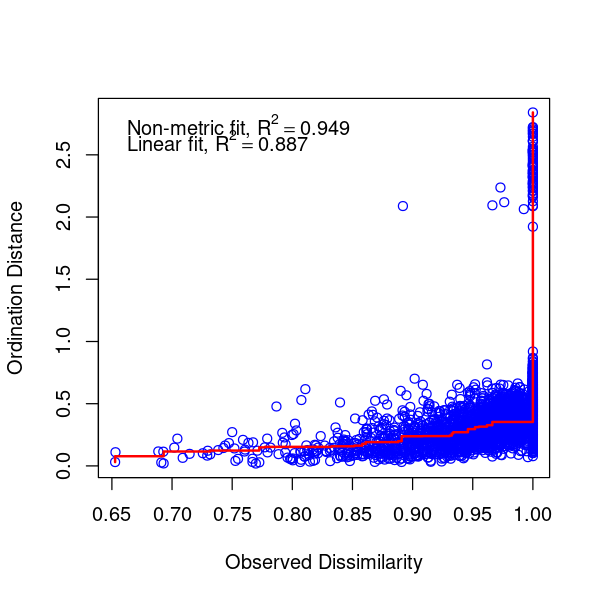

In [10]:
options(repr.plot.width=5, repr.plot.height=5)
stressplot(comboNMS)

Huh, looks like there are some points that really didn't work out. As in, they are just so different, it didn't make sense to put them anywhere. But overall the stress is pretty manageable. Dig up our clustering results from above:

In [11]:
cGroup <- read.csv('cGroup.csv')
envOnly <- read.csv('envOnly.csv')

comboGr <- sapply(adultosDejovenes$PsubP, function(x){ cGroup[cGroup$PsubP == x,'gr']})
comboHab <- sapply(adultosDejovenes$PsubP, function(x){ envOnly[envOnly$PsubP == x,'habitat']})

If we divide things up a bit, we can see that the adults in this subset retain their clustering, but their "kids" are wondering off:

In [12]:
## give zero values to the juveniles:
comboGrAdOnly <- comboGr
for (i in 1:length(comboGrAdOnly)){
    if (adultosDejovenes[i,'X'] == 'joven'){
    comboGrAdOnly[i] <- 0}
}
## for pch:
## we want solid colors, triangle for 
## juvenile plots, circles for adults 
symbs=vector(length=length(comboGr))
for (i in 1:length(comboGr)){
    if (adultosDejovenes[i,'X'] == 'adulto'){
        symbs[i] <- 19} else {
            if (adultosDejovenes[i,'X'] == 'joven'){
                symbs[i] <- 17}
}}

##extract points from NMS:
MDS1 <- comboNMS$points[,"MDS1"]
MDS2 <- comboNMS$points[,"MDS2"]

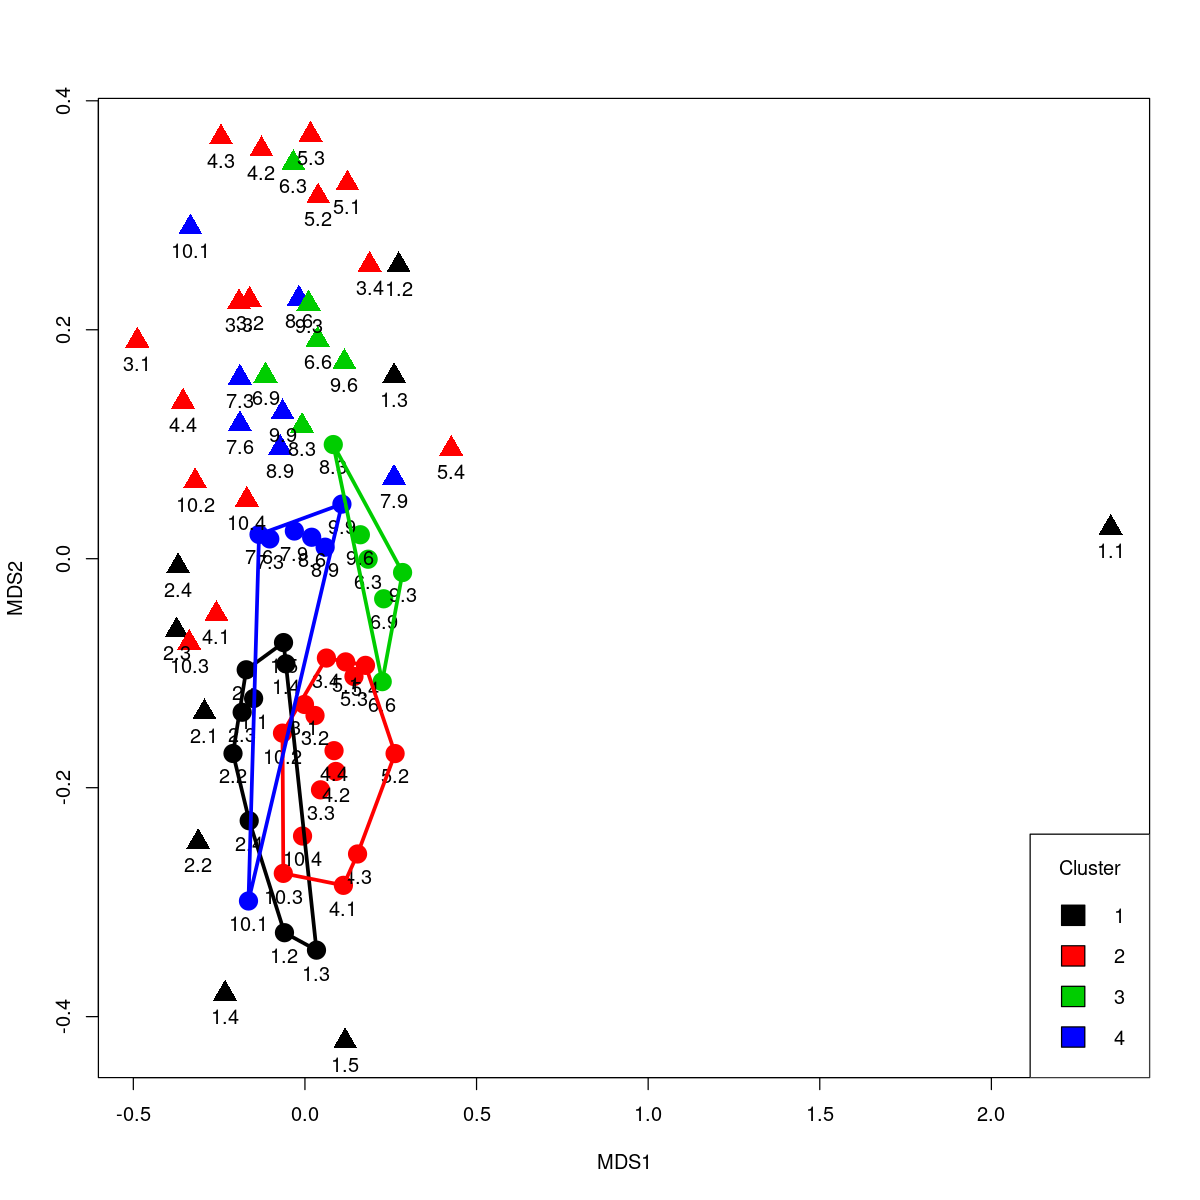

In [13]:
options(repr.plot.width=10, repr.plot.height=10)
plot(MDS1, MDS2,
col=comboGr,
pch=symbs,
cex=2.0,
)
text(MDS1, MDS2 - 0.02, adultosDejovenes$PsubP, cex=1)
ordihull(comboNMS, comboGrAdOnly, col=c('NA',1,2,3,4), lwd=3)
legend( x='bottomright',
        legend = 1:4,
        fill = 1:4,
        cex = 1.0,
        title='Cluster',
        )

Ignoring the point way off to the east, we can zoom in a little:

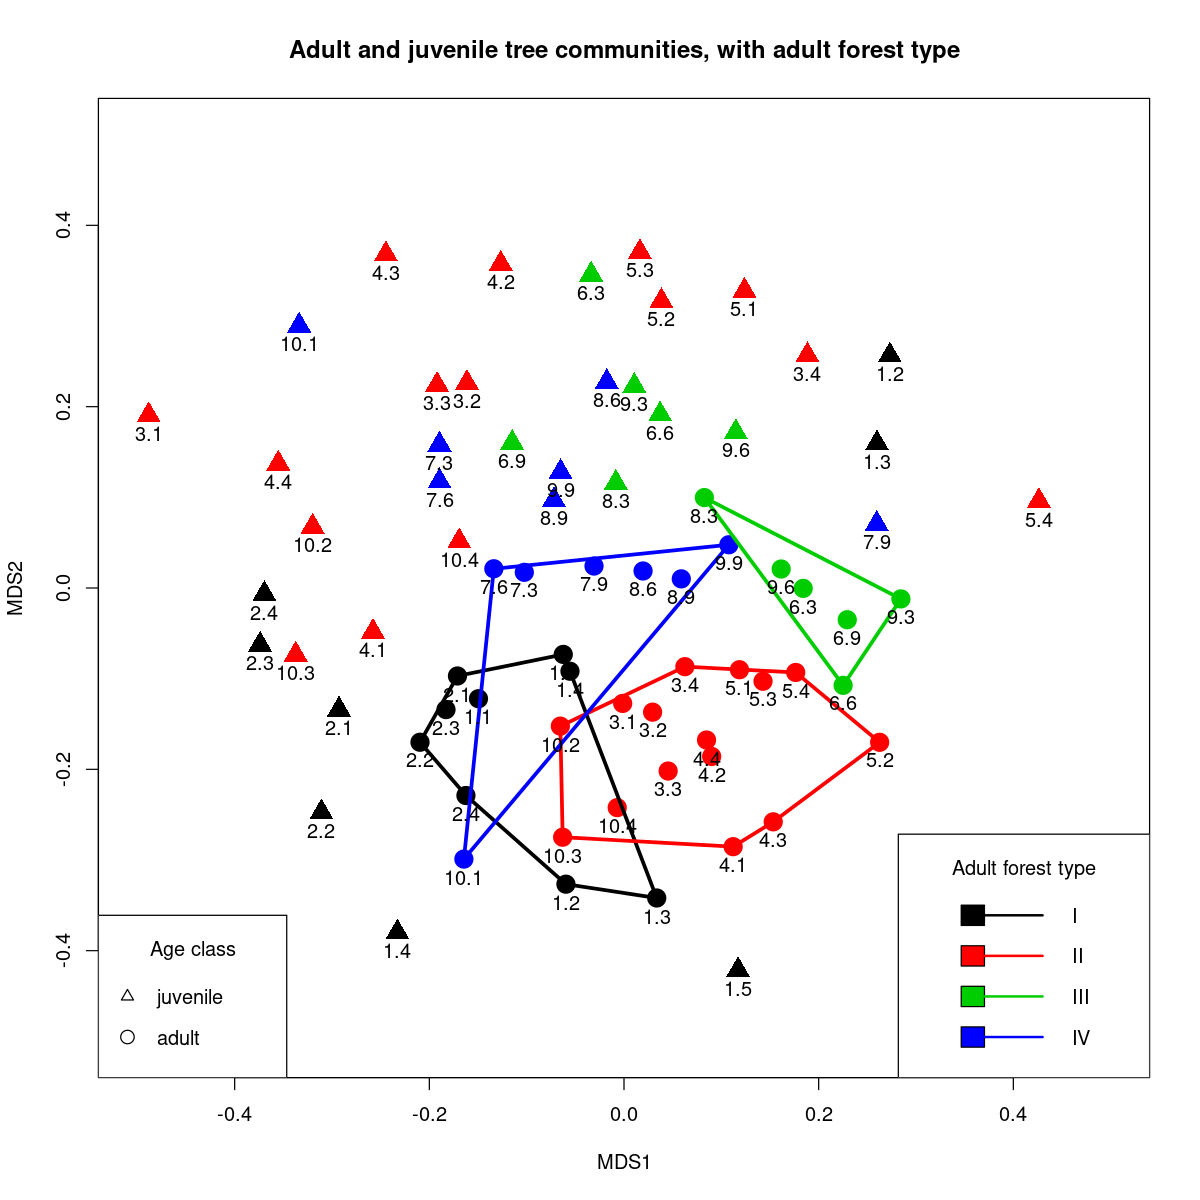

In [20]:
## zoom a little, see how that looks:
options(repr.plot.width=10, repr.plot.height=10)

#svg('graphics/comboJuvAdultForestType_NMS.svg', width=10, height=10)
MDS1 <- comboNMS$points[,'MDS1']
MDS2 <- comboNMS$points[,'MDS2']
plot(MDS1, MDS2,
col=comboGr,
pch=symbs,
cex=2.0,
xlim=c(-0.5, 0.5),
ylim=c(-0.5, 0.5),
main="Adult and juvenile tree communities, with adult forest type"
)
ordihull(comboNMS, comboGrAdOnly, col=c('NA',1,2,3,4), lwd=3)
text(MDS1, MDS2 - 0.02, adultosDejovenes$PsubP, cex=1)
legend( x='bottomright',
        legend = c('I','II','III','IV'),
        fill = c(1:4),
        col = c(1:4),
        cex = 1.0,
        lty = 1,
        lwd = 2,
        title='Adult forest type',
        )
legend( x='bottomleft',
        pch = c(2,1),
        legend = c('juvenile','adult'),
        cex = 1.0,
        pt.cex = c(1.0,1.5),
        title='Age class',
        )

#dev.off()

Here we see that the juvenile tree community is very different from the parental generation. Whereas these natural cluster groups separated cleanly among the adults, the juveniles are leaving these species-spaces and creating very different species assemblages. The juveniles from regenerating sites (red triangles) seem to be either (1) becoming more similar to either the juveniles of old forest sites (green and blue triangles), or (2) radiating generally away in an undifferentiated manner, more similar to the adults and juveniles of the original cluster 1 type. This class 1 type was more the cluster type that generally corresponded to heavy agicultural impacts ("RCA"). 

But interestingly, neither exactly resembles the parental forest. If we regard the juveniles as a signal of where the forest is heading, nothing is staying the same. Even the old forest is changing into something new. Interestingly, the two types of forest we detected in the parents (type 3, the higher and drier forest, and type 4, the lower and wetter forests) seem to be less differentiated in their juveniles. 

Now let's look at adult/juvenile differences in "habitat" classification scheme used by Ana...

[back to top](#contents)

<a id='childrenOfHabitat'></a>
#### Juvenile points, relation to habitat type

"Habitat type" is the descriptor that Ana et al. give to the type of previous land use of a site before reforestation. Habitat type was a useful predictor of differences among these sites [above](#NMS).


In [21]:
library('vegan')

envOnly <- read.csv('envOnly.csv')
adultosDejovenes <- read.csv('adultosDejovenes.csv')
load(file='comboNMS.rda')
comboHab <- sapply(adultosDejovenes$PsubP, function(x){ envOnly[envOnly$PsubP == x,'habitat']})

MDS1 <- comboNMS$points[,'MDS1']
MDS2 <- comboNMS$points[,'MDS2']

In [22]:
comboHabAdOnly <- comboHab
levels(comboHabAdOnly) <- c(levels(comboHabAdOnly), 'juv')
for (i in 1:length(comboHabAdOnly)){
    if (adultosDejovenes[i,'X'] == 'joven'){
    comboHabAdOnly[i] <- 'juv'}
}

## hull colors
hullColrsMap <- c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', NA)
names(hullColrsMap) <- names(table(comboHabAdOnly))
## regular colors, all points need this juv or adult:
colrsMap <- c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00')
names(colrsMap) <- names(table(comboHab))
colrs <- colrsMap[comboHab]

## symbols
symbs=vector(length=length(comboHabAdOnly))
for (i in 1:length(comboHabAdOnly)){
    if (adultosDejovenes[i,'X'] == 'adulto'){
        symbs[i] <- 19} else {
            if (adultosDejovenes[i,'X'] == 'joven'){
                symbs[i] <- 17}
}}

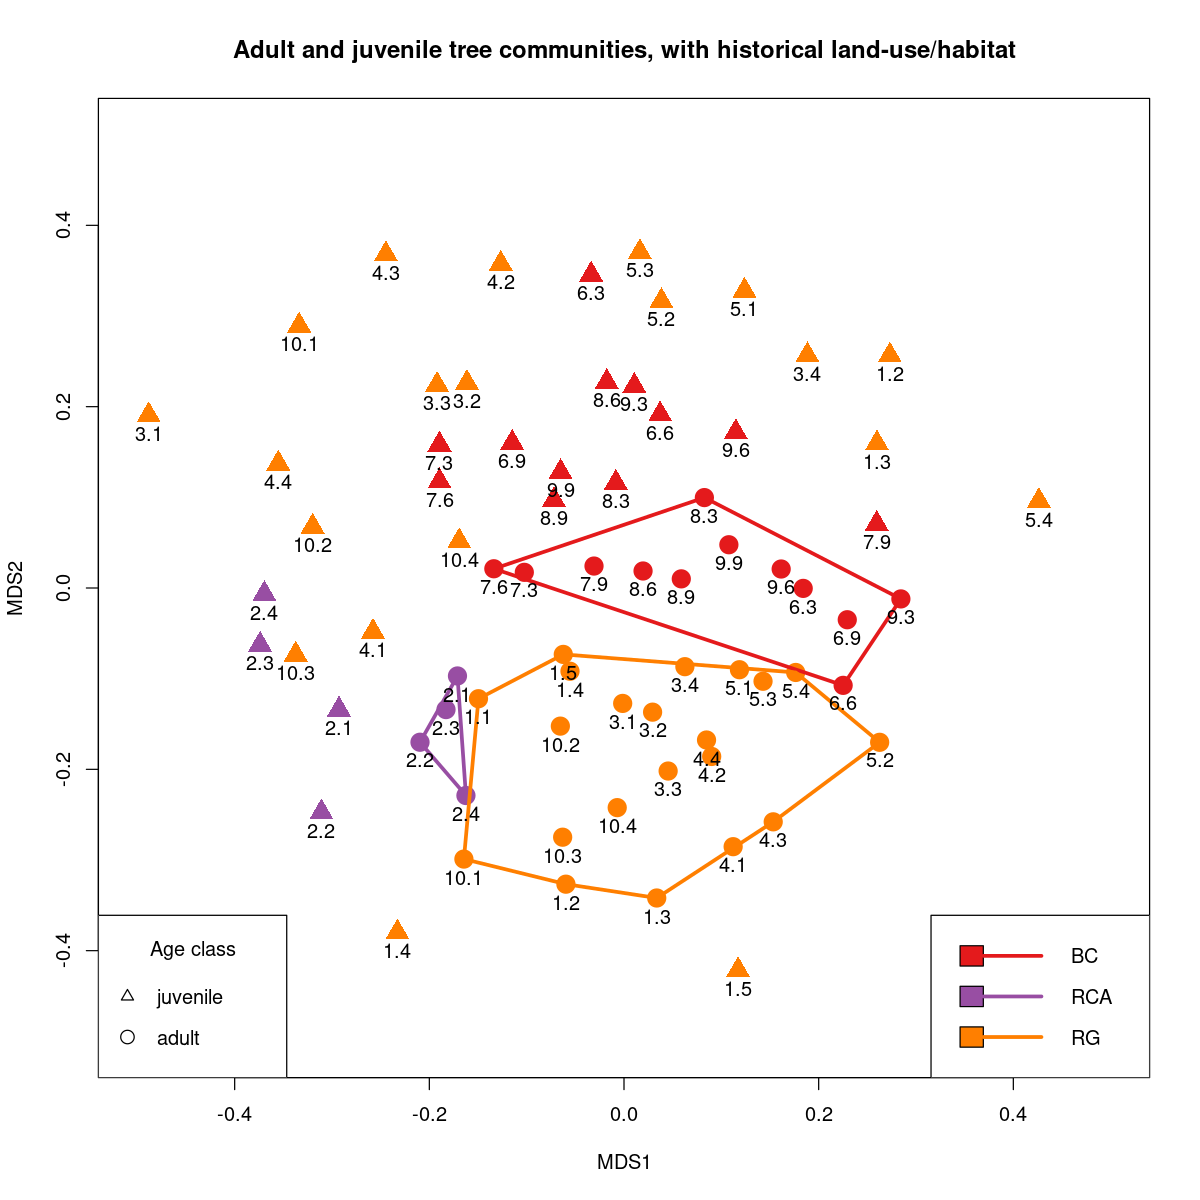

In [34]:
options(repr.plot.width=10, repr.plot.height=10)

#svg('graphics/comboJuvAdultLandUse_NMS.svg', width=10, height=10)
plot(MDS1, MDS2,
    col=colrs,
    pch=symbs,
    cex=2.0,
    xlim=c(-0.5, 0.5),
    ylim=c(-0.5, 0.5),
    main="Adult and juvenile tree communities, with historical land-use/habitat"
)
ordihull(comboNMS, comboHabAdOnly, col=hullColrsMap, lwd=3)
text(MDS1, MDS2 - 0.02, adultosDejovenes$PsubP, cex=1)
legend( x='bottomright',
        legend = levels(droplevels(comboHab)),
        fill = colrsMap[levels(droplevels(comboHab))],
        col = c('#E41A1C', '#984EA3', '#FF7F00'),
        lty = 1,
        lwd = 3,
        cex = 1.0
        )

legend( x='bottomleft',
        pch = c(2,1),
        legend = c('juvenile','adult'),
        cex = 1.0,
        pt.cex = c(1.0,1.5),
        title='Age class',
        )
#dev.off()

This shows us that we lack data for any of the gap ("CLB") or secondary natural forest ("BS"). But the story is similar as with the natural clustering results, and a bit clearer here. The regeneracion sites seem two be moving in the two directions, towards the RCA pole and along the old forest axis. The RCA sites seem to be moving in a very different direction altogether. 

<a id="juvHier"></a>
#### Hierarchical clustering of juveniles

We can also approach this with a hierarchical clustering approach,as we did with the adult trees:

In [12]:
library(stats)
library(vegan)
## where is our community matrix of juveniles?
juvComm <- read.csv('juvComm.csv', header=TRUE, row.names='PsubP')
envOnly <- read.csv('envOnly.csv')
## checks
rowSums(juvComm)
any(colSums(juvComm) == 0)
all(colSums(juvComm) > 0)

1.1  1.2  1.3  1.4  1.5  2.1  2.2  2.3  2.4  3.1  3.2  3.3  3.4  4.1  4.2  4.3 
   1   10    5    6    5   13   16   16   32   17   21   18   13   17    7   22 
 4.4  5.1  5.2  5.3  5.4  6.3  6.6  6.9  7.3  7.6  7.9  8.3  8.6  8.9  9.3  9.6 
   9   13   15   13    6   33   29   21   46   39   42   40   49   66   33   24 
 9.9 10.1 10.2 10.3 10.4 
  38   18   25   16   15

[1] FALSE

[1] TRUE

In [13]:
juvCommBray <- vegdist(juvComm)
juvComm.ward <- hclust(juvCommBray, method='ward.D2')

Among the juveniles, if we force the number of groups to be k=3, these are the topology and groups:

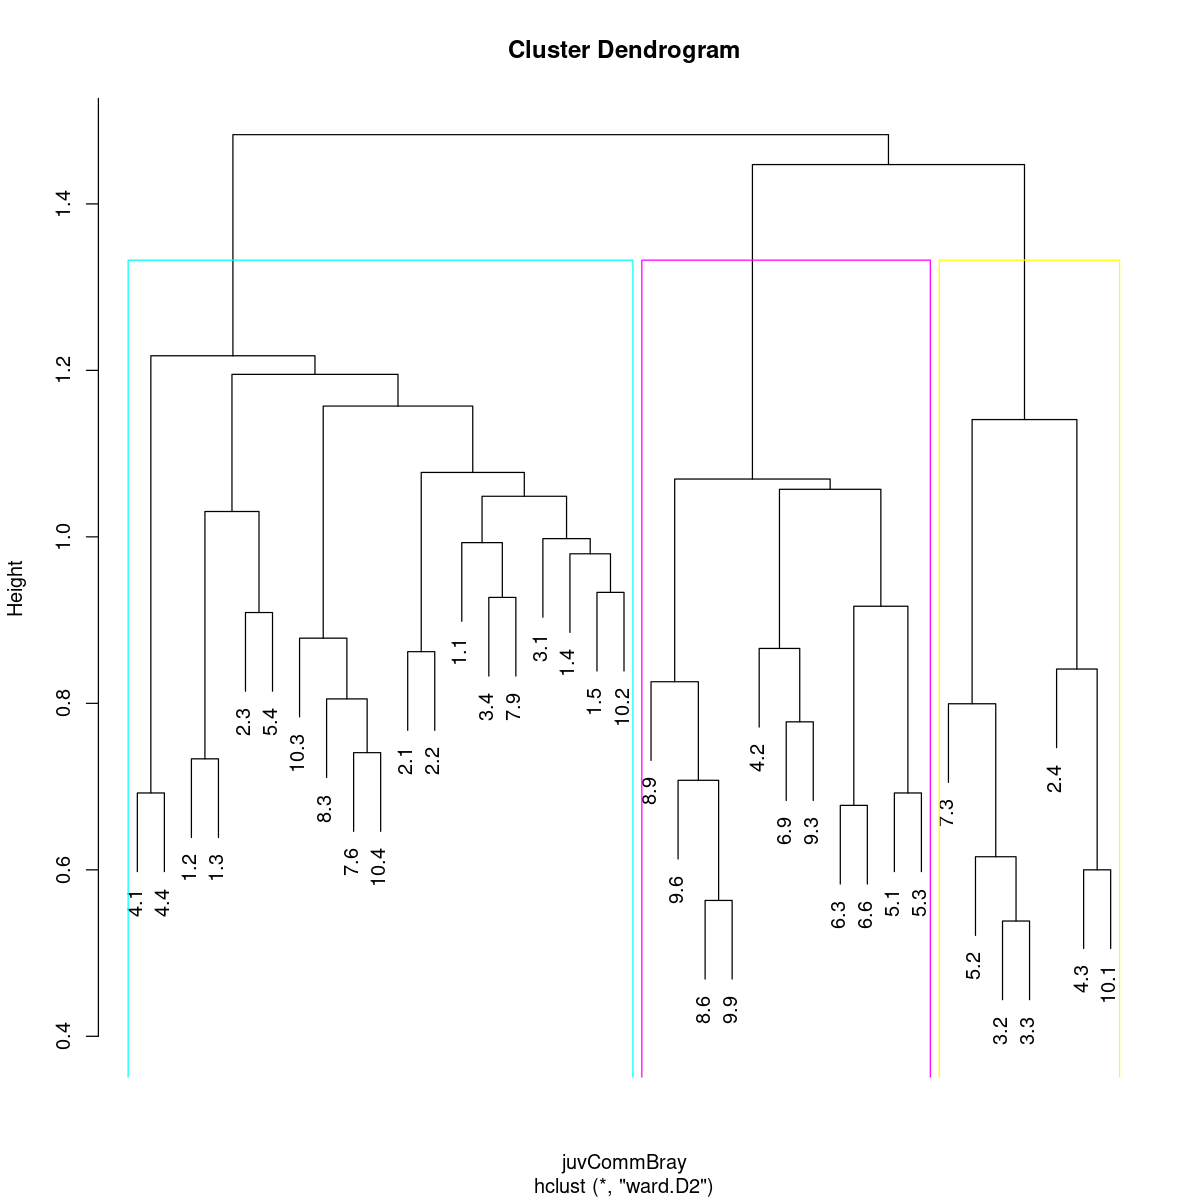

In [14]:
options(repr.plot.width=10, repr.plot.height=10)
plot(juvComm.ward)
k=3
juvGrp <- rect.hclust(juvComm.ward, border=c(1:k+4), k=k)


If we label these using the "habitat type" (previous land use), we see a clade that consists almost entirely of the bosque cerrado sites, agreeing pretty well with our NMS ordinations above. 

[1] TRUE

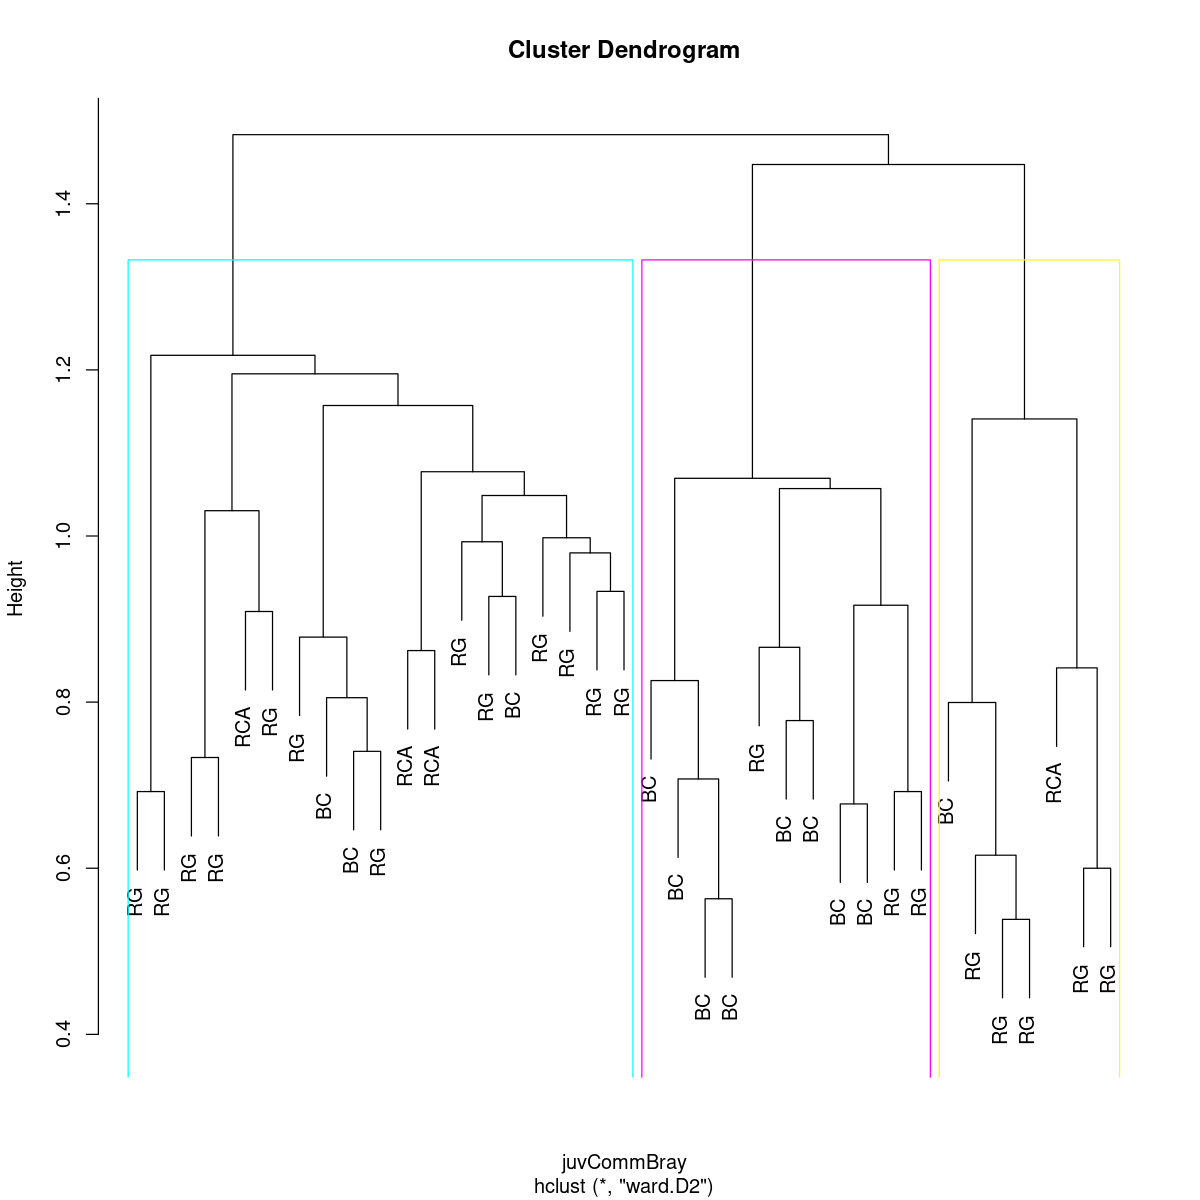

In [16]:
## get out cluster group:
cmem <- vector(length=k)
PsubP <- vector()
gr <- vector()
for (i in 1:k){
    cmem.i <- as.numeric(attr(juvGrp[[i]], "names"))
    PsubP <- c(PsubP, cmem.i)
    gr <- c(gr, rep(i, length(cmem.i)))
    }
cGroup <- data.frame(PsubP, gr)
findG = function(psubp){
    return(envOnly[envOnly$PsubP == psubp,'habitat'])
}
cGroup$habitat <- sapply(cGroup$PsubP, findG)
## order by PsubP, because as is this is not working 
## for labels:
cGroup <- cGroup[order(cGroup$PsubP),]
all(rownames(juvComm) == cGroup$PsubP)
## jeezus. there has got to be an easier way to do that.

aa <- hclust(juvCommBray, method='ward.D2')
plot(aa, labels=cGroup$habitat)
bb <- rect.hclust(aa, k=k, border=(1:k)+4)


In [1]:
import sys

In [2]:
sys.version

'3.7.7 (default, Mar 23 2020, 22:36:06) \n[GCC 7.3.0]'

[back to top](#contents)

<a id="deforest"></a>
### Deforestation in the region

Using the [Ministerio del Ambiente's GIS website](http://ide.ambiente.gob.ec/mapainteractivo/) we can make some observations about how well Los Cedros has done it's job of protecting the forest, compared to other areas in Cotacachi. Los Cedros has been around since the mid/late 1980's, and we have data going almost that far back for land use/cover, including "Bosque Nativo".

<a id="dataCleanup"></a>
#### Data cleanup

Data can be gotten with the above website and a few mouse clicks, but the webserver itself can be directly queried. As of may 2021, For 1990 land use/cover data for all of ecuador:

`http://ide.ambiente.gob.ec/geoserver/mae_ide/ows?service=WFS&version=1.0.0&format_options=CHARSET:UTF-8&request=GetFeature&typeName=mae_ide:v_ff010_cobertura_vegetal_1990_a&outputFormat=SHAPE-ZIP`

And for 2018:

`http://ide.ambiente.gob.ec/geoserver/mae_ide/ows?service=WFS&version=1.0.0&format_options=CHARSET:UTF-8&request=GetFeature&typeName=mae_ide:v_ff010_cobertura_vegetal_2018_a&outputFormat=SHAPE-ZIP`

These data are messy. They are vector (polygon) data, with a LOT of invalidities in their boundaries. They are also very big, with hundreds of thousands of polygons. It looks like they were probably converted from raster data. If this is the case, it is a shame that they don't provide the original rasters, this would be a much more manageable format and closer to the original data. 

The invalidities prevented any easy manipulation of the vector data by geopandas, as the shapely package often refuses to budge until all invalidities are resolved. Resolving them was impossible for me, as there are thousands of invalidities, so I converted back to rasters, using [gdal](gdal.org) tools from the command line. With [gdal_rasterize](https://gdal.org/programs/gdal_rasterize.html) we can trim and convert all those messy polygons into rasters and not worry about any of the 1000's of minor invalidities in the vectors.

I estimated a bounding box for the Cotacachi Canton, and guessed that the original resolution for their raster was somewhere around 30m x 30m. The data are already in UTM17S project, which makes the units easy:

In [ ]:
## in shell

## for 1990 data
gdal_rasterize \
    -a cob1codes \ #the column of interest, gives us the landuse code we want
    -te 720000 10020000 811000 10070000 \ #Cotacachi Canton bounding box
    -tr 30 30 \ #30m x 30m resolution
    forest1990coded.shp \ #input vector file
    forest1990CotacachiCoded.tif #out

## for 2018 data
gdal_rasterize \
    -a cob0codes \ 
    -te 720000 10020000 811000 10070000 \ 
    -tr 30 30 \ 
    forest2018coded.shp \ 
    forest2018CotacachiCoded.tif 

We'll store these in the GIS folder. Some cleanup is needed, the 1990 data has spanish accents in its land use categories and the 2018 doesn't. There are more categories in the 1990 data, and the website uses slightly different color scheme for these two years. We'll need a consistent color scheme that works for both years. I will also clip to just the actual shape of the Cotacachi canton for this analysis (not just the bounding box of the canton). 

So some mind-numbing data-wrangling here follows. 

First, let's clip the landuse rasters further, to fit the Cotacachi Canton polygon shape, and fill in the non-Cotacachi-Canton cells with 13, the value we'll use in our color maps for cells with no-info.  

In [8]:
## clip the 1990 raster to the cotacachi canton
forest1990maskArray, forest1990maskTransform = rasterio.mask.mask(dataset=forest1990rast,
                                                           shapes=cotacachi.geometry,
                                                           nodata=13, ## = "SIN INFORMACION"
                                                           crop=True
                                                           )
forest1990mask_meta = forest1990rast.meta.copy()

forest1990mask_meta.update({"driver": "GTiff",
           "height": forest1990maskArray.shape[1],
           "width": forest1990maskArray.shape[2],
           "transform": forest1990maskTransform,
           "crs": rasterio.crs.CRS.from_epsg(32717)}
          )

## rinse and repeat for 2018:
forest2018maskArray, forest2018maskTransform = rasterio.mask.mask(dataset=forest2018rast,
                                                           shapes=cotacachi.geometry,
                                                           nodata=13,
                                                           crop=True
                                                           )
forest2018mask_meta = forest2018rast.meta.copy()

forest2018mask_meta.update({"driver": "GTiff",
           "height": forest2018maskArray.shape[1],
           "width": forest2018maskArray.shape[2],
           "transform": forest2018maskTransform,
           "crs": rasterio.crs.CRS.from_epsg(32717)}
          )


In [9]:
## write them out:
with rasterio.open("cotacachiForest1990.tif", "w", **forest1990mask_meta) as dest:
    dest.write(forest1990maskArray)
    
with rasterio.open("cotacachiForest2018.tif", "w", **forest2018mask_meta) as dest:
    dest.write(forest2018maskArray)

In [2]:
## bring them into memory
cotacachiForest1990 = rasterio.open("cotacachiForest1990.tif")
cotacachiForest2018 = rasterio.open("cotacachiForest2018.tif")

Text(0.5, 1.0, '2018')

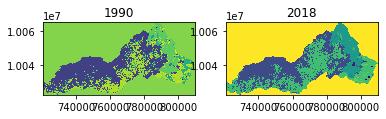

In [3]:
## check - did that work?
fig, axes = plt.subplots(1,2)
rasterio.plot.show(cotacachiForest1990, ax=axes[0])
axes[0].set_title('1990')
rasterio.plot.show(cotacachiForest2018, ax=axes[1])
axes[1].set_title('2018')

Our rasters are clipped to Cotacachi Canton. Now we need to develop a sensible color map to plot them. We'll get the codes for each of these rasters from the original, huge vector files that we got from MAE:

In [15]:
## don't rerun this! Just grab the pickle in the next cell.

forest1990Path = ("/home/daniel/Documents/LosCed/GISfilesTooBigForGithub/"
        "v_ff010_cobertura_vegetal_1990_a/v_ff010_cobertura_vegetal_1990_aPolygon.shp")
forest1990 = gpd.read_file(forest1990Path) ## whoah that be big

aa = forest1990[["cobertura1","geometry"]]
bb = pd.Categorical(aa['cobertura1'])
codes1990 = (bb.categories
                    .to_series()
                    .reset_index(drop=True)
                        )
codes1990[11] = "PLANTACION FORESTAL"
codes1990[12] = "PARAMO"
codes1990[13] = "SIN INFORMACION"
codes1990[15] = "VEGETACION ARBUSTIVA"
codes1990[16] = "VEGETACION HERBACEA"

#codes1990.to_pickle('codes1990.p')

codes1990


0                   AREA POBLADA
1     AREA SIN COBERTURA VEGETAL
2                     ARTIFICIAL
3                  BOSQUE NATIVO
4                  CULTIVO ANUAL
5             CULTIVO PERMANENTE
6        CULTIVO SEMI PERMANENTE
7                        GLACIAR
8                INFRAESTRUCTURA
9                        NATURAL
10                      PASTIZAL
11           PLANTACION FORESTAL
12                        PARAMO
13               SIN INFORMACION
14           TIERRA AGROPECUARIA
15          VEGETACION ARBUSTIVA
16           VEGETACION HERBACEA
dtype: object

In [14]:
del(forest1990) ## too big to keep around. Send off to garbage.

In [4]:
## run this instead!!
codes1990 = pd.read_pickle('codes1990.p')

In [16]:
## Don't rerun this either!!! Just unpickle the codes as above, in the following cell.

## 2018 data is cleaner
forest2018Path = ("/home/daniel/Documents/LosCed/GISfilesTooBigForGithub/"
        "v_ff010_cobertura_vegetal_2018_a/v_ff010_cobertura_vegetal_2018_aPolygon.shp")
forest2018 = gpd.read_file(forest2018Path) ## whoah that also be big

aa = forest2018[["cobertura0","geometry"]]
bb = pd.Categorical(aa['cobertura0'])
aa.insert(1,"cob0codes",bb.codes)
codes2018 = (bb.categories
                    .to_series()
                    .reset_index(drop=True)
                        )

codes2018


0                   AREA POBLADA
1     AREA SIN COBERTURA VEGETAL
2                     ARTIFICIAL
3                  BOSQUE NATIVO
4                        GLACIAR
5                INFRAESTRUCTURA
6                        NATURAL
7                         PARAMO
8            PLANTACION FORESTAL
9            TIERRA AGROPECUARIA
10          VEGETACION ARBUSTIVA
11           VEGETACION HERBACEA
dtype: object

In [22]:
del(forest2018) ## too big to keep around. Send off to garbage.

In [5]:
## run this instead!!
codes2018 = pd.read_pickle('codes2018.p')

I shopped around for the css colors that these layers shared and where they differed I chose the ones that made more sense to me visually. I also lumped all the several farmland categories from 1990 into a single color, matching to the single "TIERRA AGROPECUARIA" of the 2018 data:

In [6]:
## declare our colors for each land use/category:
landUseColDict = pd.Series({
"AREA POBLADA":"#191919",
"AREA SIN COBERTURA VEGETAL":"#bfbac1",
"ARTIFICIAL":"#1676cc",
"BOSQUE NATIVO":"#4d701b",
"GLACIAR":"#76acbf",
"INFRAESTRUCTURA":"#676767",
"NATURAL":"#53c1ea",
"PARAMO":"#69d19b",
"PLANTACION FORESTAL":"#9a3520",
"TIERRA AGROPECUARIA":"#e3d686",
"VEGETACION ARBUSTIVA":"#966b17",
"VEGETACION HERBACEA":"#cec3ae",
"CULTIVO ANUAL":"#e3d686",
"CULTIVO PERMANENTE":"#e3d686",
"CULTIVO SEMI PERMANENTE":"#e3d686",
"PASTIZAL":"#67751b",
"SIN INFORMACION":"#ffffff",
})

## build a master dataframe to keep track of things:
codes1990flip = pd.Series(data=codes1990.index, index=codes1990.values)
codes2018flip = pd.Series(data=codes2018.index, index=codes2018.values)
colrDF = pd.concat([codes1990flip, codes2018flip,landUseColDict], axis=1)
colrDF.reset_index(drop=False, inplace=True)
colrDF.columns=['landUse','codes1990', 'codes2018','co']
colrDF['codes2018'] = colrDF['codes2018'].astype('Int32')
colrDF['codes2018'] = colrDF['codes2018'].astype('Int32')
colrDF.iloc[13,2] = 13 ## add in a "SIN INFORMACION" to 2018 data
colrDF
#colrDF.to_pickle('colrDF.p')

landUse  codes1990  codes2018       co
0                 AREA POBLADA          0          0  #191919
1   AREA SIN COBERTURA VEGETAL          1          1  #bfbac1
2                   ARTIFICIAL          2          2  #1676cc
3                BOSQUE NATIVO          3          3  #4d701b
4                CULTIVO ANUAL          4       <NA>  #e3d686
5           CULTIVO PERMANENTE          5       <NA>  #e3d686
6      CULTIVO SEMI PERMANENTE          6       <NA>  #e3d686
7                      GLACIAR          7          4  #76acbf
8              INFRAESTRUCTURA          8          5  #676767
9                      NATURAL          9          6  #53c1ea
10                    PASTIZAL         10       <NA>  #67751b
11         PLANTACION FORESTAL         11          8  #9a3520
12                      PARAMO         12          7  #69d19b
13             SIN INFORMACION         13         13  #ffffff
14         TIERRA AGROPECUARIA         14          9  #e3d686
15        VEGETACION ARBUSTIVA         15         10  #966b17
16         VEGETACION HERBACEA         16         11  #cec3ae

Looking at this is dataframe gives a nice overview, but we need to individualize the colormaps for the two years, because they have different numbers of categories. We'll use rasterio to load and view the rasters. The files for each are opened with Rasterio in our [GIS cell](#GISfiles) above. 

In [7]:
## helper functions for colormap and color boundaries

def getColorMap(rast, yearCodes):
    rastband = rast.read(1)
    uVals = np.unique(rastband).astype('int')
    colrs = (colrDF.set_index(yearCodes)
                 .loc[uVals]['co']
                 .to_list()
                 )
    return(mcolors.ListedColormap(colrs))

def getBoundaries(raster):
    aa = np.unique(raster.read(1))
    bb = aa - 0.5
    cc = np.append(bb,aa.max()+0.5)
    return(mcolors.BoundaryNorm(cc, len(aa)))

In [14]:
def plotRast(rast, yearCodes, title=None, ax=None, plotBPs=False):
    if ax is None: fig, ax = plt.subplots(figsize=(20,10))
    rastband = rast.read(1)
    uVals = np.unique(rastband).astype('int')
    colrDF_thisyear = colrDF.set_index(yearCodes)
    colrDF_thisyear = colrDF_thisyear[colrDF_thisyear.index.notnull()].loc[uVals]
    legend_patches = [ Patch(color=c, label=l) for c,l in zip(colrDF_thisyear.co, colrDF_thisyear.landUse) ]
    ax.legend(handles=legend_patches,
                facecolor="white",
                edgecolor="black",
                loc="upper left",
                bbox_to_anchor=(1, 1))
    colormap =  getColorMap(rast, yearCodes)
    colorBounds = getBoundaries(rast)
    rasterio.plot.show(rast, ax=ax, cmap=colormap, norm = colorBounds)
    if plotBPs == True:
            lcPoly.boundary.plot(ax=ax, color='r')
            chontalPoly.boundary.plot(ax=ax, color = 'b')
            cebuPoly.boundary.plot(ax=ax, color = 'b')
    xmin, ymin, xmax, ymax = rast.bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    if title is None: ax.set_title("")
    if title is not None: ax.set_title(title)


[back to top](#contents)

<a id="mapDeforest"></a>
#### Maps of forest cover

Great, now use these color maps to make our maps:

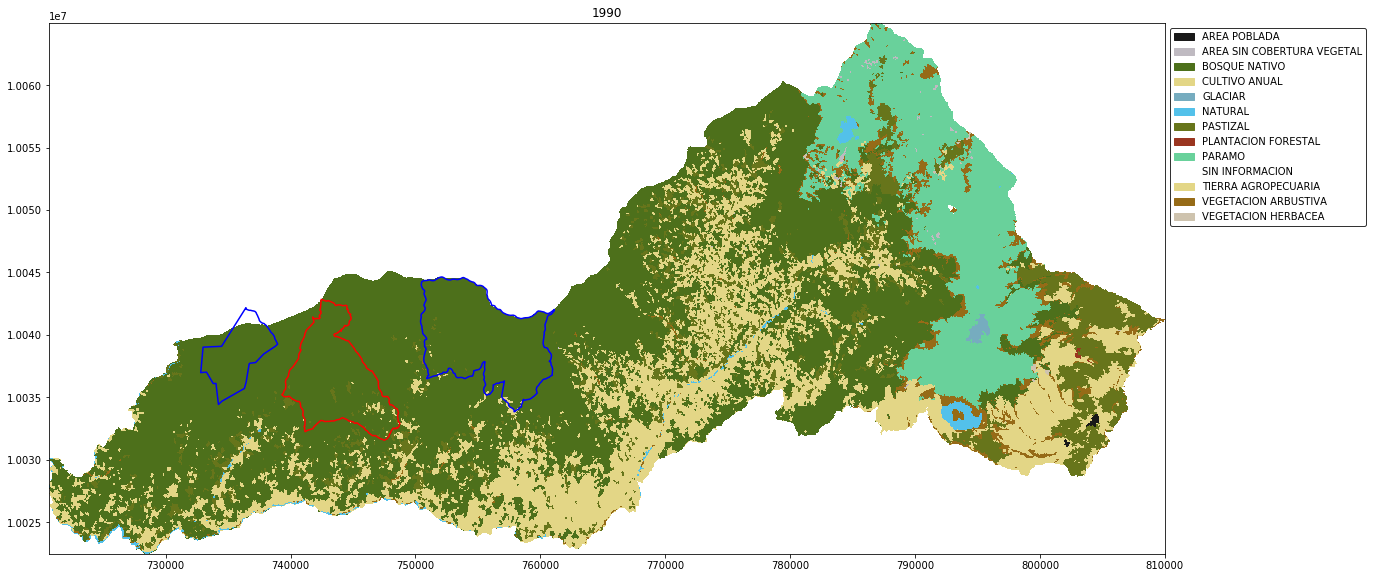

In [16]:
plotRast(cotacachiForest1990, 'codes1990', title='1990', ax=None, plotBPs=True)

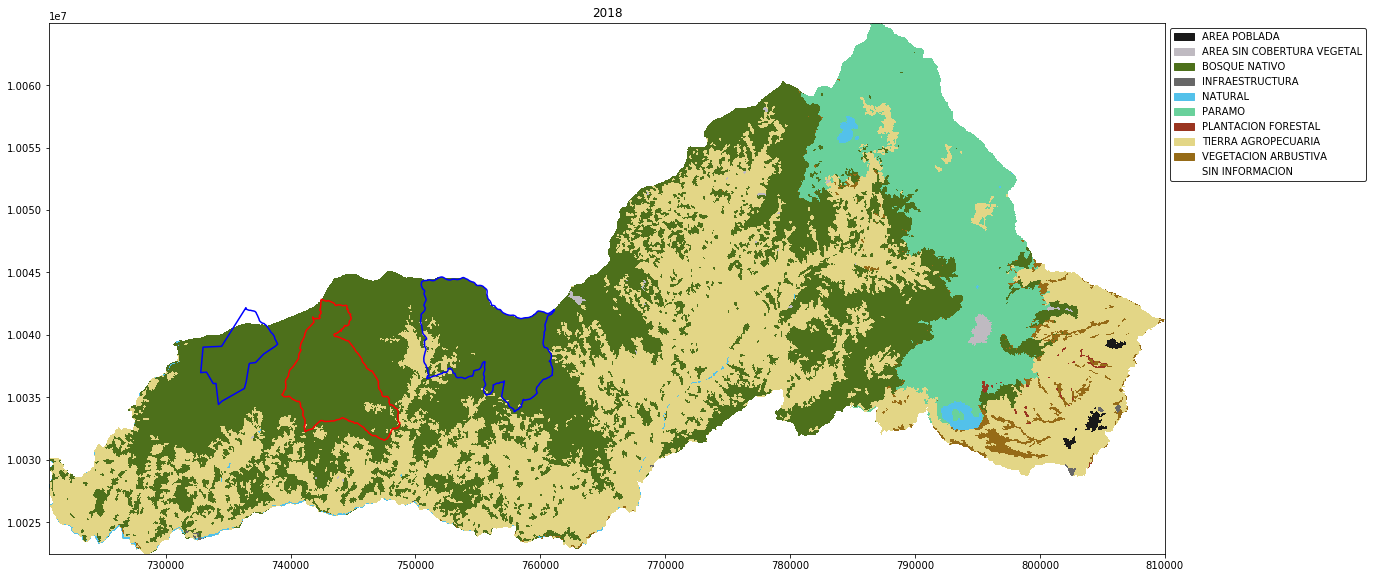

In [17]:
plotRast(cotacachiForest2018, 'codes2018', title='2018', ax=None, plotBPs=True)

The deforestation in this region has been significant. In the eastern half of the canton, in the Intag watershed, the forests have been largely cut or fragmented since their maybe ~50% coverage in the 1990s. The deforestation in the Intag has gone right to the borders of Cotacachi-Cayapas Ecological Reserve. 

In the "Zona Manduriacu" where los Cedros lies, we see much higher retention of forest, but the agricultural zone of the Guayllbamba has grown significantly in the last thirty years, in some places up to the borders of Los Cedros (red) and Bosqu Protector Chontal (=blue polygon that lies just to east of Los Cedros).

The newest change deforestation in the Zona Maduriacu is the establishment of the road to Brilla Sol and the deforestation that has occurred along it. This is the "finger" of agricultural land points north and intrudes into the BP Chontal. This is is an area of active conversion, where the forest is being cleared for cattle pasture:

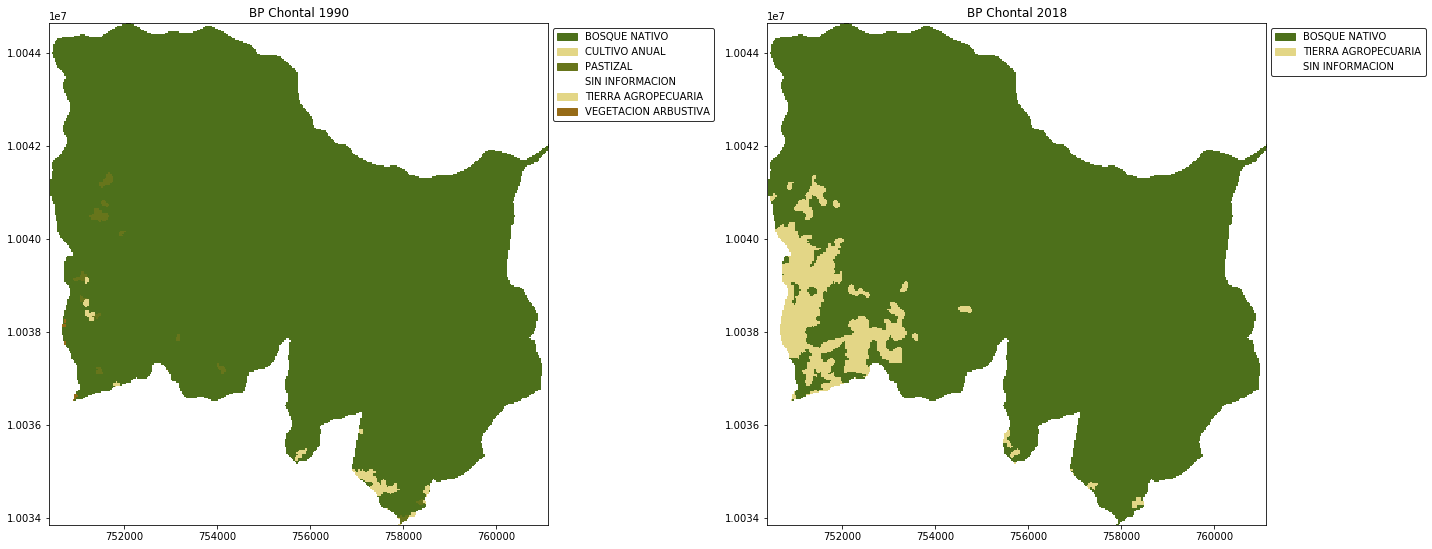

In [30]:
fig, axes = plt.subplots(1,2, figsize=(20,20))
plotRast(chontalForest1990, 'codes1990', title='BP Chontal 1990', ax=axes[0], plotBPs=False)
plotRast(chontalForest2018, 'codes2018', title='BP Chontal 2018', ax=axes[1], plotBPs=False)
plt.tight_layout()

We have the opposite trend with Los Cedros. Since the 1990's, areas of pasture and agriculture have grown in with forest:

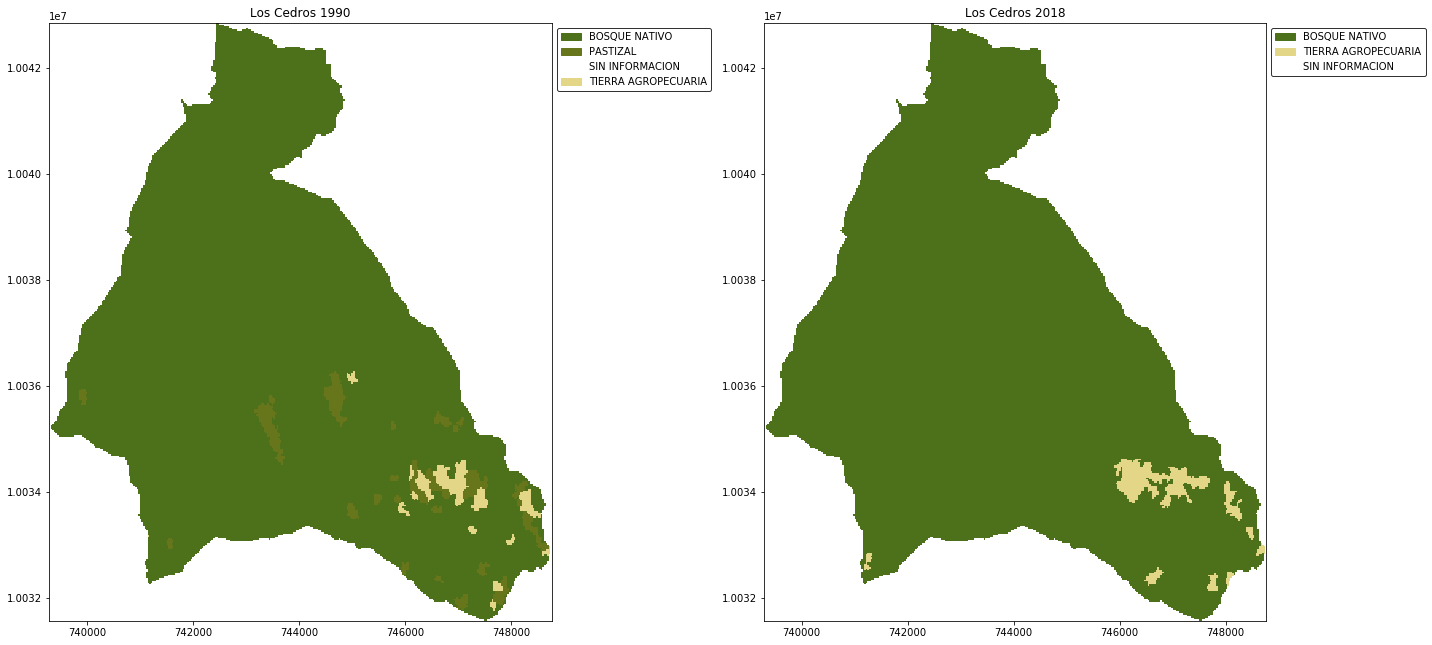

In [31]:
fig, axes = plt.subplots(1,2, figsize=(20,20))
plotRast(losCedrosForest1990, 'codes1990', title='Los Cedros 1990', ax=axes[0], plotBPs=False)
plotRast(losCedrosForest2018, 'codes2018', title='Los Cedros 2018', ax=axes[1], plotBPs=False)
plt.tight_layout()

Thus, despite a regional trend of deforestation, Los Cedros has experienced a net gain in forest cover in the last 30 years. 

<a id='barchartDeForestation'></a>

#### Deforestation statistics
Looking directly at the numbers:

In [33]:
## a function for getting the cell totals 

def makePixelTotals(raster, codes):
    band = raster.read(1)
    fa = band.flat
    bandSorted = np.sort(fa)
    uVals = np.unique(band).astype('int')
    ## find number of pixels for each category of land use:
    breaks = np.searchsorted(bandSorted, uVals)
    breaks = np.concatenate([breaks, [len(fa)]])
    totals = breaks[1:] - breaks[:-1]
    colrDF = pd.read_pickle('forestRastColrDF.p').set_index(codes)
    landUsePixelSums = pd.Series(data=totals,
                                     index=colrDF.loc[uVals].landUse)
    return(landUsePixelSums)


In [34]:
## get our totals
landUseCotacachi1990 = makePixelTotals(cotacachiForest1990, 'codes1990').drop('SIN INFORMACION')
landUseCotacachi2018 = makePixelTotals(cotacachiForest2018, 'codes2018').drop('SIN INFORMACION')
landUseLosCedros1990 = makePixelTotals(losCedrosForest1990, 'codes1990').drop('SIN INFORMACION')
landUseLosCedros2018 = makePixelTotals(losCedrosForest2018, 'codes2018').drop('SIN INFORMACION')
landUseChontal1990 = makePixelTotals(chontalForest1990, 'codes1990').drop('SIN INFORMACION')
landUseChontal2018 = makePixelTotals(chontalForest2018, 'codes2018').drop('SIN INFORMACION')

In [36]:
## barchart comparisons of forest with absolute area:
lu1990 = [ landUseCotacachi1990, landUseChontal1990, landUseLosCedros1990 ]
lu2018 = [ landUseCotacachi2018, landUseChontal2018, landUseLosCedros2018 ]
## absolute forest covers, m2:
abs1990 = [ (i['BOSQUE NATIVO'] * 900/10000 ) for i in lu1990 ]
abs2018 = [ (i['BOSQUE NATIVO'] * 900/10000 ) for i in lu2018 ]
## percent forest 
perc1990 = [ (i['BOSQUE NATIVO']*100 / i.sum() ) for i in lu1990 ]
perc2018 = [ (i['BOSQUE NATIVO']*100 / i.sum() ) for i in lu2018 ]

In [64]:
print(abs1990)
print(abs2018)

[87967.35, 6919.65, 5094.72]
[71738.55, 6564.96, 5210.19]


In [71]:
forestLossDF = pd.DataFrame(data={'ha_1990':abs1990, 'ha_2018':abs2018,
                   '%_1990':perc1990, '%_2018':perc2018}, index=(['Cotacachi','Chontal','Los Cedros']))


In [37]:
## plot 
def barPlotForestChange(data1990, data2018, yUnits, ax=None, annotate=False):
    labels = ['Cotacachi', 'Chontal', 'Los Cedros']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars
    if ax is None: fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, data1990, width, label='1990')
    rects2 = ax.bar(x + width/2, data2018, width, label='2018')
    ax.set_ylabel(yUnits)
    ax.set_title('Gain/loss of forest, ' + yUnits)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    return(fig, ax, width, x)

In [72]:
forestLossDF

ha_1990   ha_2018     %_1990     %_2018
Cotacachi   87967.35  71738.55  52.143984  42.520283
Chontal      6919.65   6564.96  99.004610  93.929795
Los Cedros   5094.72   5210.19  95.798006  97.969234

Cotacachi lost about ten percent of its forests  during the 1990-2018 period:

Text(-0.1, 60000, '87967')

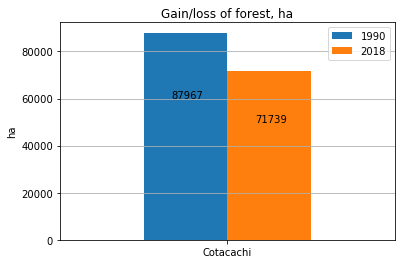

In [63]:
fig, ax, width, xes = barPlotForestChange(abs1990, abs2018, "ha")
ax.grid(b=True, which='both', axis='y')
# our function plots all three categories, so zoom in
ax.set_xlim(-0.3,0.3)
ax.text(0.05,50000, int(round(abs2018[0])))
ax.text(-0.1,60000, int(round(abs1990[0])))

In the last 30 years, Cotacachi canton has lost ~16000 ha of forested land, roughly the equivalent of three los Cedros reserves. 

It is informative to compare Los Cedros and Chontal BP, as this attests to the difference that differing management styles and histories can have on enforcement of forest protections:

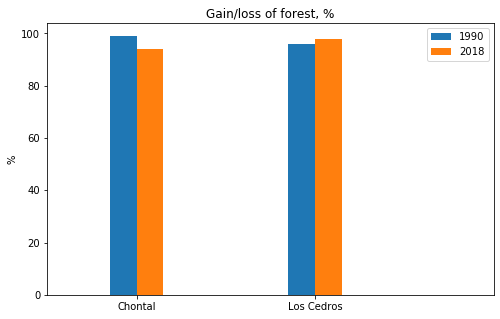

In [85]:
fig, ax, width, xes = barPlotForestChange(perc1990, perc2018, "%")
ax.set_xlim(0.5,3)
fig.set_size_inches(8,5)

As noted in tables above, BP Chontal went from 99% forest cover in 1990 to  94% cover of forest in 2018. By all reports from the ground (haven't been there personally), this deforestation has lately accelerated. This is not a surprise, as the Brilla Sol cattlemen's guild is reportedly the group that manages this BP. In contrast, BP Los Cedros has gotten more forested, as Jose and his colleagues actively reforested the pasture land and other parts of fincas they purchased. The borders of Los Cedros have also been heavily enforced, unlike Chontal. 

[back to top](#contents)

<a id='climate'></a>
### Updating climate data for los Cedros

There is a paucity of recorded data for climate at Los Cedros, as far as I can tell. But we need to address the presence of a wet and "dry" season. The two closest climate stations that I can locate are Nanegalito and Garcia Moreno. I believe the raw data for these sites come from the Ecuadorean meterological institute, [INAMHI](https://www.serviciometeorologico.gob.ec/), but their interface is difficult for me to use. I cannot seem to locate the original data. But the [Weather Atlas site](www.weather-atlas.com) website seems to use their data produce the following long term summaries:

<div>
<img src='nanegalitoRain.gif'>
</div>
(source: https://www.weather-atlas.com/en/ecuador/garcia-moreno-climate)
<div>
<img src='garciaMorenoRain.gif'>
</div>
(source: https://www.weather-atlas.com/en/ecuador/nanegalito-climate)

These are not going to be perfect measures of the weather at Los Cedros. But they are probably as close as we are going to get. It's not even clear what exactly is being shown - which years, how many years, etc. But I think it is safe to say that the "dry season" is sufficiently different to be noted in our summary of los Cedros. The dry season could probably be considered to last from June to September. 